In [ ]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# adjusting figure resolution
plt.rcParams['figure.dpi'] = 300

In [ ]:
# Read datasets needed (if using google drive)
proact_full = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_with_NaNs.csv')
study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')
snuh_full = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/X_and_Y_SNUH_with_NaNs.csv')
snuh_dx = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/Raw data/SNUH/snuh_dx2.csv')

<ipython-input-4-e5d3ea7e6e6b>:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  study_population = pd.read_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/PRO-ACT_filtered.csv')


In [ ]:
proact_full.drop(columns=['Unnamed: 0'], inplace = True)
study_population.drop(columns=['Unnamed: 0'], inplace = True)
snuh_full.drop(columns=['Unnamed: 0'], inplace = True)

In [ ]:
def extract_static_feature(df, feature_list):
  df_final = df[df['feature_name'] == feature_list[0]][['SubjectID', 'feature_value']].rename(columns = {'feature_value': feature_list[0]})

  del feature_list[0]
  for x in feature_list:
    df_add = df[df['feature_name'] == x][['SubjectID', 'feature_value']].rename(columns = {'feature_value': x})
    df_final = pd.merge(df_final,df_add, on=['SubjectID'], how='inner')

  return df_final

In [ ]:
proact_demographics = extract_static_feature(study_population, ['Age', 'Gender'] ).query("SubjectID=={0}".format(proact_full['SubjectID'].unique().tolist()))

In [ ]:
proact_demographics = proact_demographics[['SubjectID', 'Age']].sort_values(by='SubjectID', ascending=True)

snuh_dx['Year_Difference'] = pd.to_datetime(snuh_dx['Date_enrollment']).dt.year - pd.to_datetime(snuh_dx['Date_dx']).dt.year
snuh_dx['Age'] = snuh_dx['Age_dx'] + snuh_dx['Year_Difference']
snuh_demographics = snuh_dx[['Study_ID', 'Age']].sort_values(by='Study_ID', ascending=True)

In [ ]:
proact_demographics = proact_demographics[['SubjectID', 'Age']]
snuh_demographics.columns = ['SubjectID', 'Age']

In [ ]:
proact_feature = proact_full.drop(['time_LOA', 'status_LOA'], axis = 1)
snuh_feature = snuh_full.drop(['time_LOA', 'status_LOA'], axis = 1)

proact_target = proact_full[['SubjectID', 'time_LOA', 'status_LOA']]
snuh_target = snuh_full[['SubjectID', 'time_LOA', 'status_LOA']]

In [ ]:
# Set Age as numerical data
proact_feature.drop(columns=['Age'], inplace = True)
proact_feature = pd.merge(proact_demographics, proact_feature, on = 'SubjectID', how='outer')

snuh_feature.drop(columns=['Age'], inplace = True)
snuh_feature = pd.merge(snuh_demographics, snuh_feature, on = 'SubjectID', how='outer')

# 1. Study population (patients)

### PROACT = 3,396
### SNUH   = 207

In [ ]:
# Find details in 'Data Preprocessing.ipynb' files

# 2. F/U duration (months)

### PROACT = 7.8 (IQR 3.0 - 10.2)
### SNUH   = 11.4 (IQR 4.9 - 19.4)

Text(0.5, 1.0, 'SNUH')

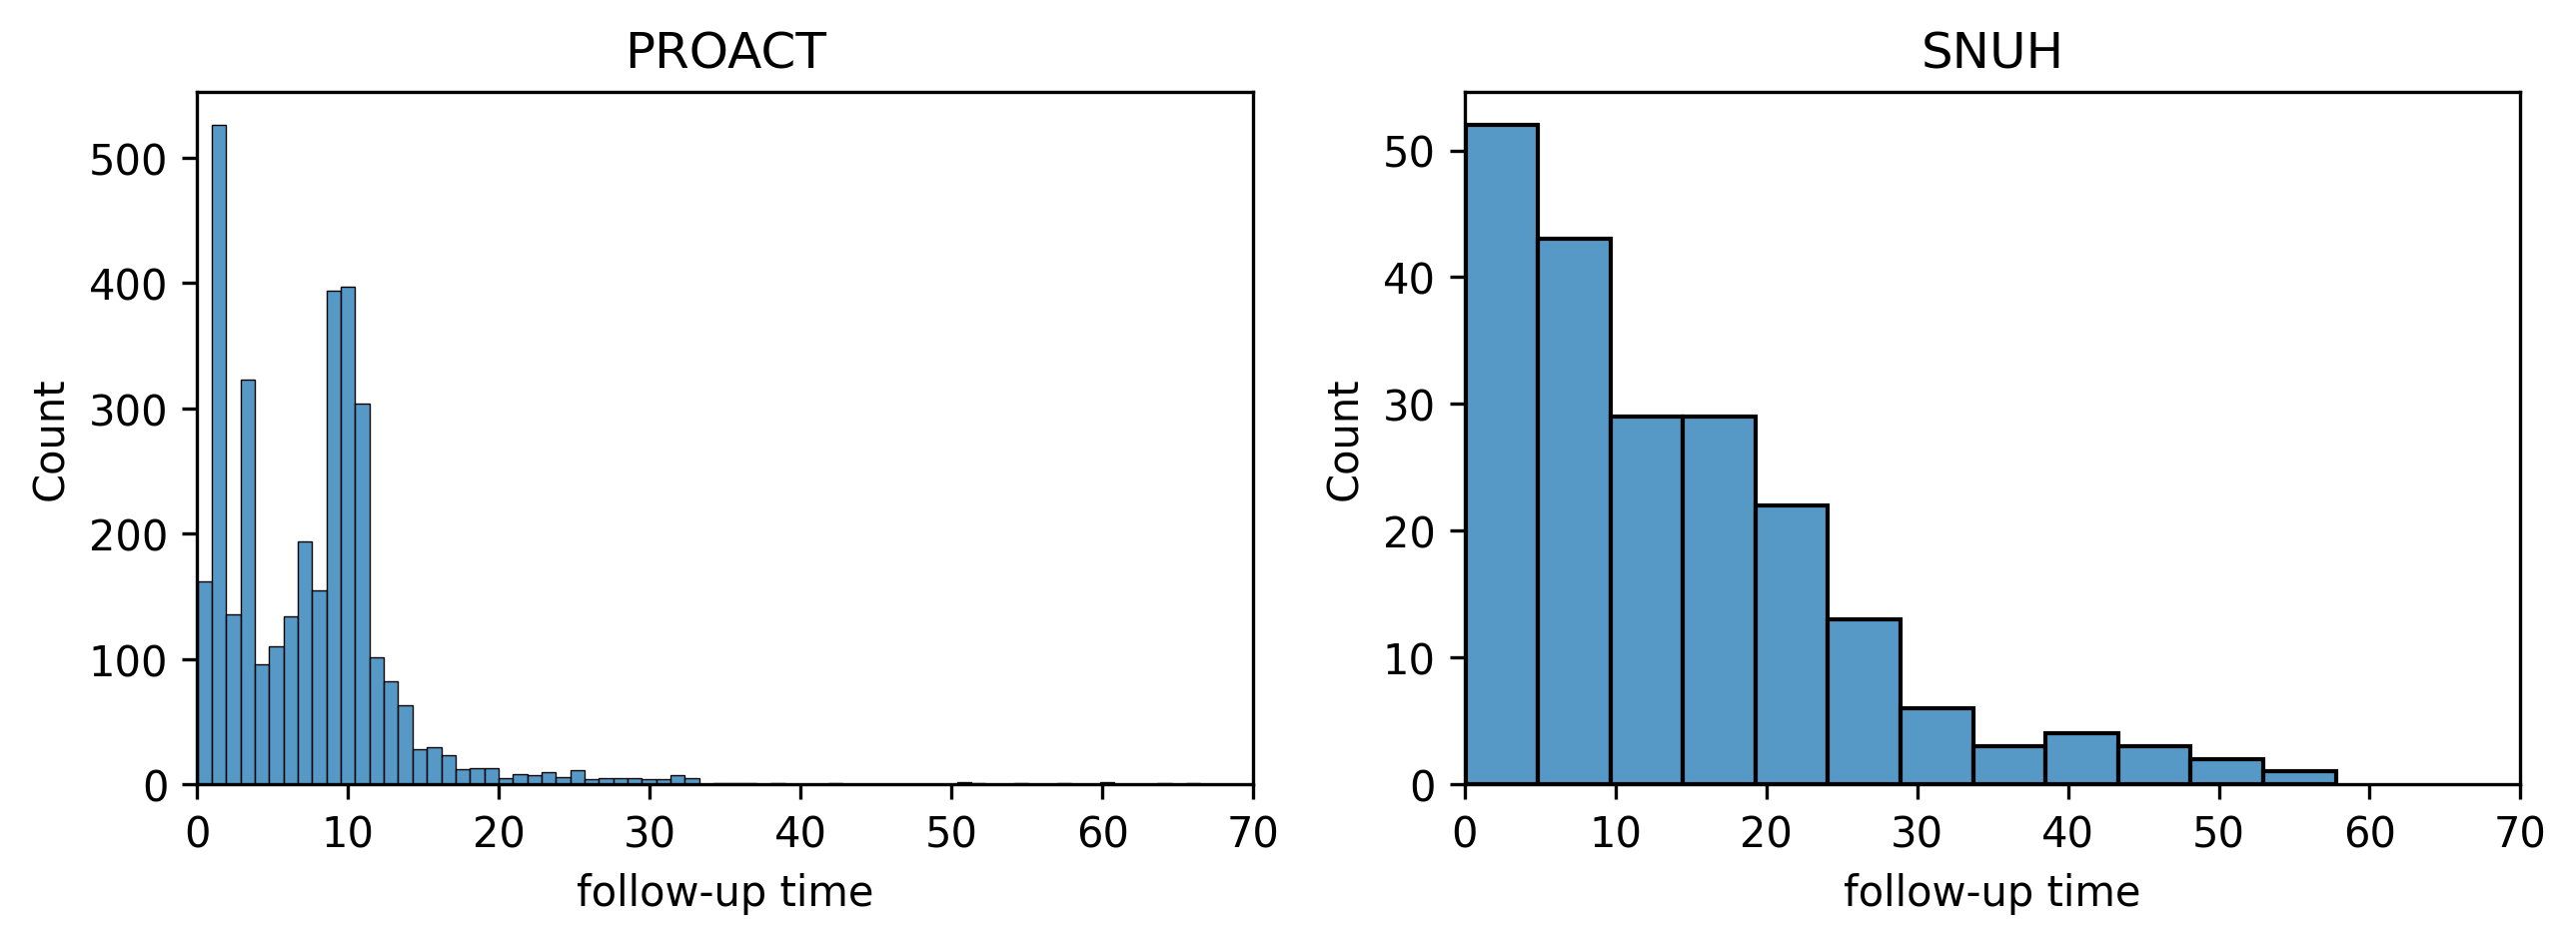

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.histplot(proact_full['time_LOA'])
plt.xlabel('follow-up time')
plt.xlim([0,70])
plt.title('PROACT')

plt.subplot(1,2,2)
sns.histplot(snuh_full['time_LOA'])
plt.xlabel('follow-up time')
plt.xlim([0,70])
plt.title('SNUH')

#SNUH seems to have more amount of early-censoring

In [ ]:
u, pvalue = st.mannwhitneyu(x=proact_full['time_LOA'], y=snuh_full['time_LOA'], alternative = 'two-sided')
pvalue

2.933154891833525e-15

In [ ]:
proact_full['time_LOA'].describe()

count    3396.000000
mean        7.522064
std         5.964656
min         0.020000
25%         2.950000
50%         7.750000
75%        10.180000
max        66.500000
Name: time_LOA, dtype: float64

In [ ]:
snuh_full['time_LOA'].describe()

count    207.000000
mean      13.666111
std       11.316161
min        0.057534
25%        4.939726
50%       11.367123
75%       19.438356
max       57.756164
Name: time_LOA, dtype: float64

# 3. Target event rate (%)

### PROACT = 21.6
### SNUH   = 14.3

In [ ]:
# PRO-ACT
event_proact = pd.DataFrame(proact_full[['status_LOA']].value_counts()).reset_index()
event_proact.columns = ['status', 'count']
event_proact['status'] = event_proact['status'].astype('bool')
event_proact = event_proact.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
event_proact['percent'] = round((event_proact['count'] /
                  event_proact['count'].sum()) * 100, 2)
print(event_proact)   # 2781 censored, 615 uncensored  (82% censored)

         status  count  percent
0  0 (censored)   2781    81.89
1   1 (occured)    615    18.11


In [ ]:
# SNUH
event_snuh = pd.DataFrame(snuh_full[['status_LOA']].value_counts()).reset_index()
event_snuh.columns = ['status', 'count']
event_snuh['status'] = event_snuh['status'].astype('bool')
event_snuh = event_snuh.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
event_snuh['percent'] = round((event_snuh['count'] /
                  event_snuh['count'].sum()) * 100, 2)
print(event_snuh)   # 166 censored, 41 uncensored  (80% censored)

         status  count  percent
0  0 (censored)    166    80.19
1   1 (occured)     41    19.81


Text(0.5, 1.0, 'SNUH')

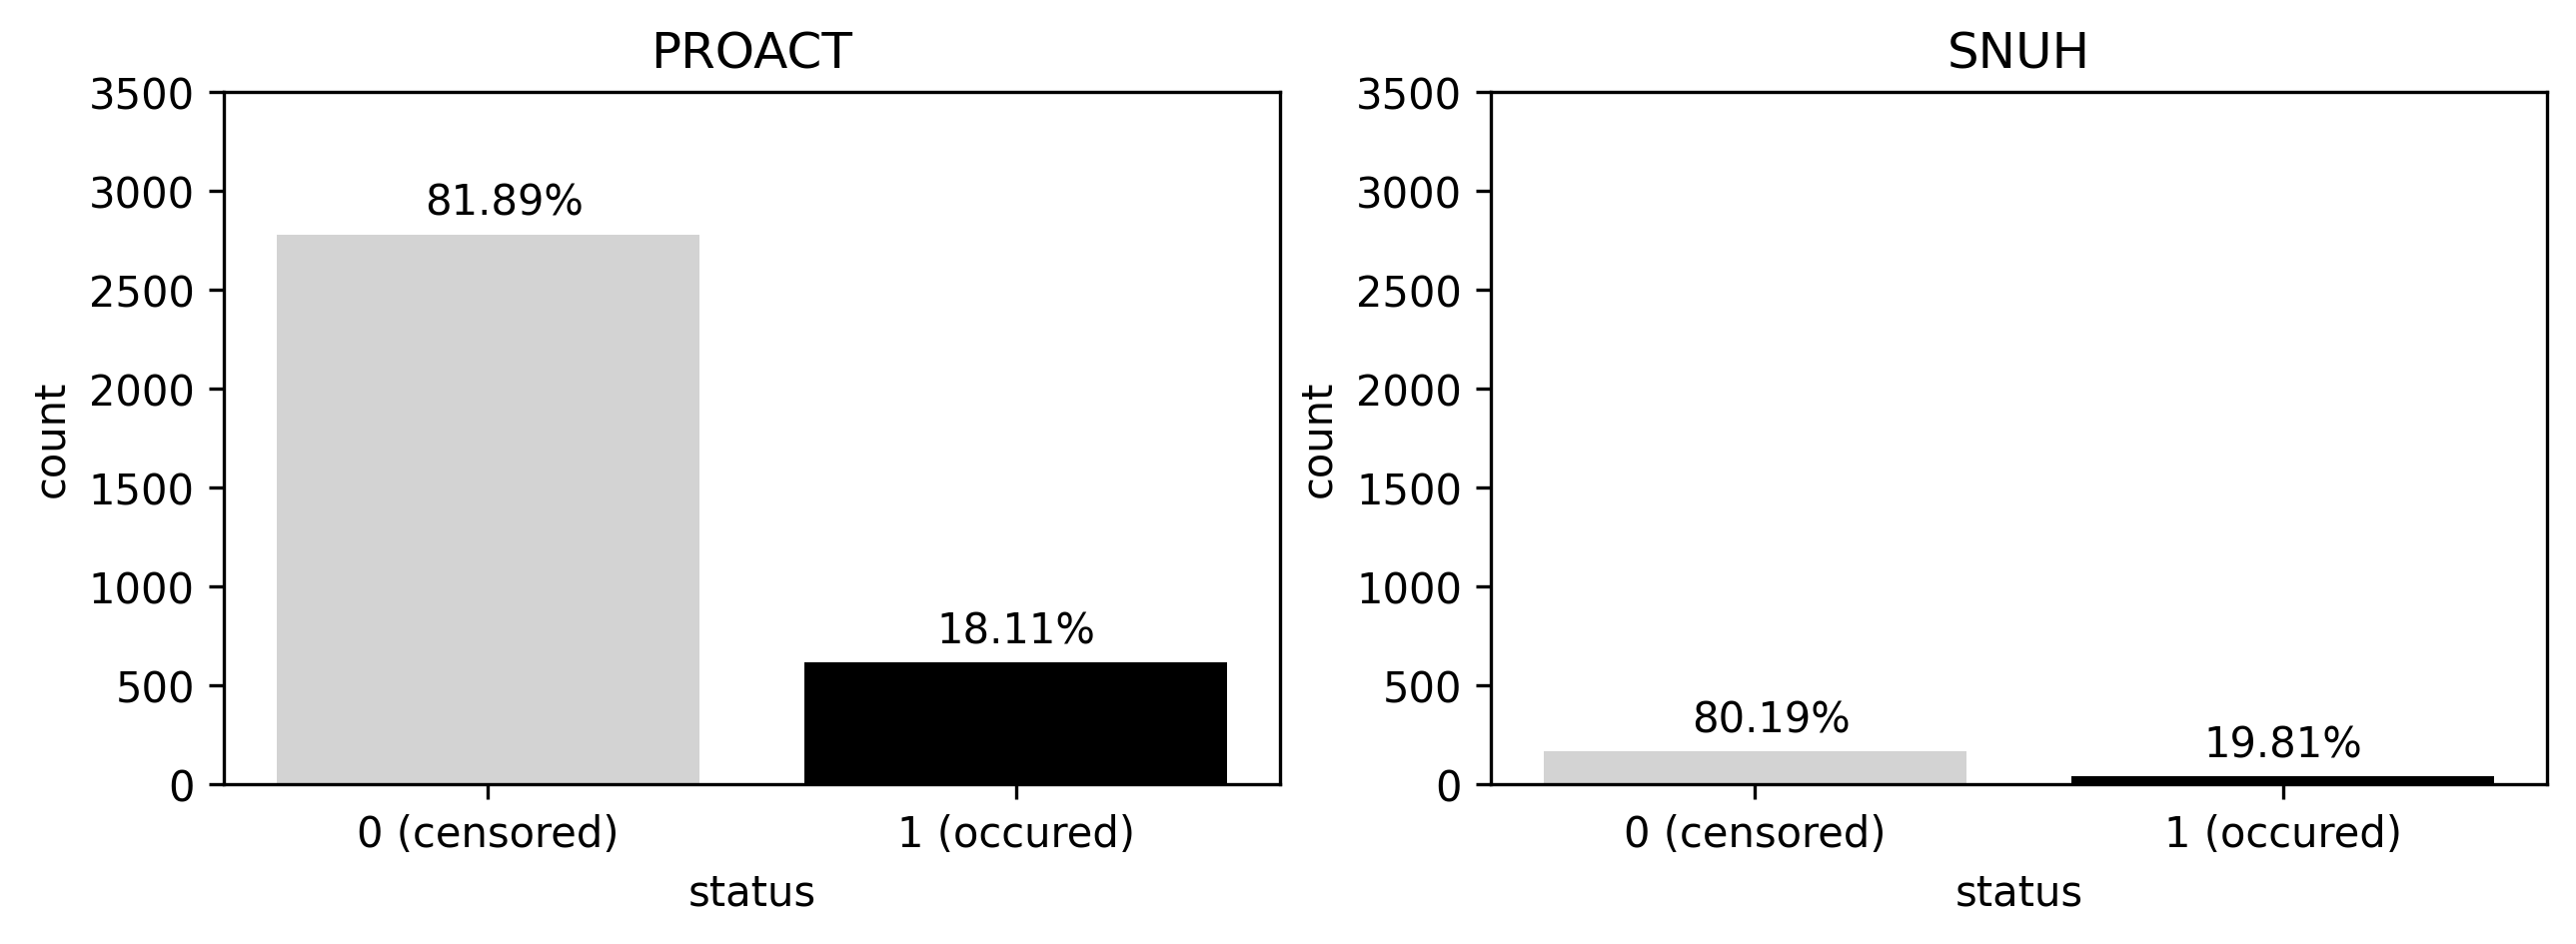

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.barplot (x="status", y='count', data=event_proact, palette = ['#d3d3d3', 'black'])
plt.ylim([0,3500])
plt.text(-0.12, event_proact.iloc[0]['count']+100, str(event_proact.iloc[0]['percent'])+'%')
plt.text(0.85, event_proact.iloc[1]['count']+100, str(event_proact.iloc[1]['percent'])+'%')
plt.title('PROACT')

plt.subplot(1,2,2)
sns.barplot (x="status", y='count', data=event_snuh, palette = ['#d3d3d3', 'black'])
plt.ylim([0,3500])
plt.text(-0.12, event_snuh.iloc[0]['count']+100, str(event_snuh.iloc[0]['percent'])+'%')
plt.text(0.85, event_snuh.iloc[1]['count']+100, str(event_snuh.iloc[1]['percent'])+'%')
plt.title('SNUH')

# 4. KM curve on target event

In [ ]:
pip install lifelines

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

(0.0, 1.0)

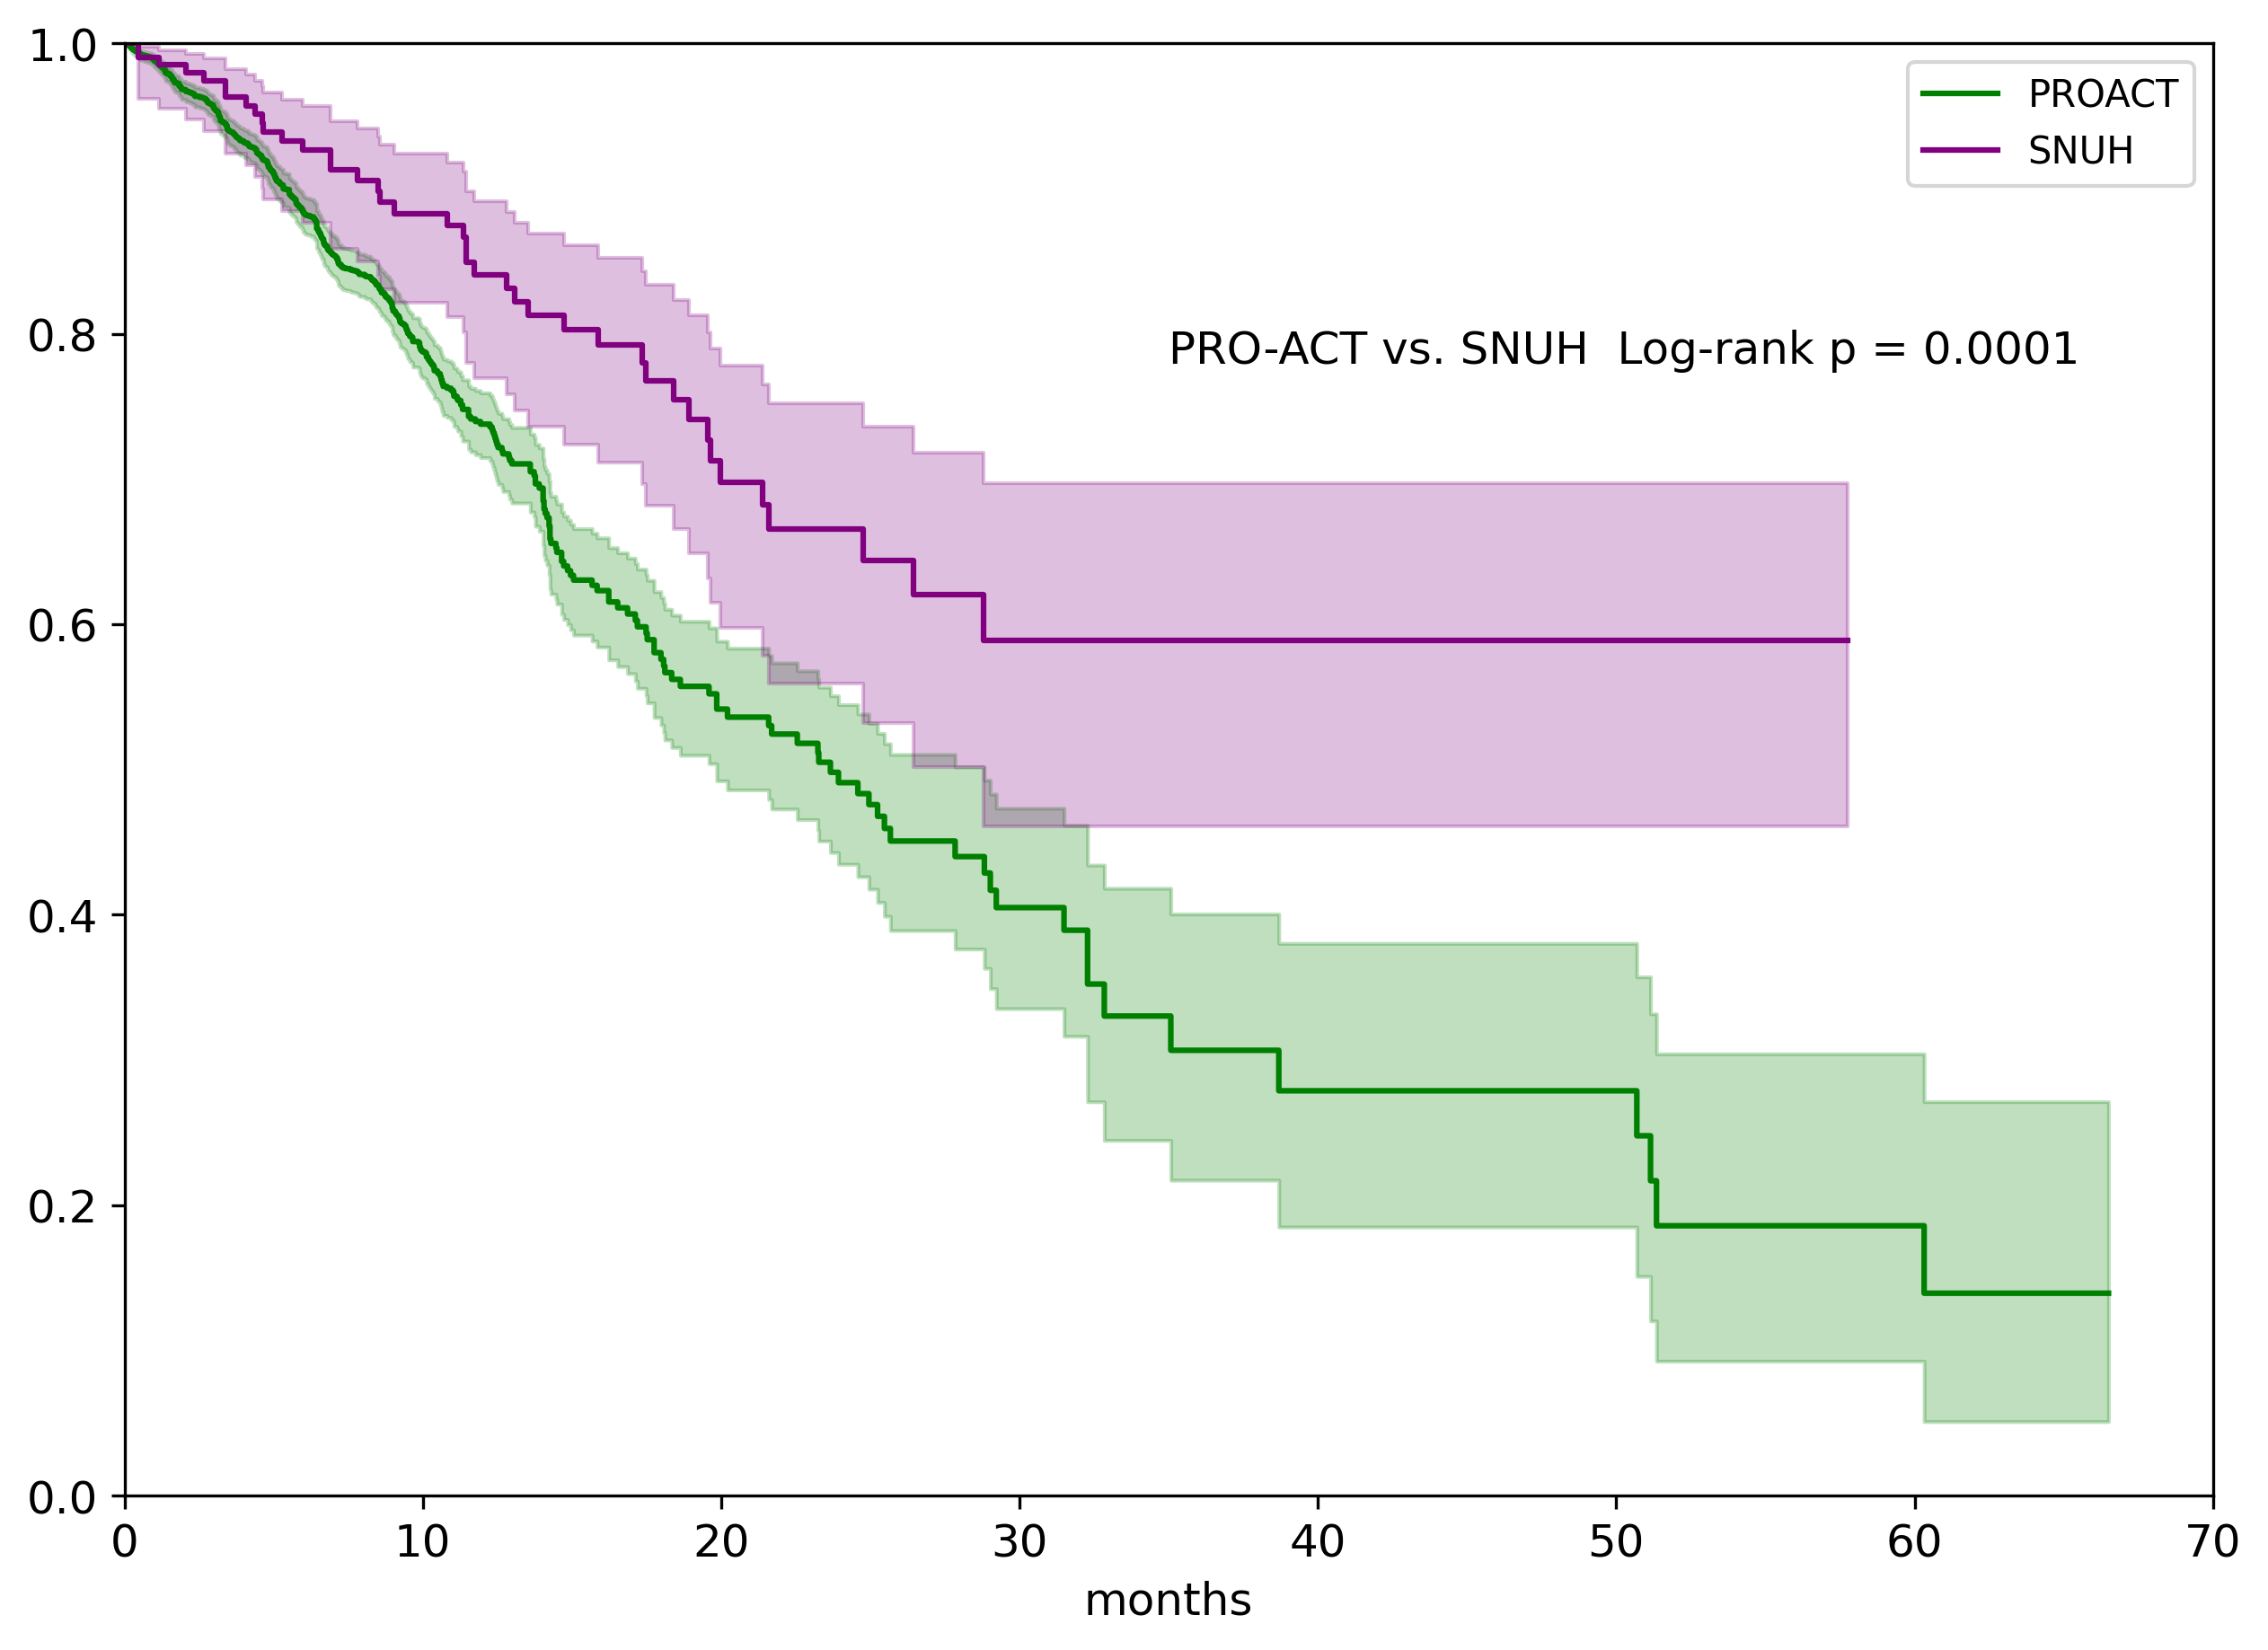

In [ ]:
kmf1 = KaplanMeierFitter()
kmf1.fit(proact_full['time_LOA'], event_observed=proact_full['status_LOA'], label='PROACT')

kmf2 = KaplanMeierFitter()
kmf2.fit(snuh_full['time_LOA'], event_observed=snuh_full['status_LOA'], label='SNUH')

# Calculate log-rank test p-value
log_rank_result = logrank_test(proact_full['time_LOA'], snuh_full['time_LOA'], proact_full['status_LOA'], snuh_full['status_LOA'])


# Plot the Kaplan-Meier curves
plt.figure(figsize=(10,7))
ax_kmf = kmf1.plot(color = 'green')
ax_kmf2 = kmf2.plot(color = 'purple')

plt.annotate(f'PRO-ACT vs. SNUH  Log-rank p = {log_rank_result.p_value:.4f}', xy=(35, 0.78), color='k', fontsize=12)

plt.xlabel('months',fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,70])
plt.ylim([0,1])


# 5. Feature value distribution

# 5-1. Histogram

In [ ]:
def compare_feature_distribution_proact_snuh(feature):
  fig = plt.figure(figsize=(10, 3))

  plt.subplot(121)
  plt.title('PROACT')
  sns.histplot(x=proact_feature[feature], color = 'w')

  plt.subplot(122)
  plt.title('SNUH')
  sns.histplot(x=snuh_feature[feature], color = 'w')
  plt.show()

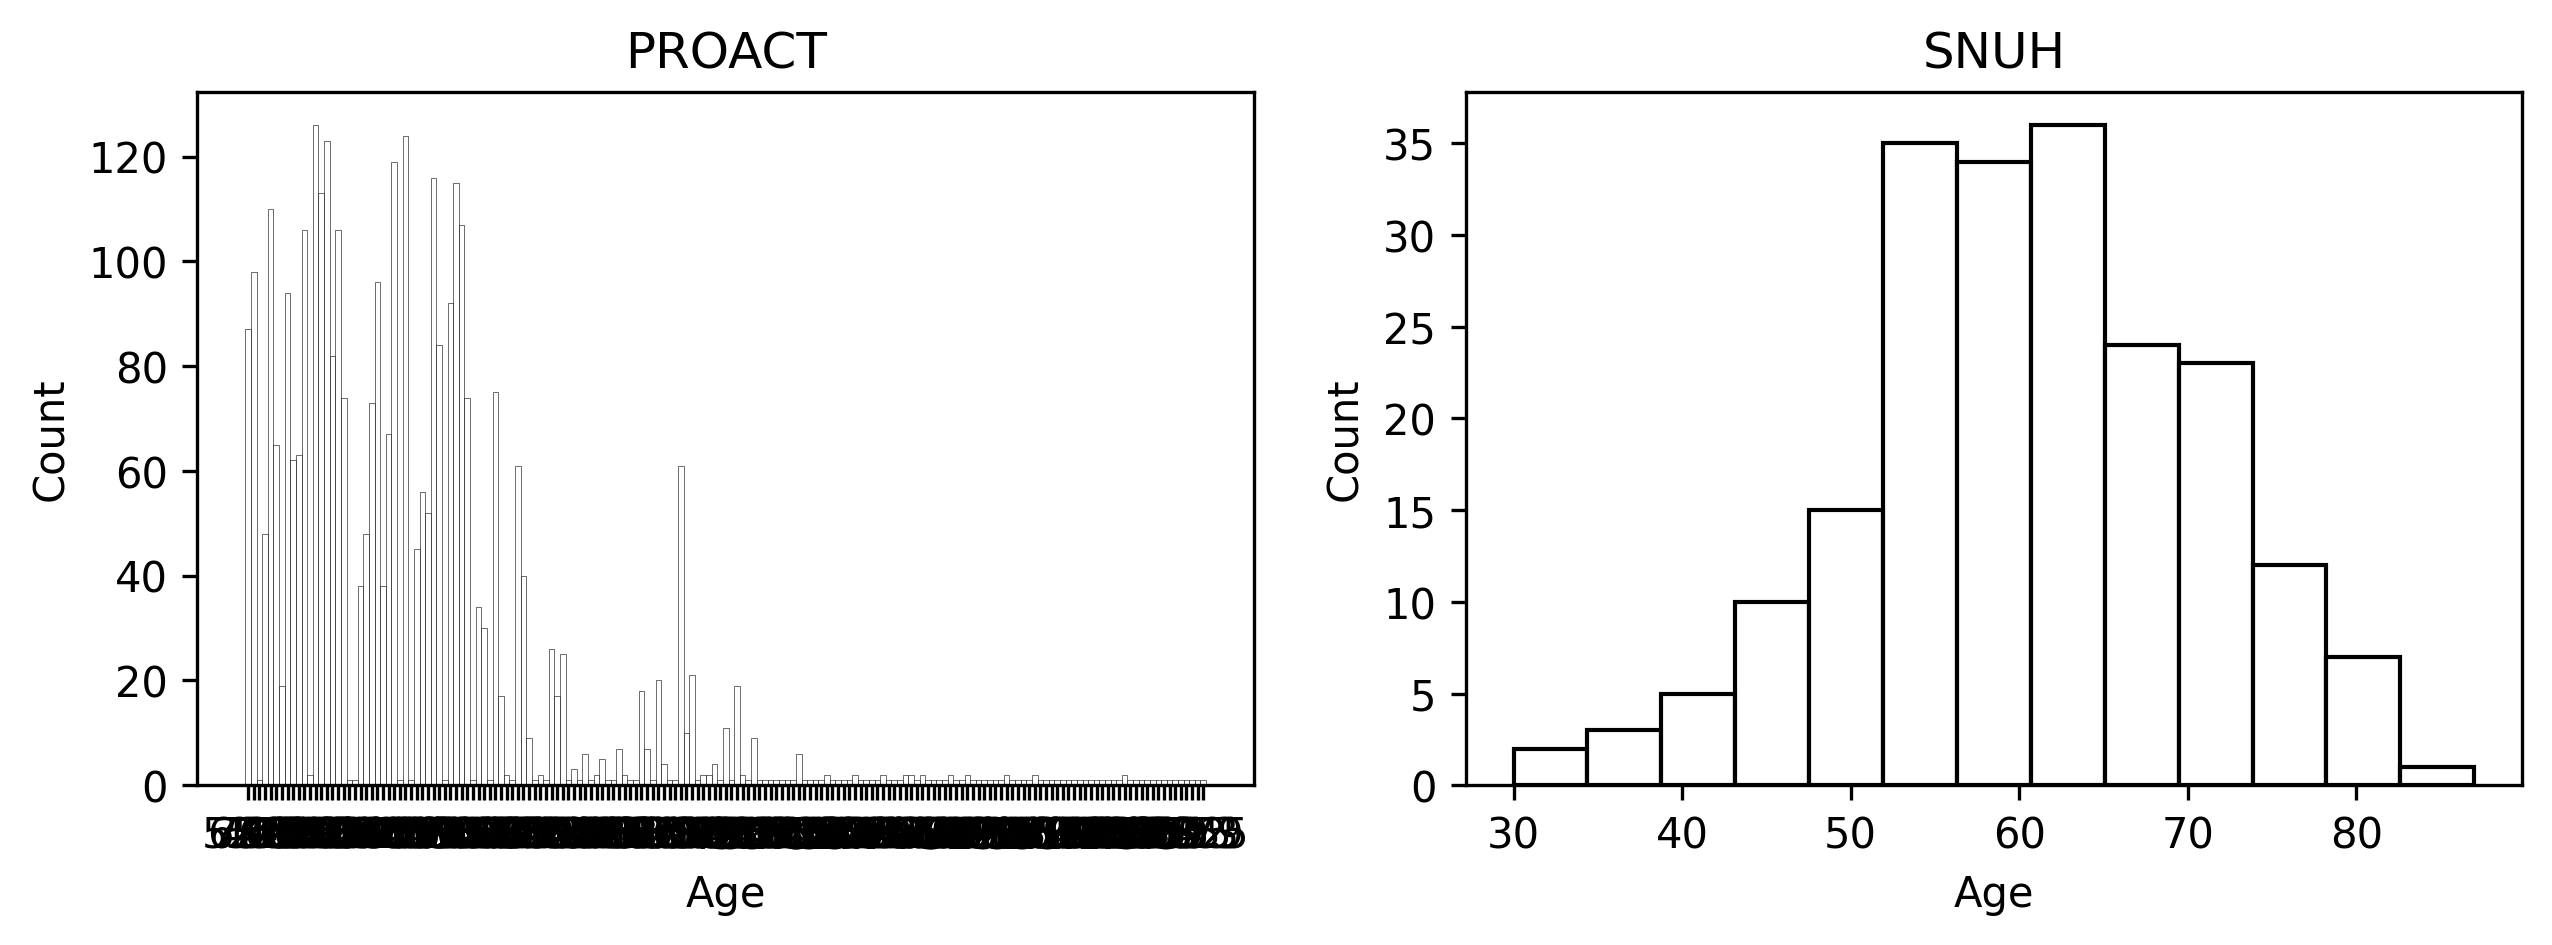

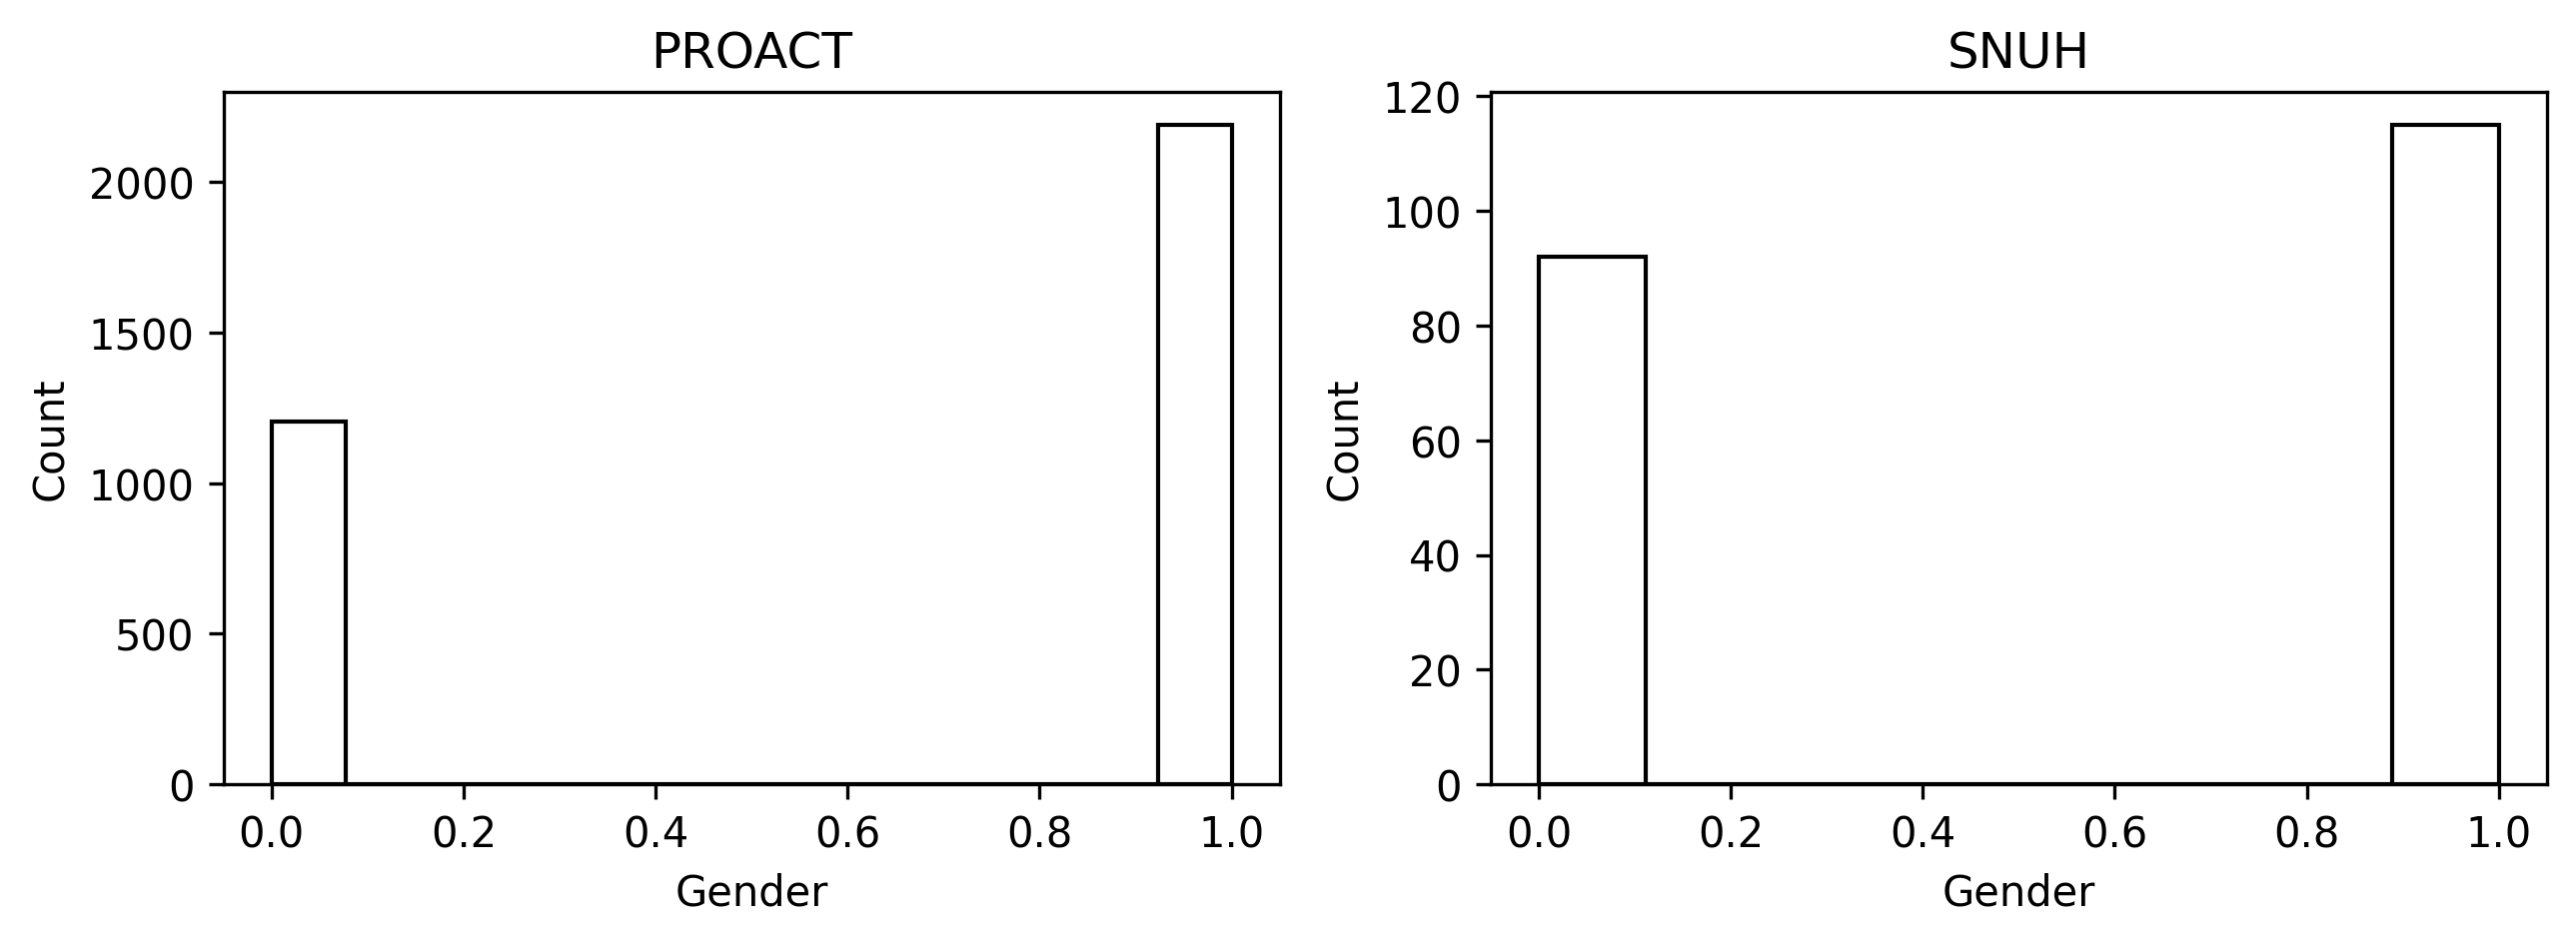

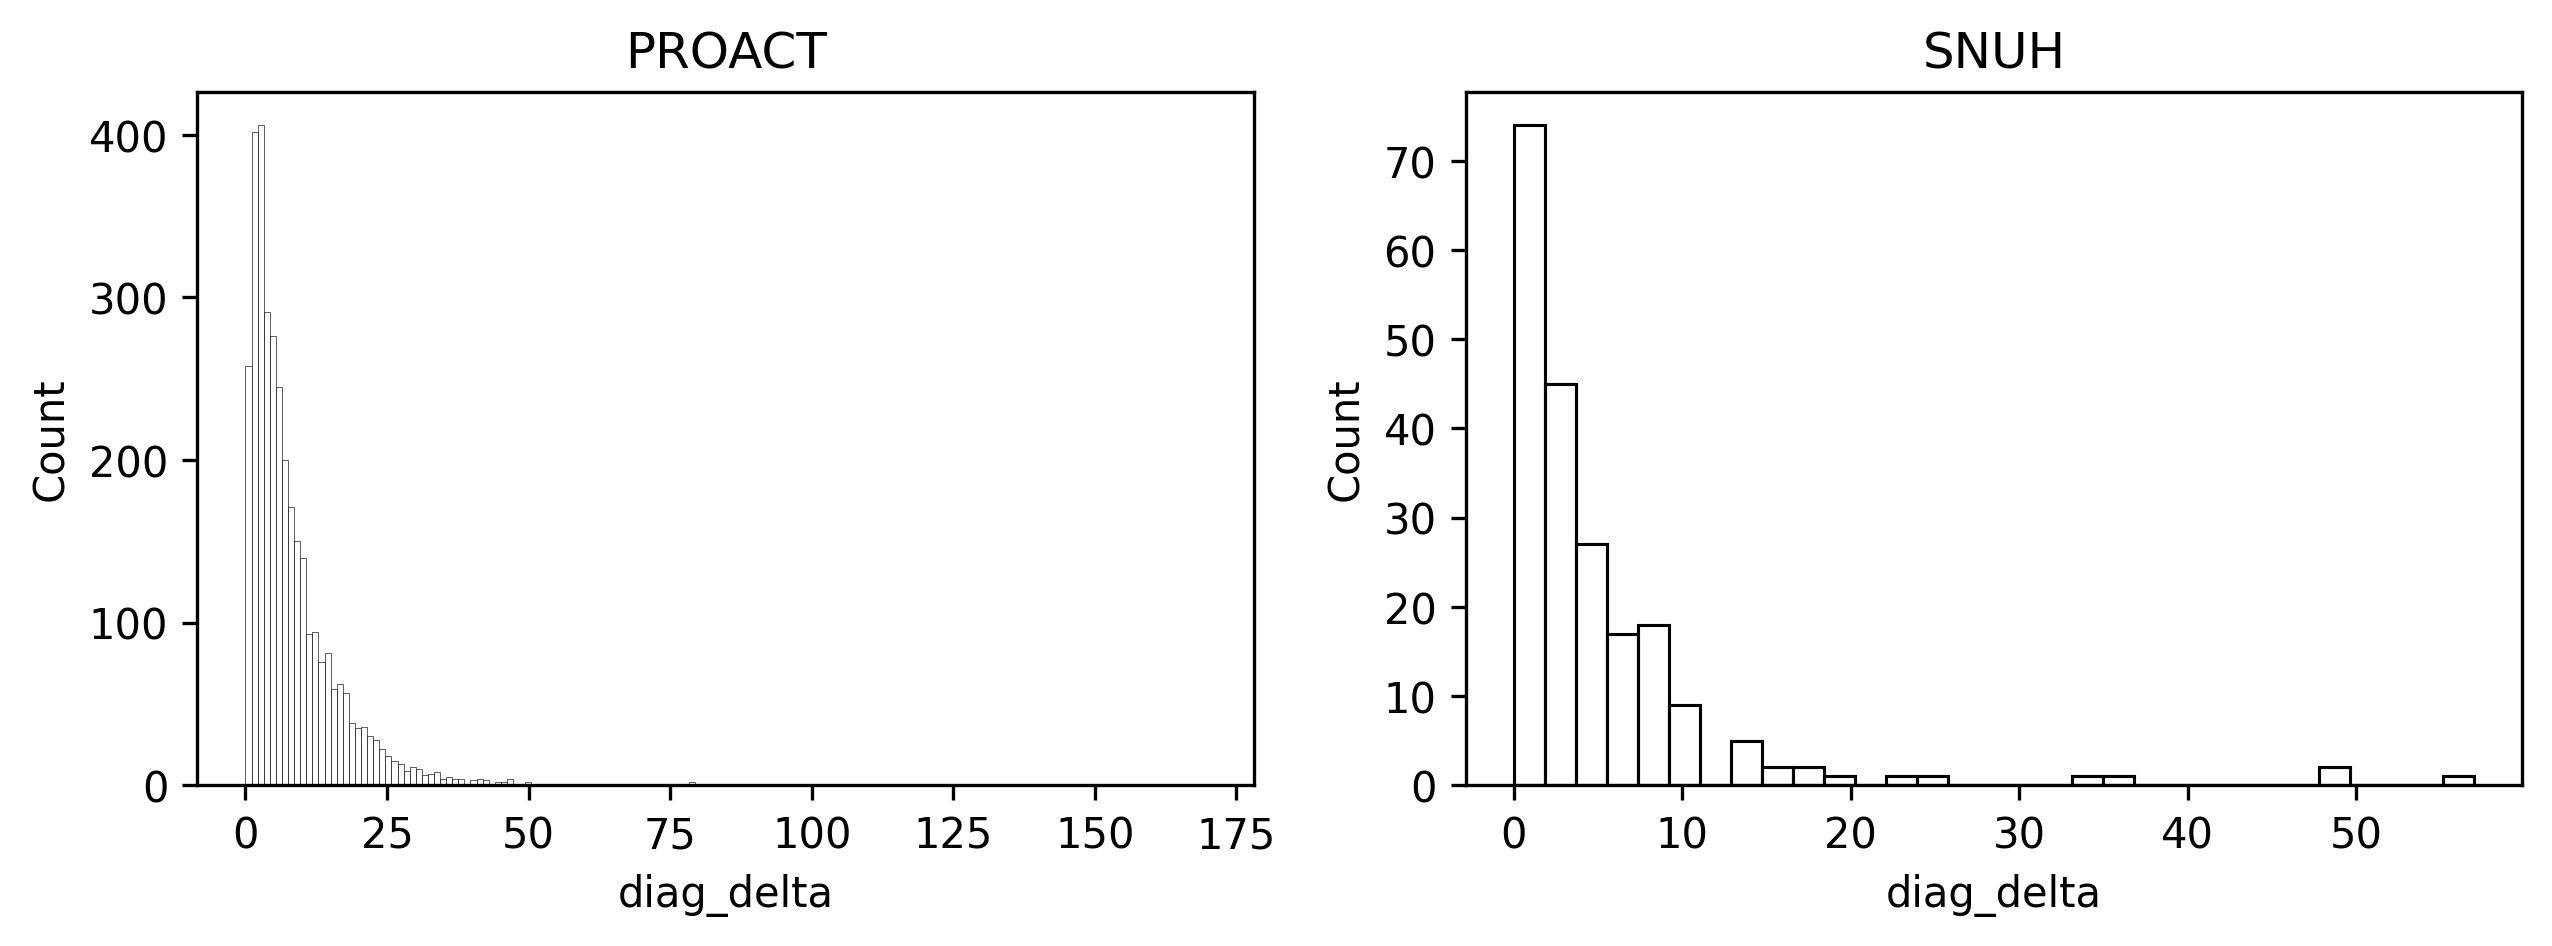

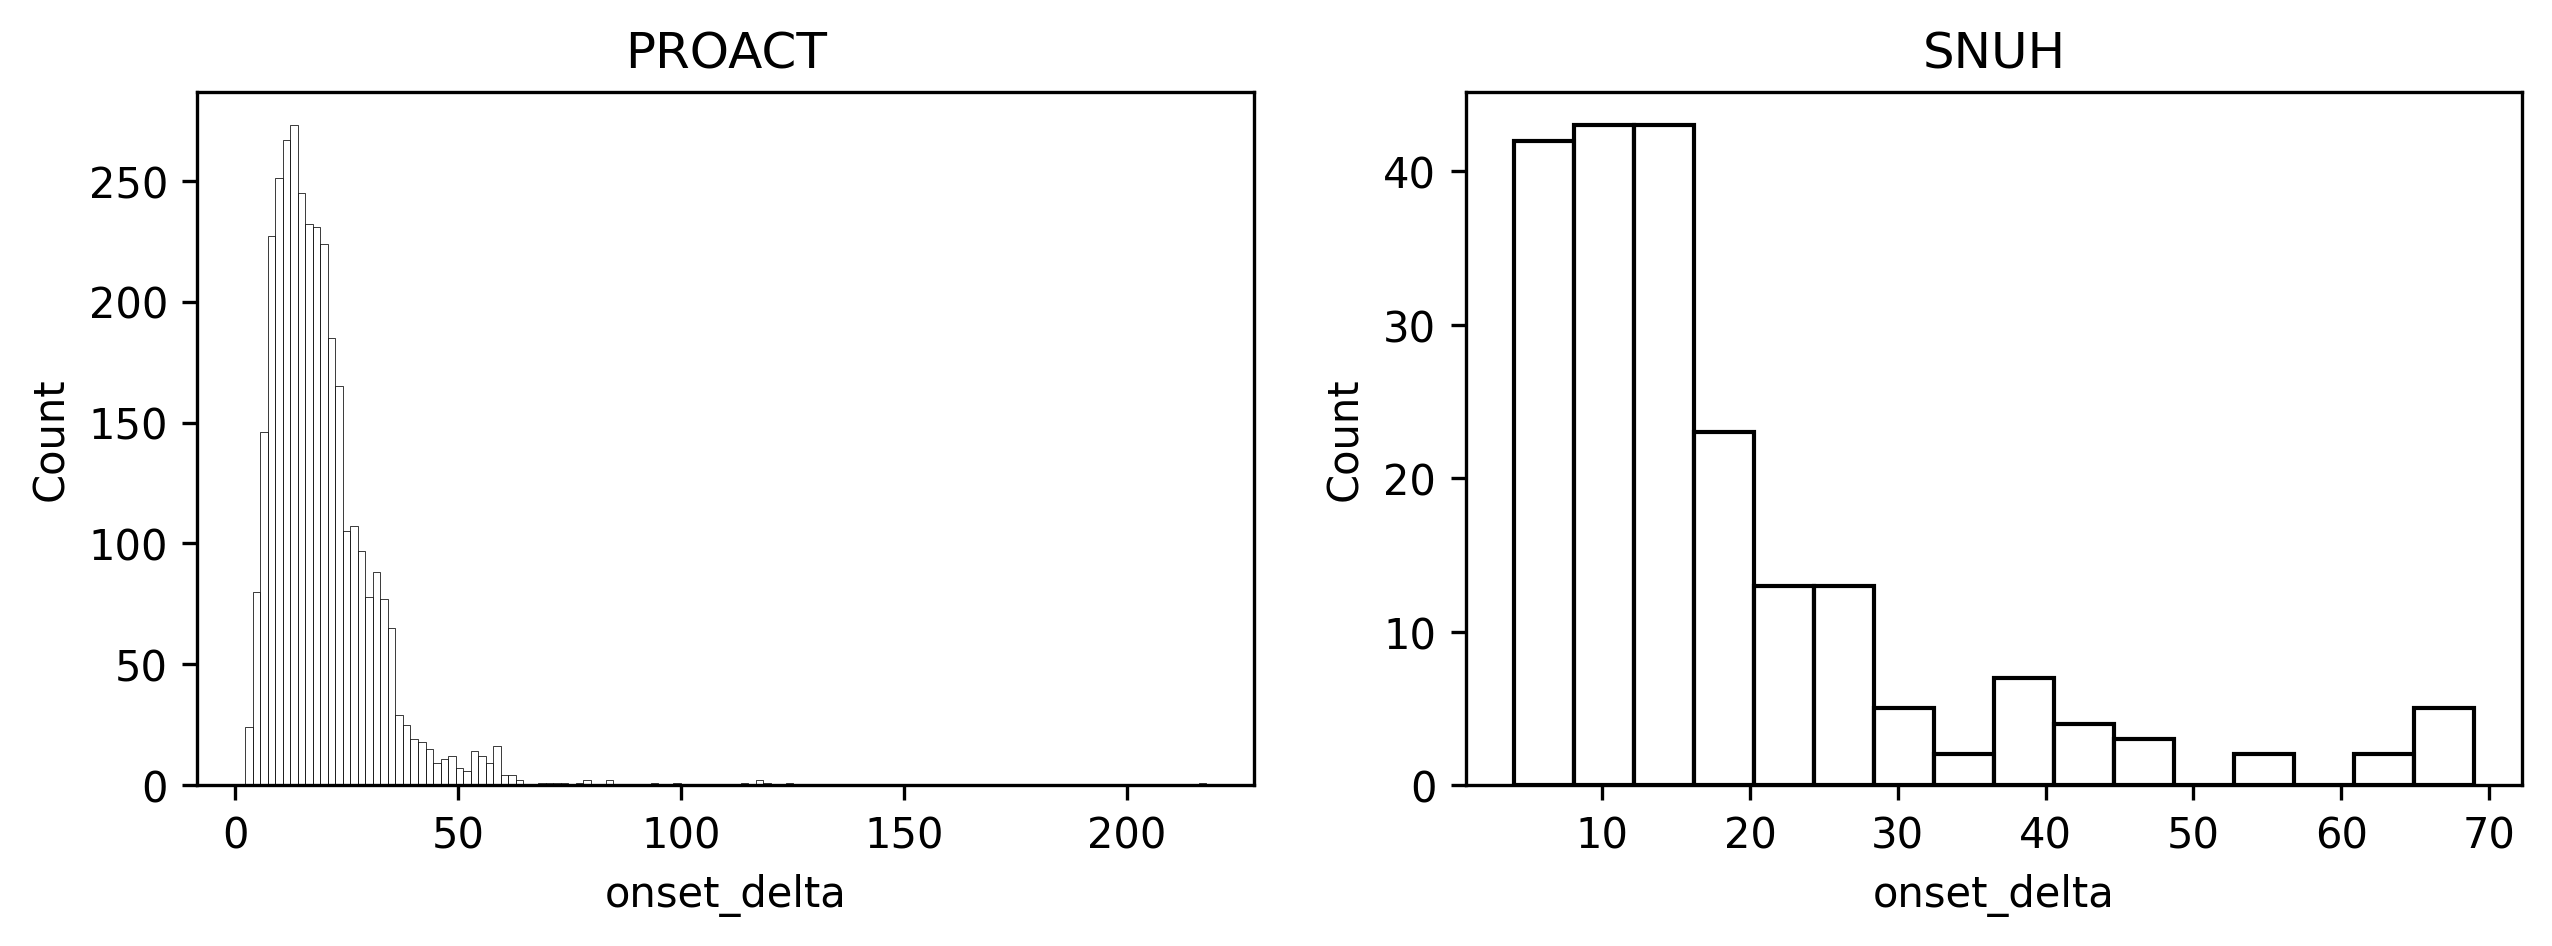

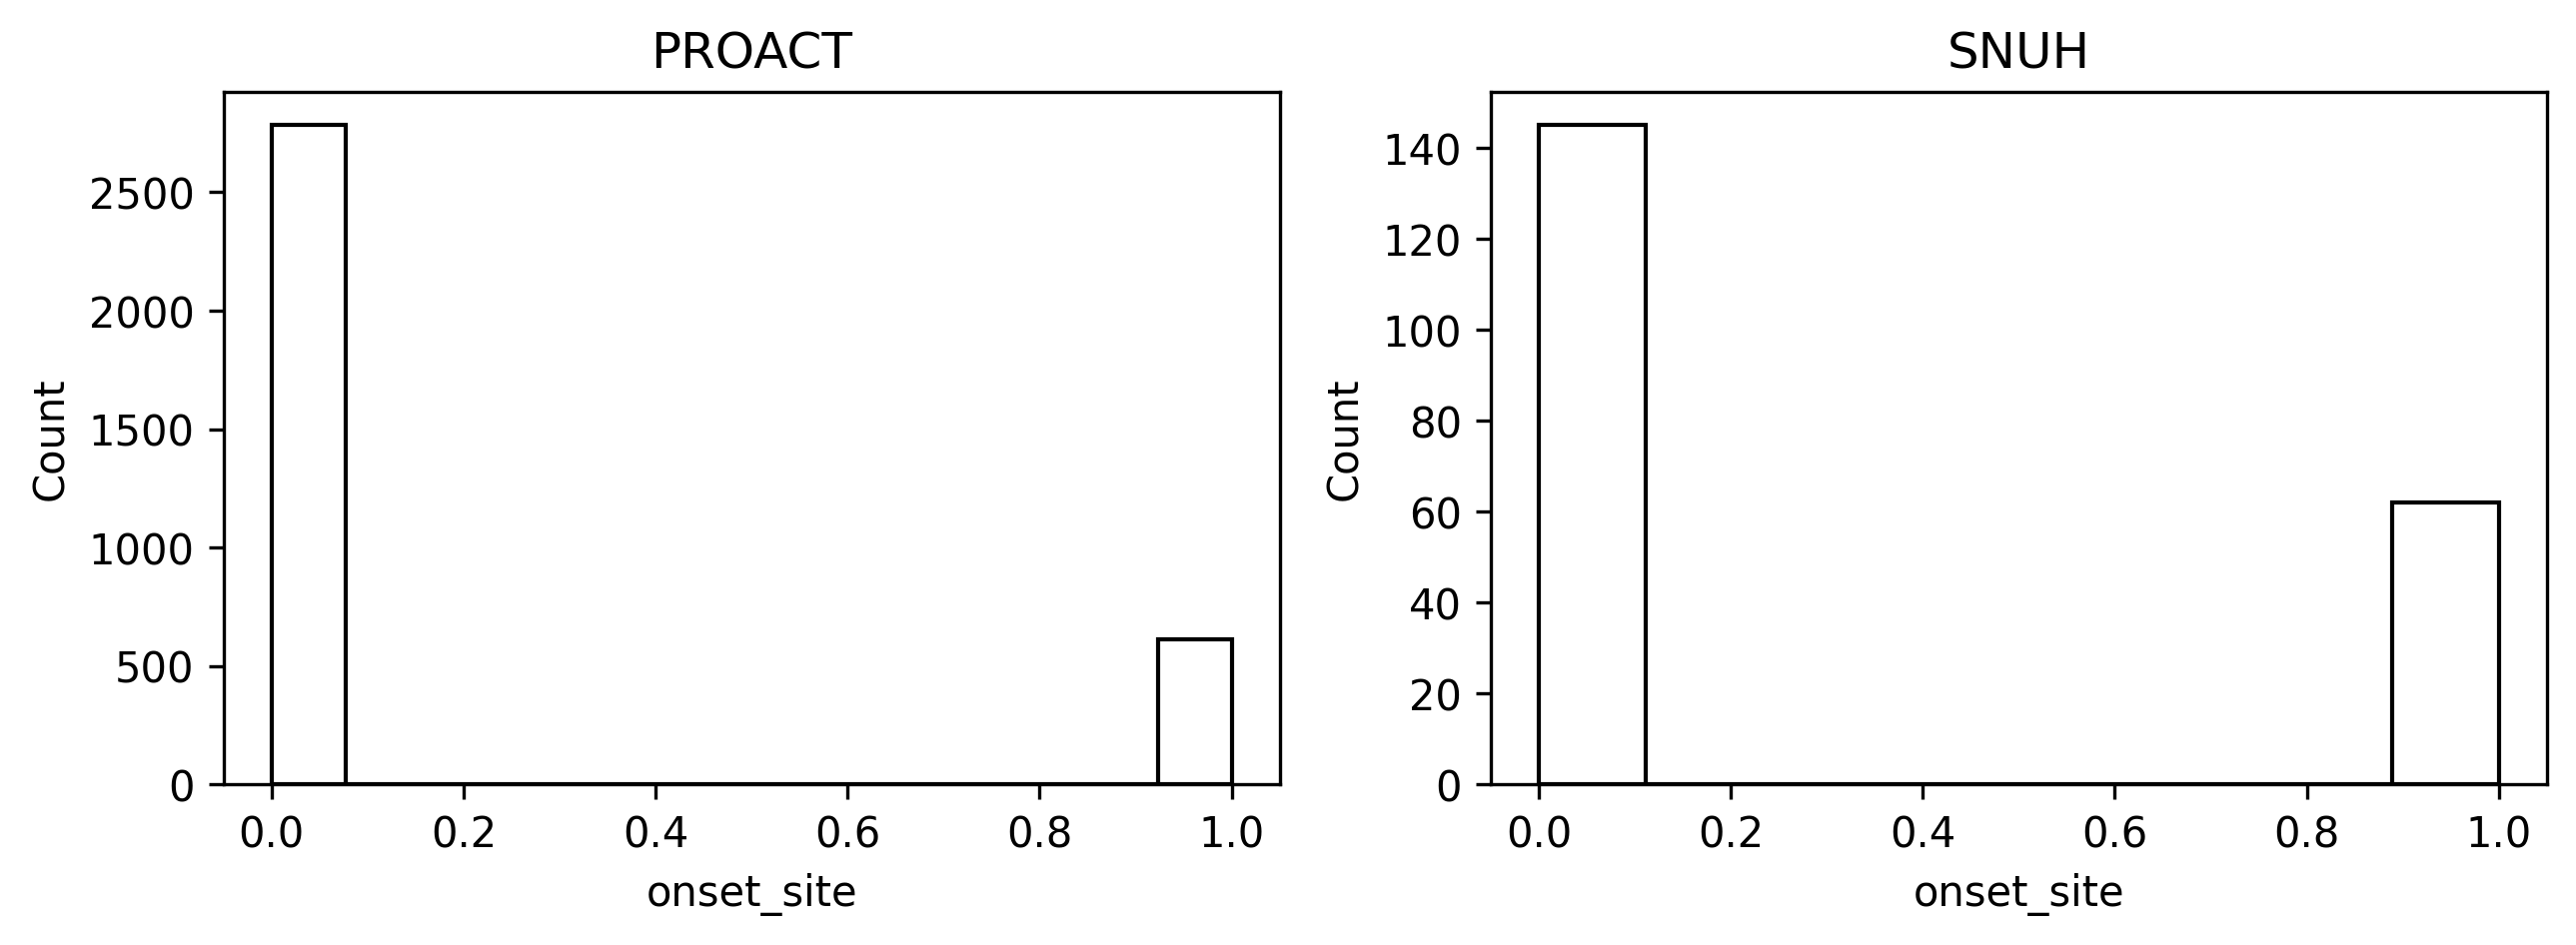

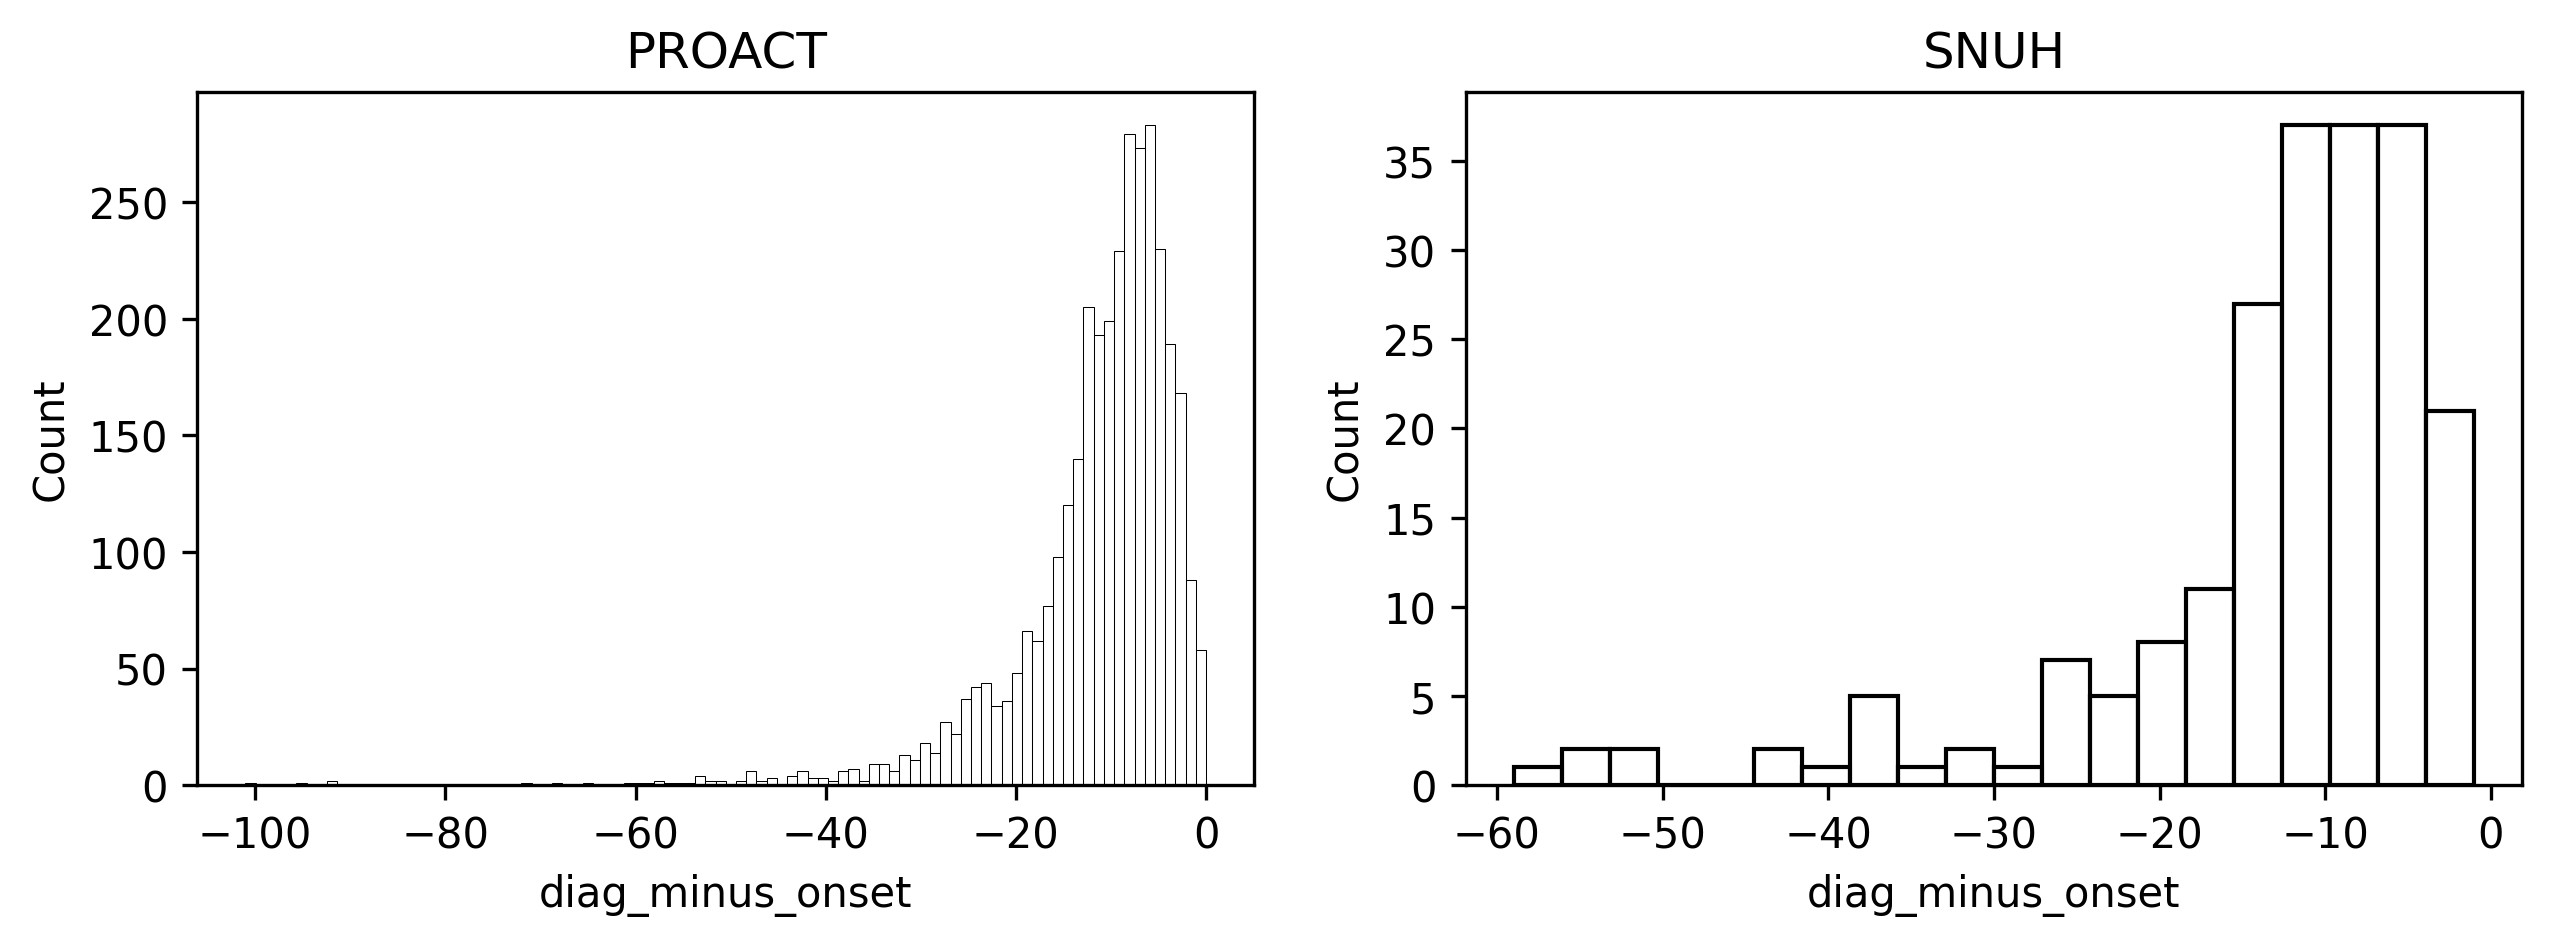

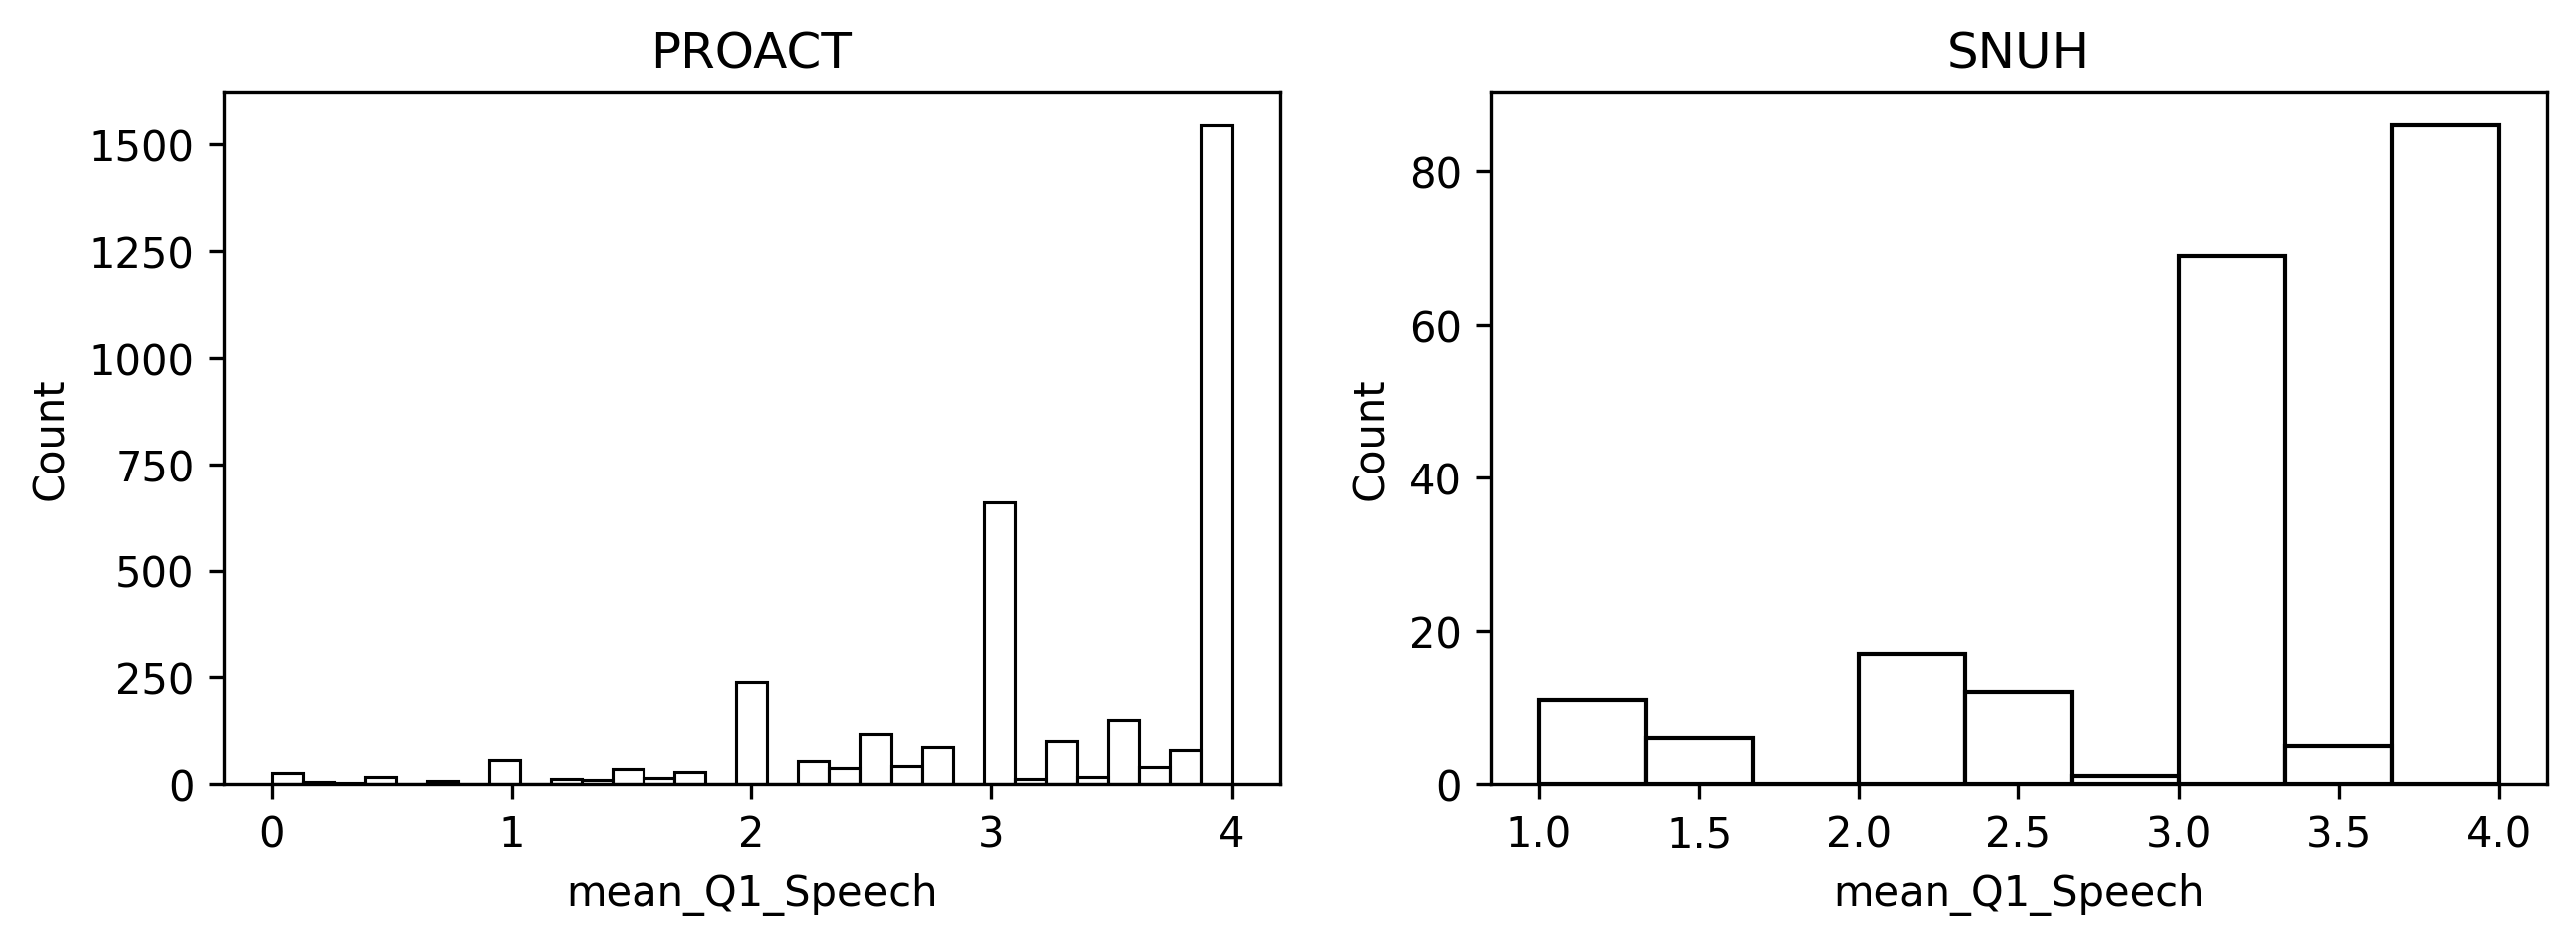

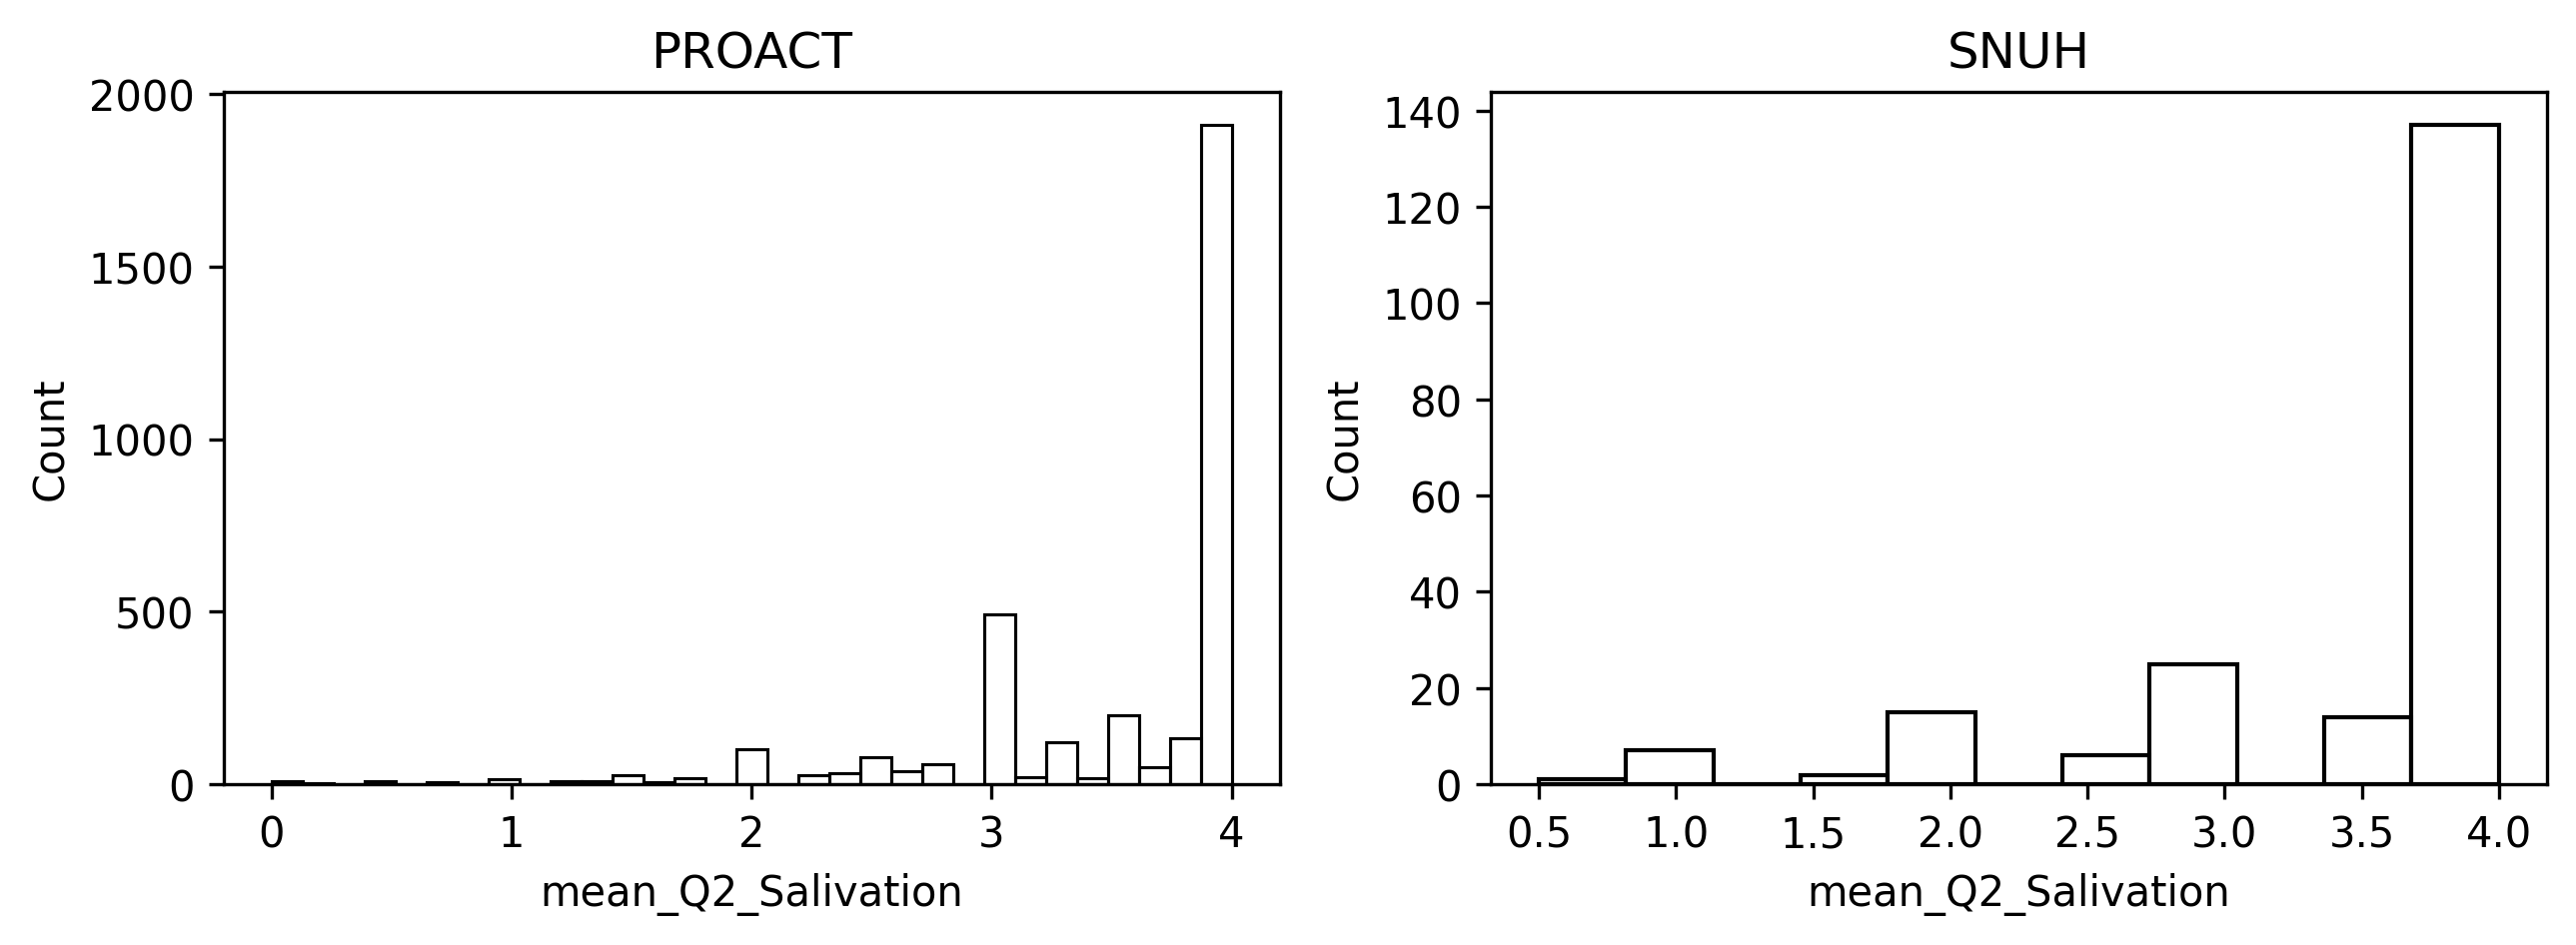

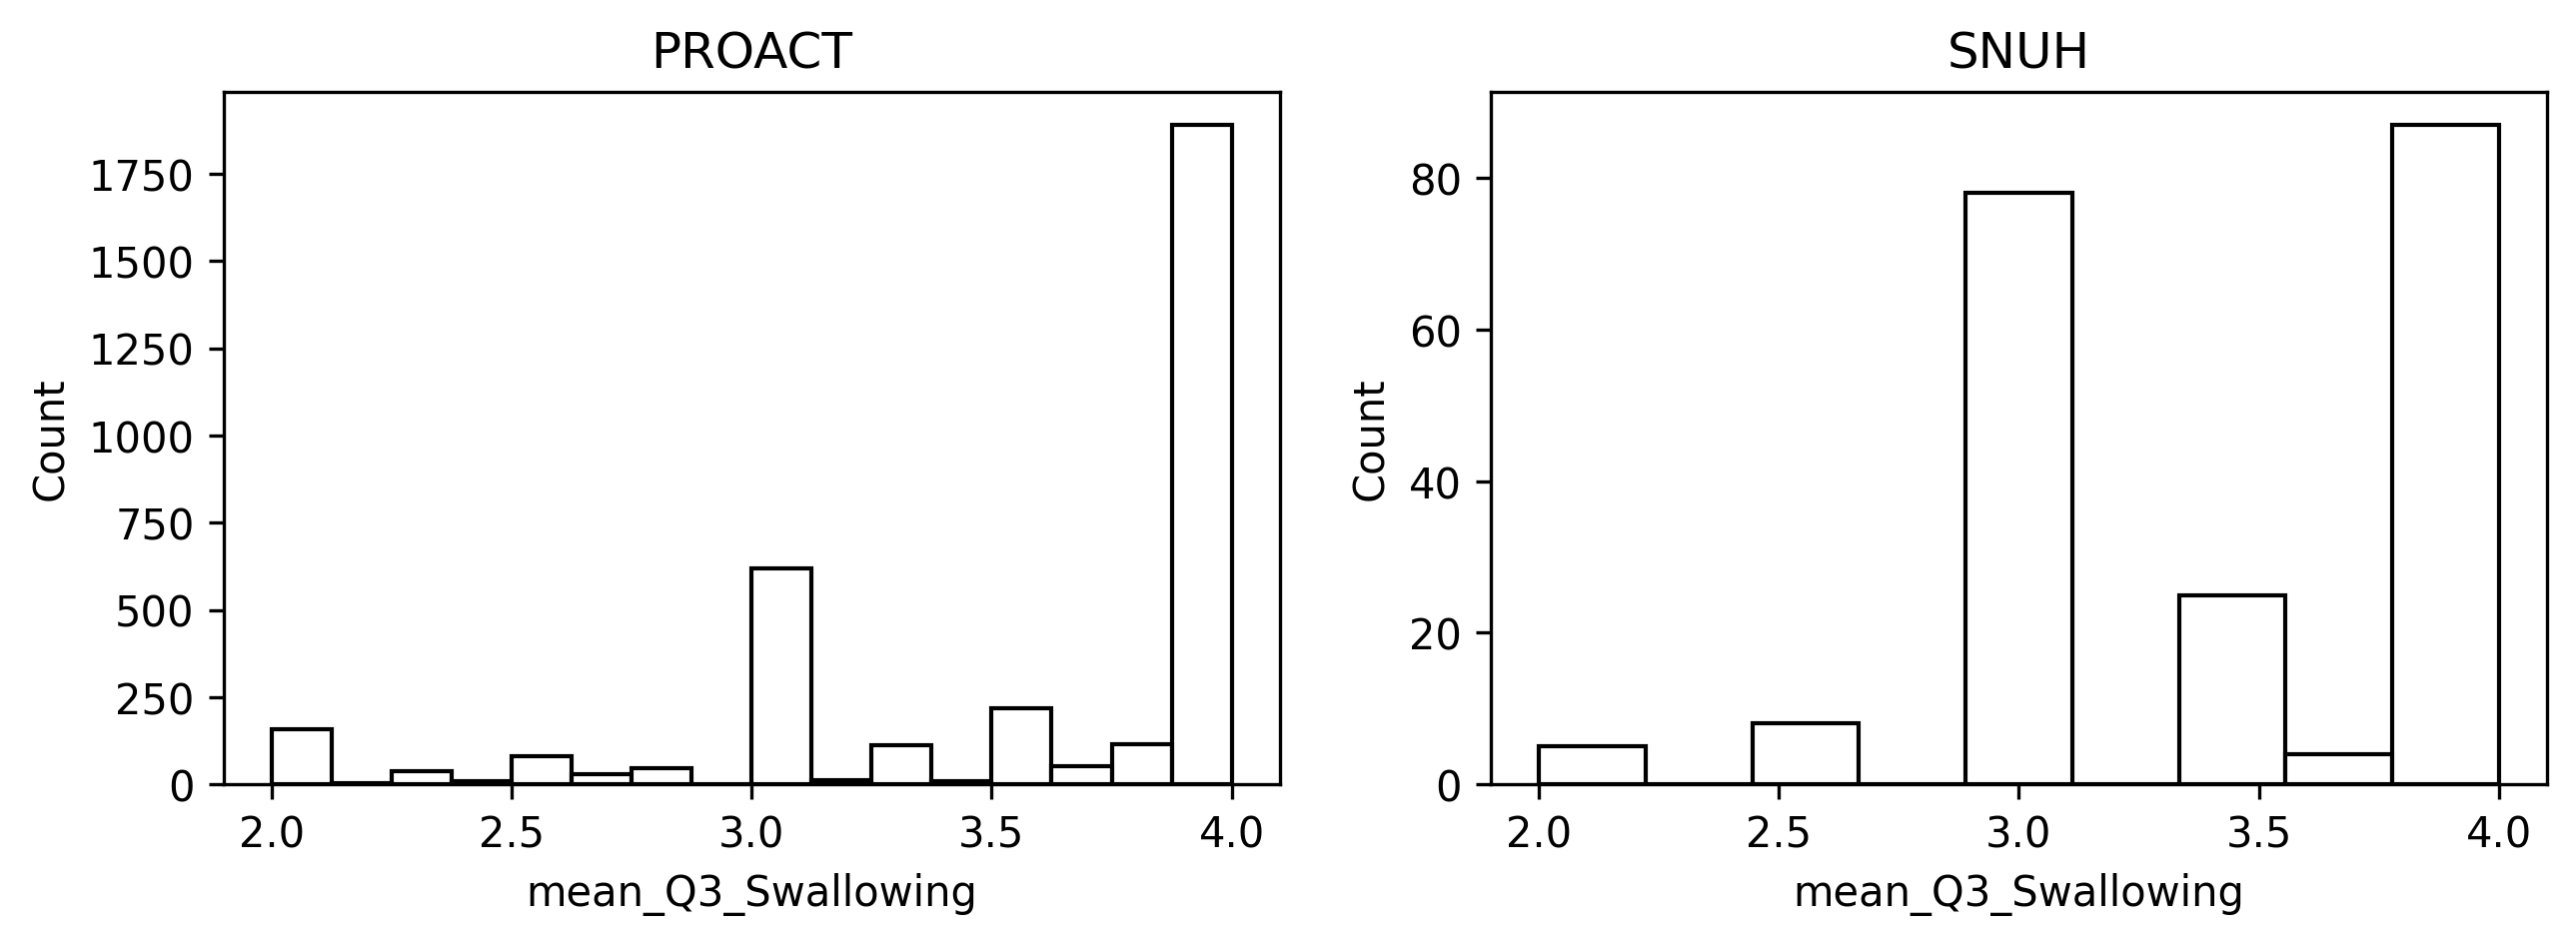

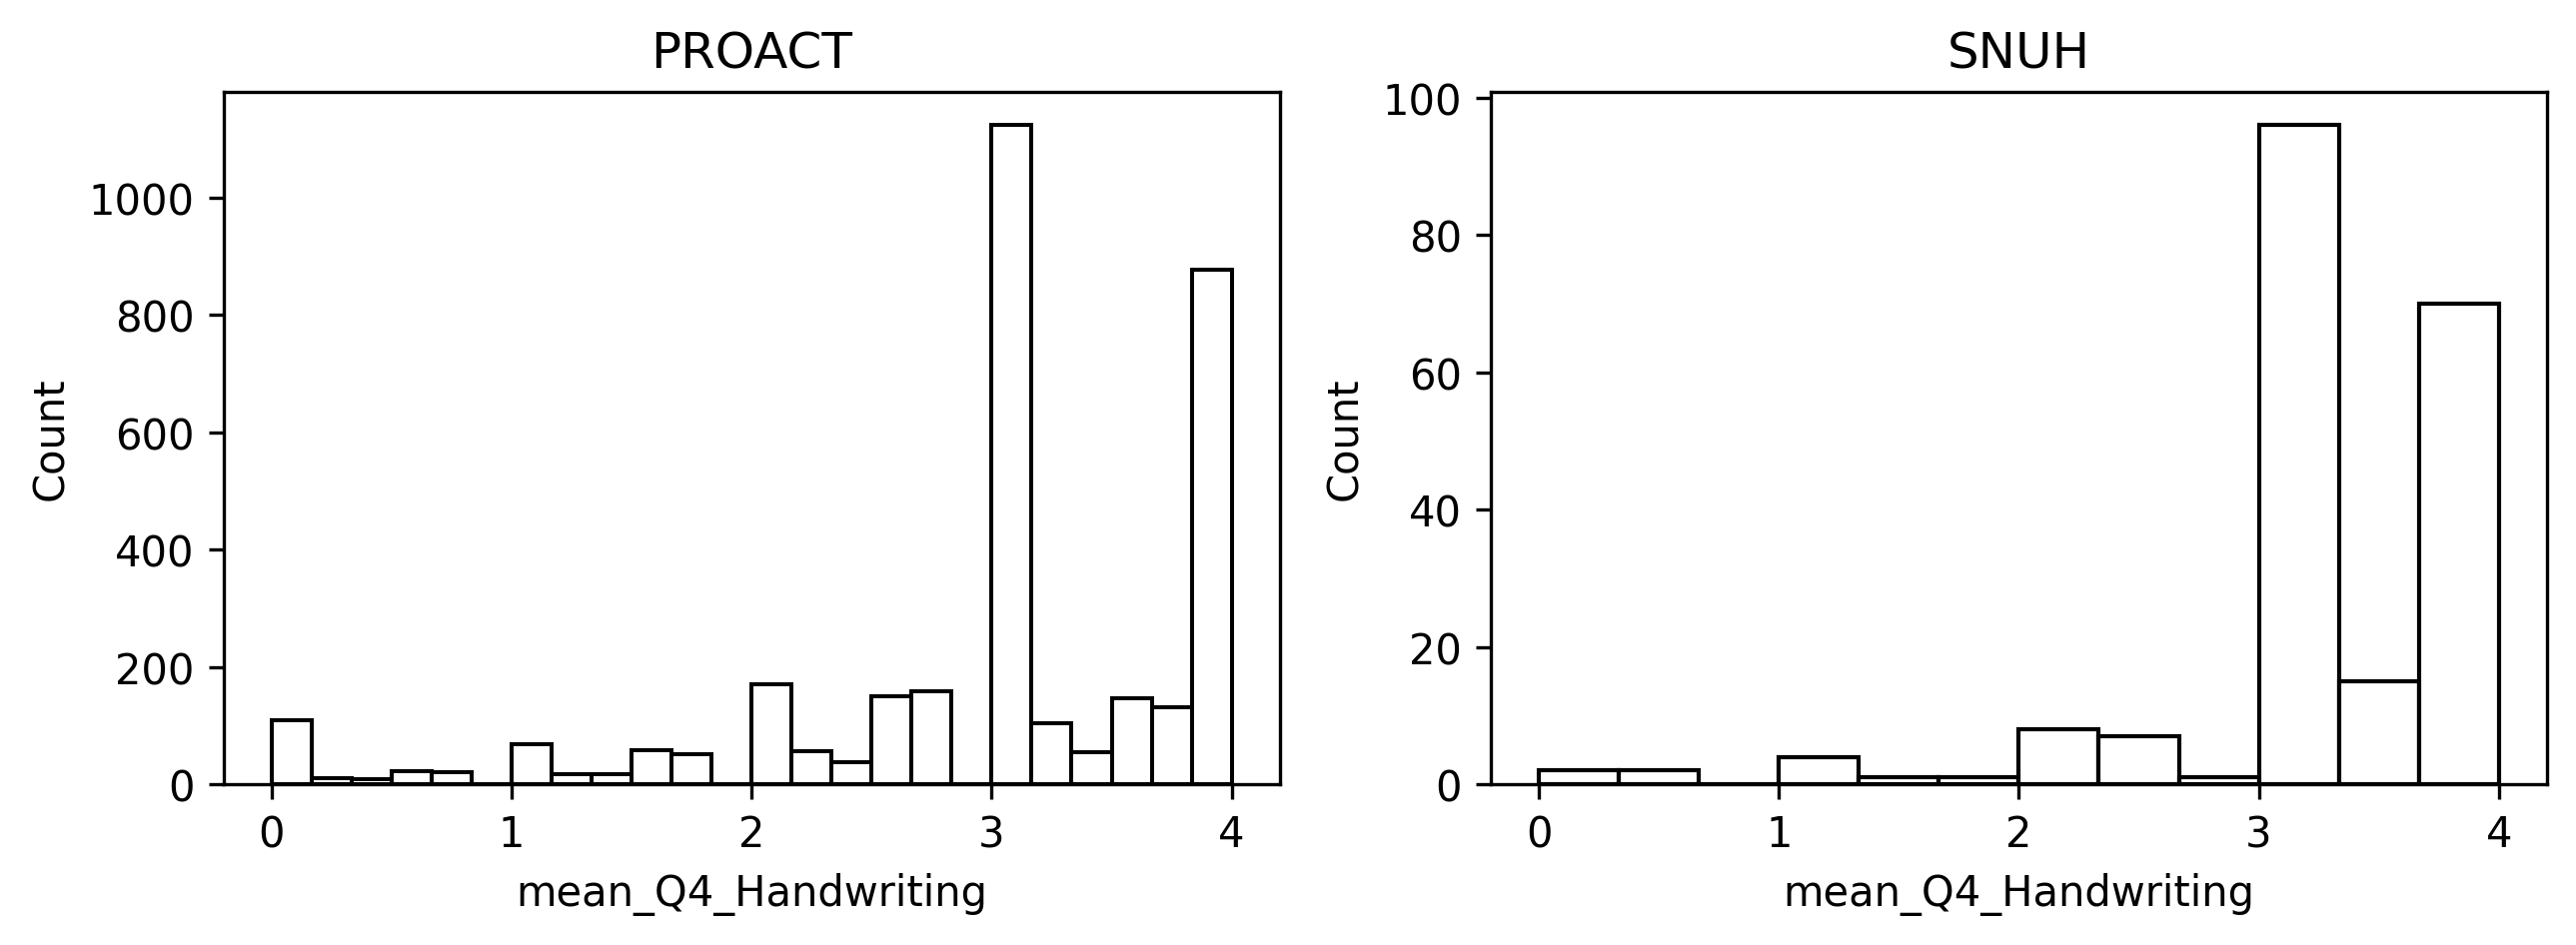

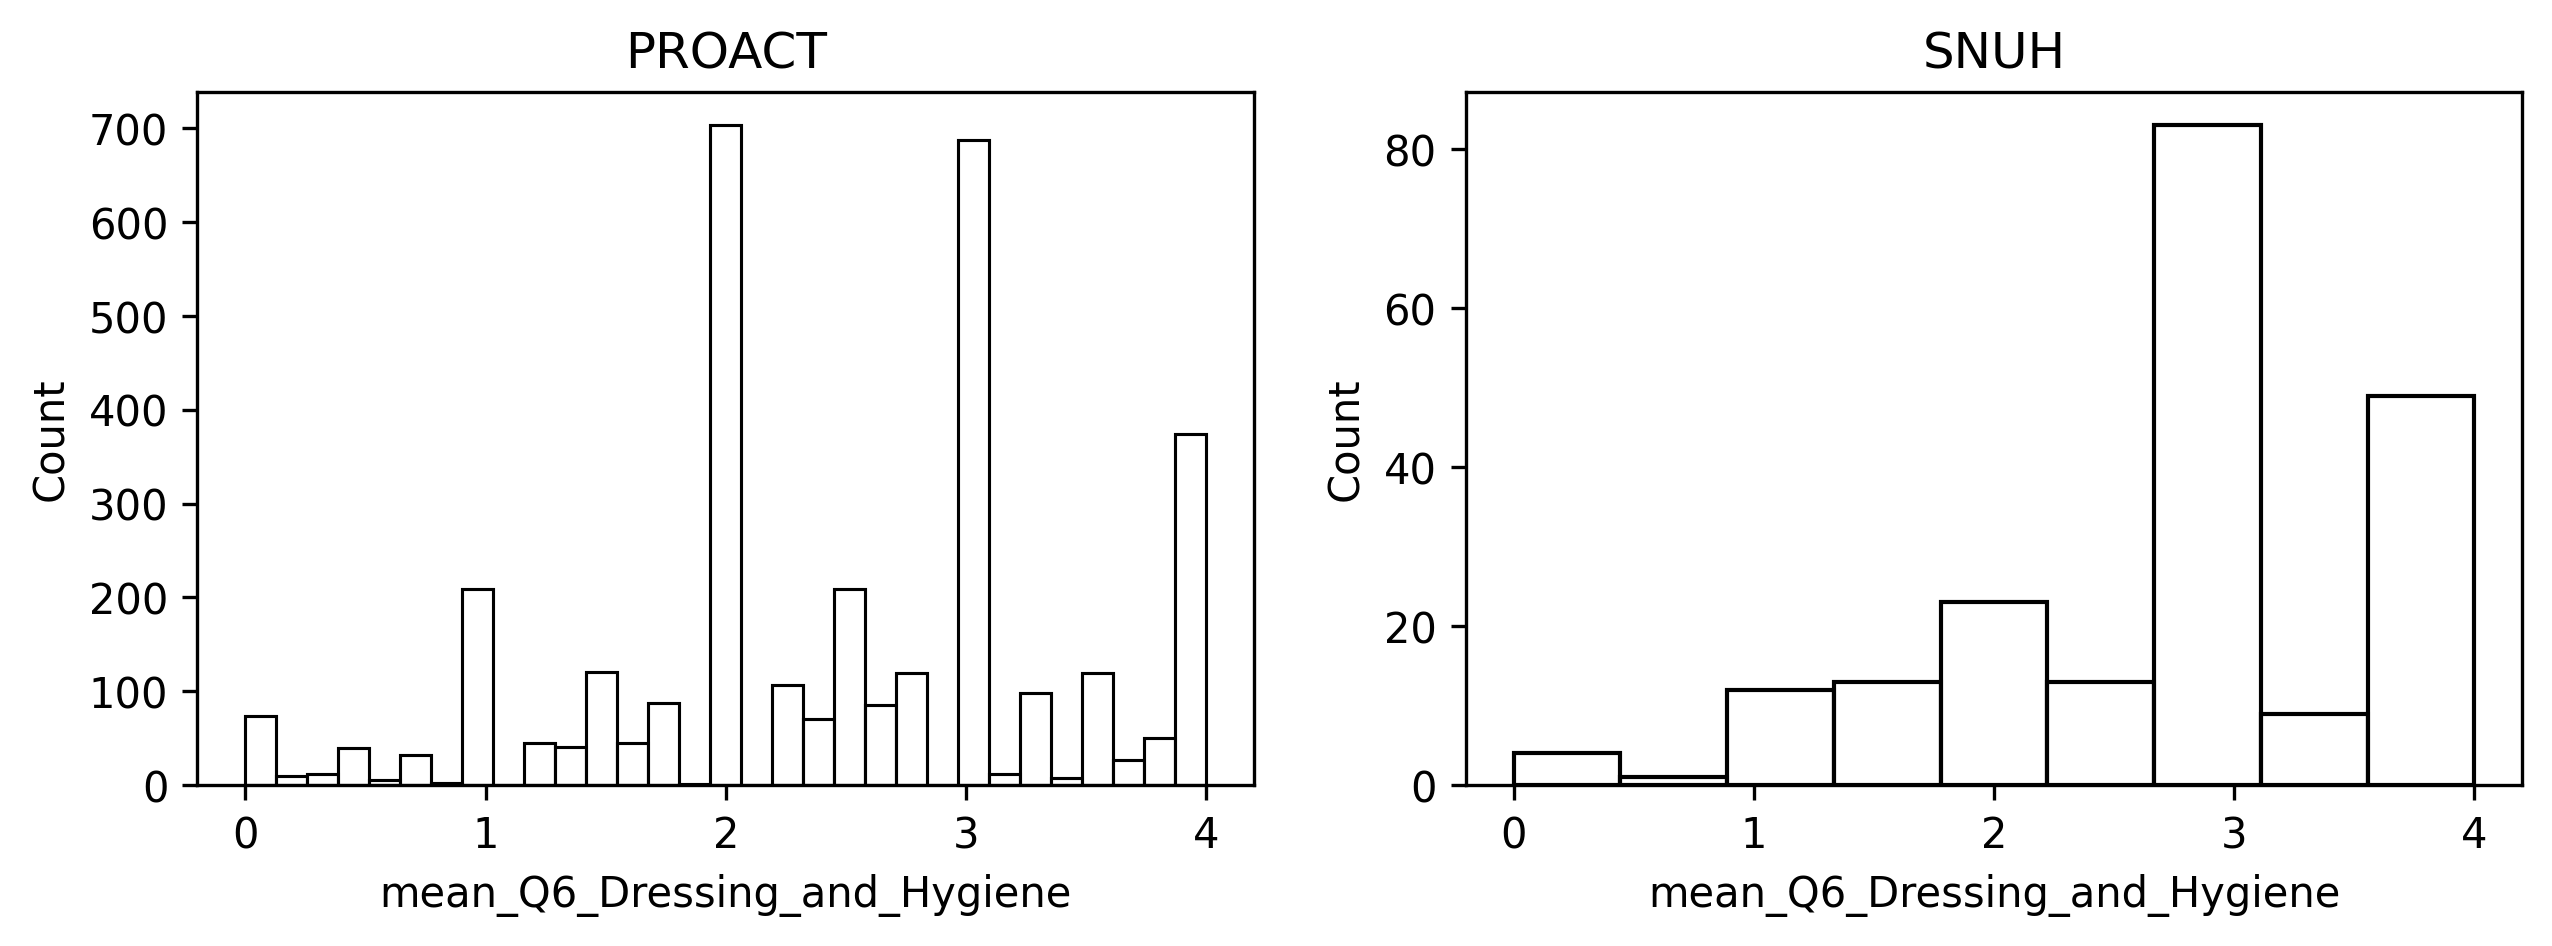

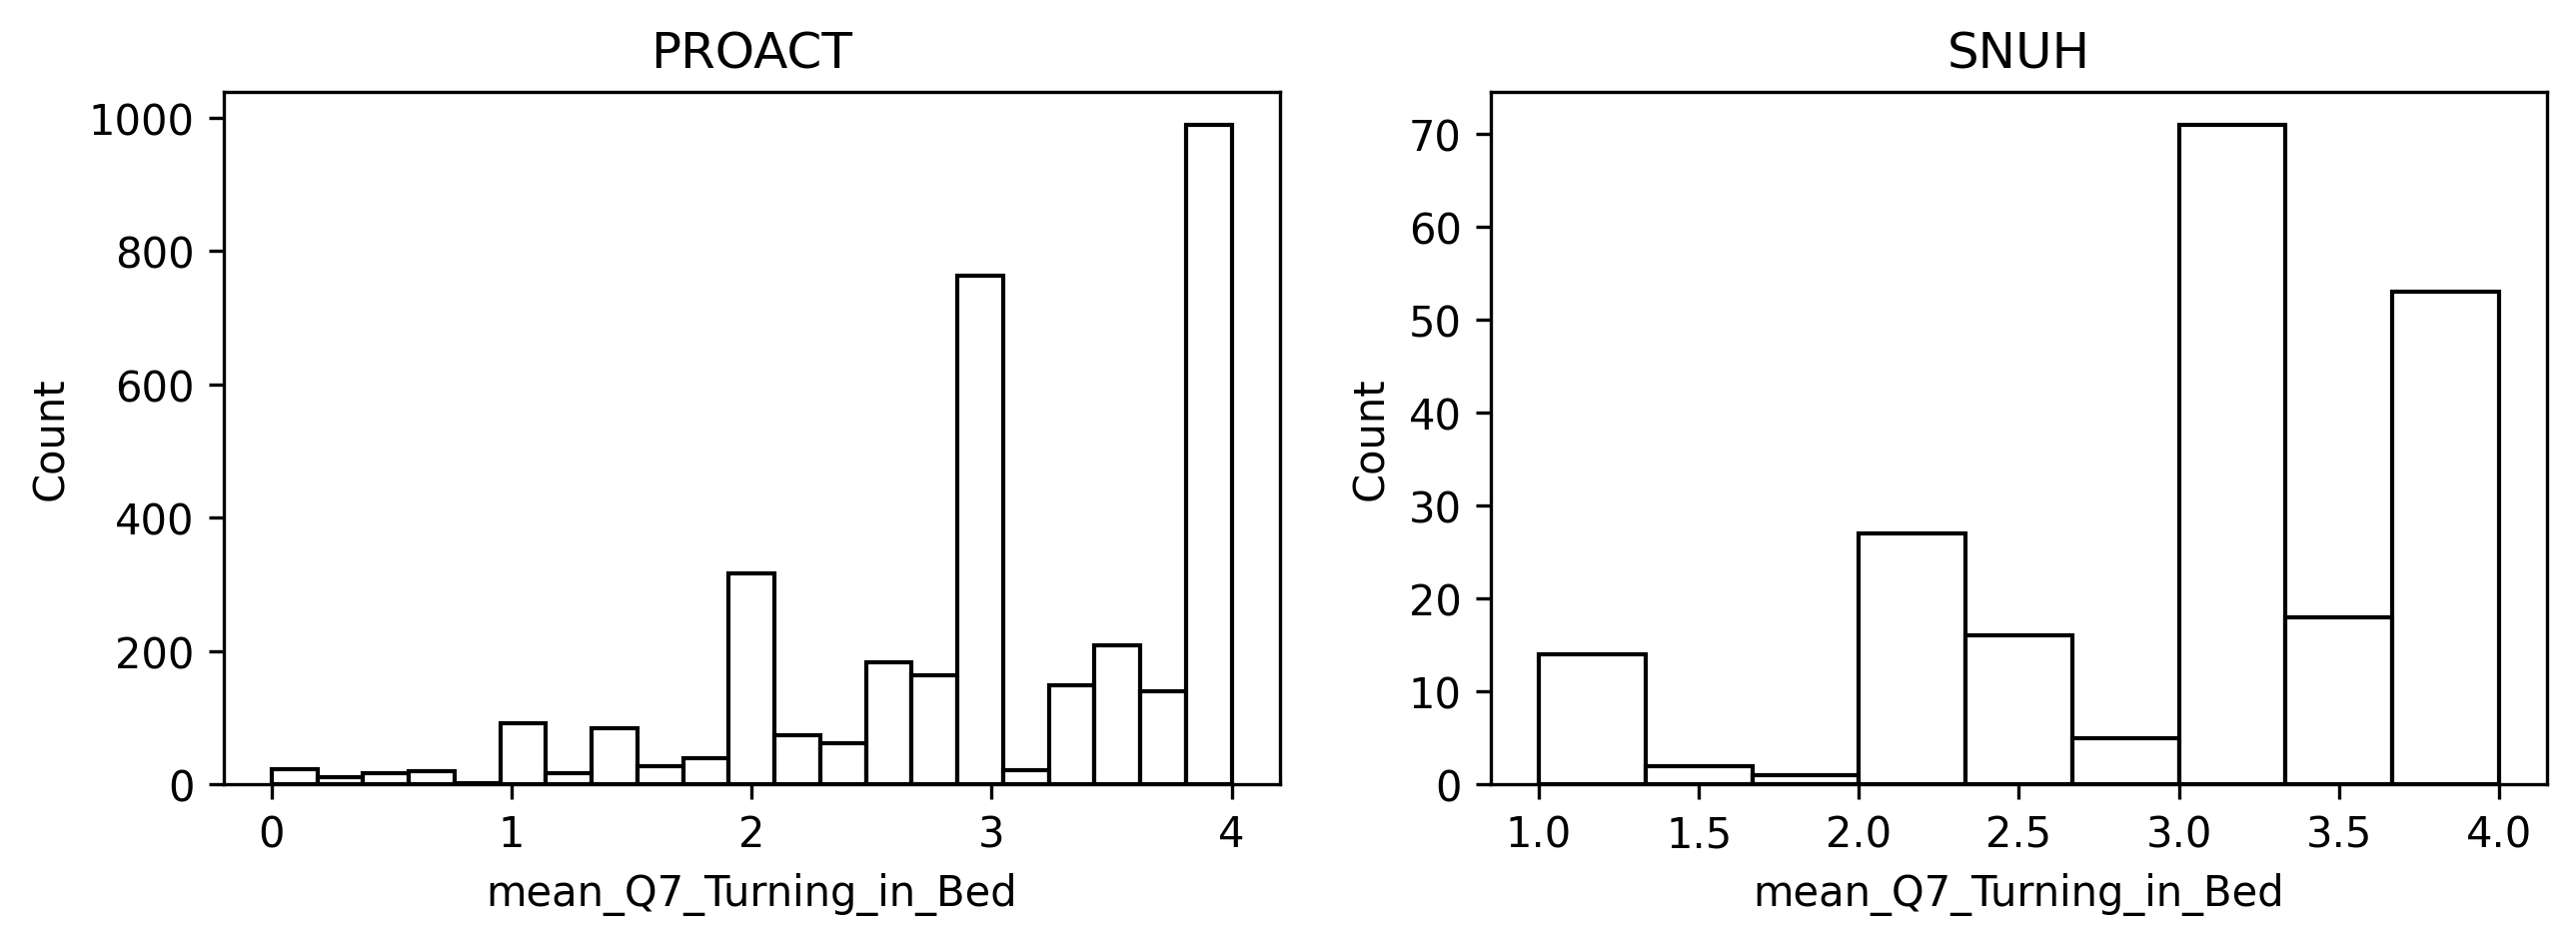

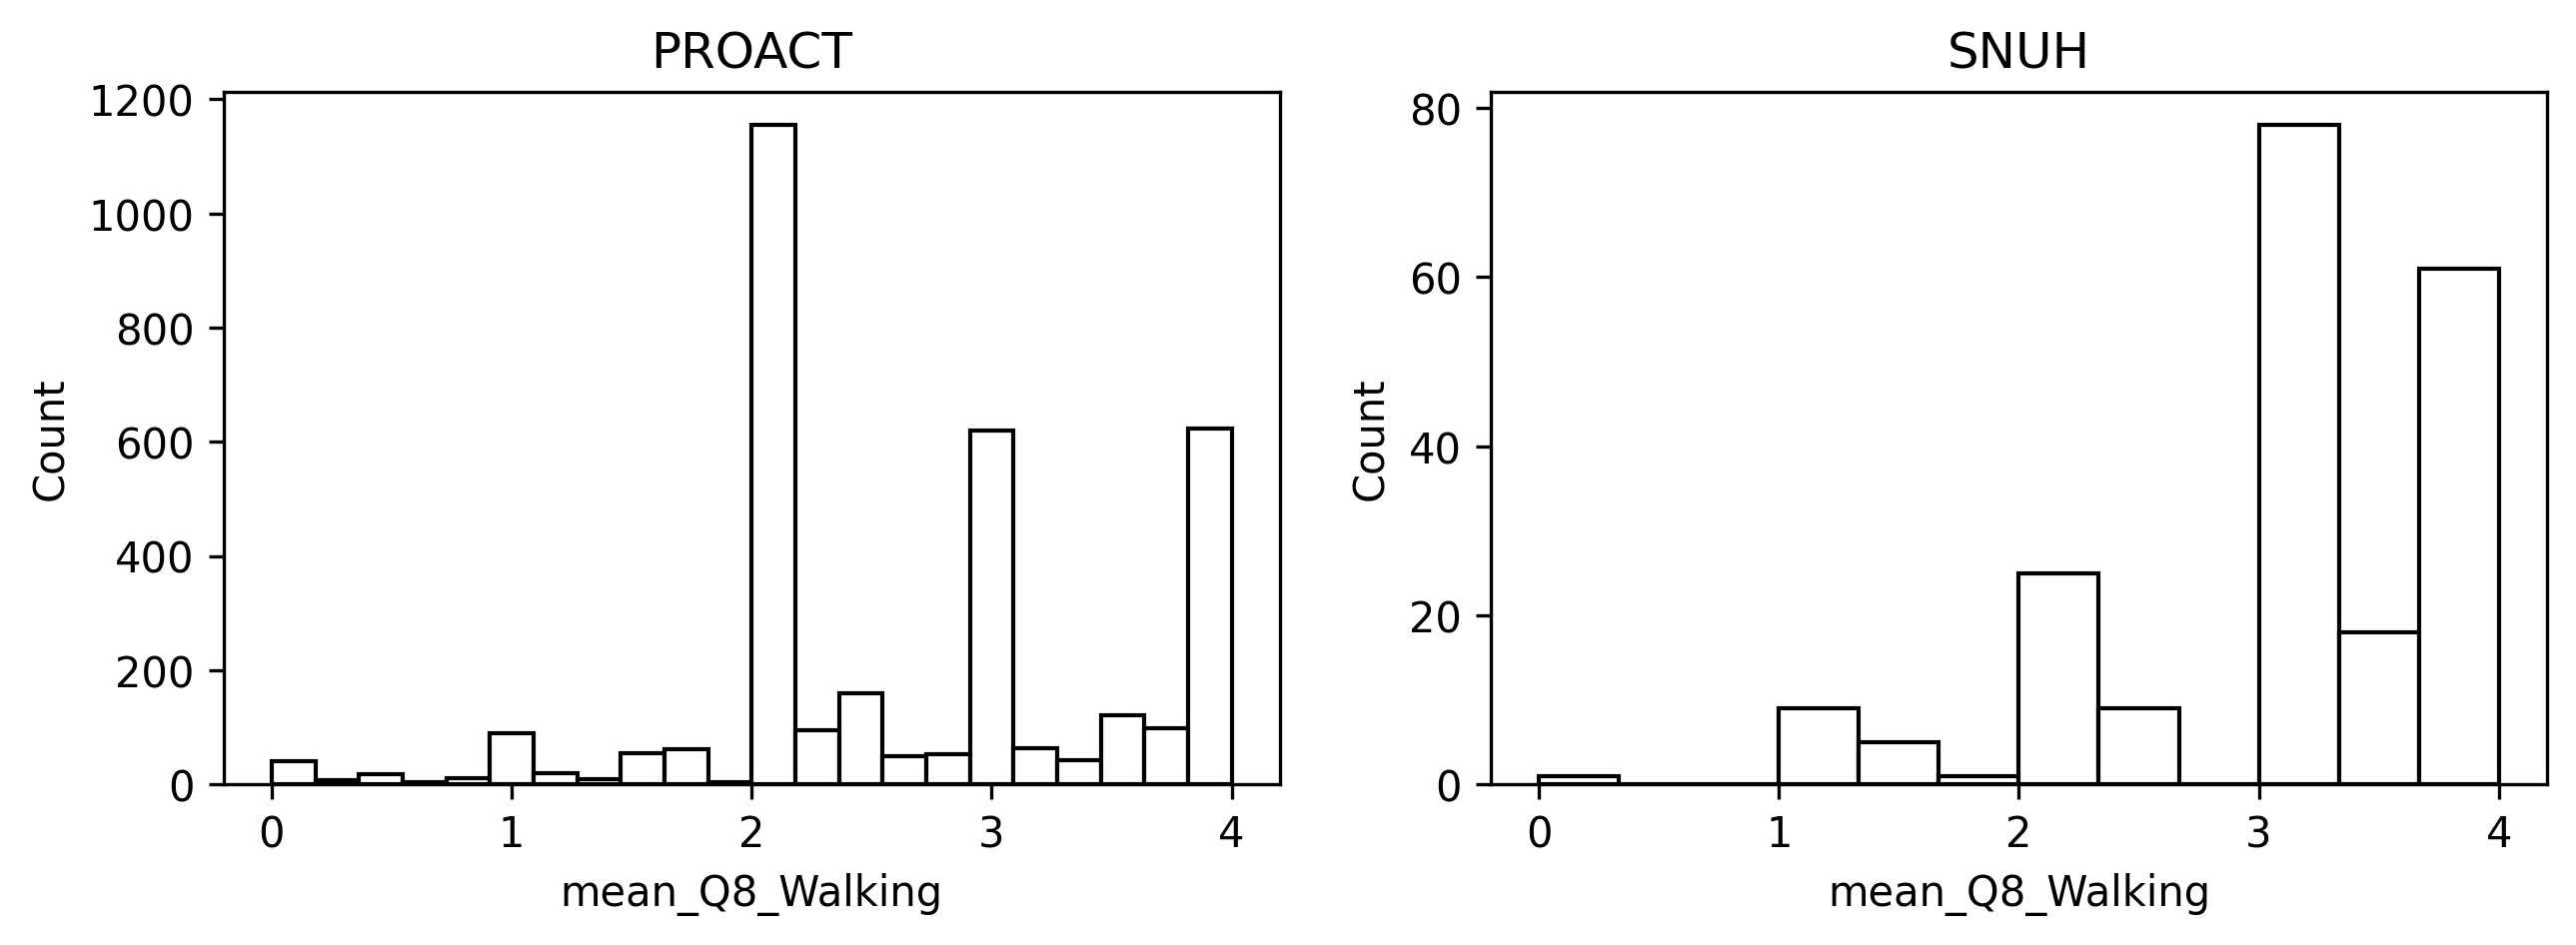

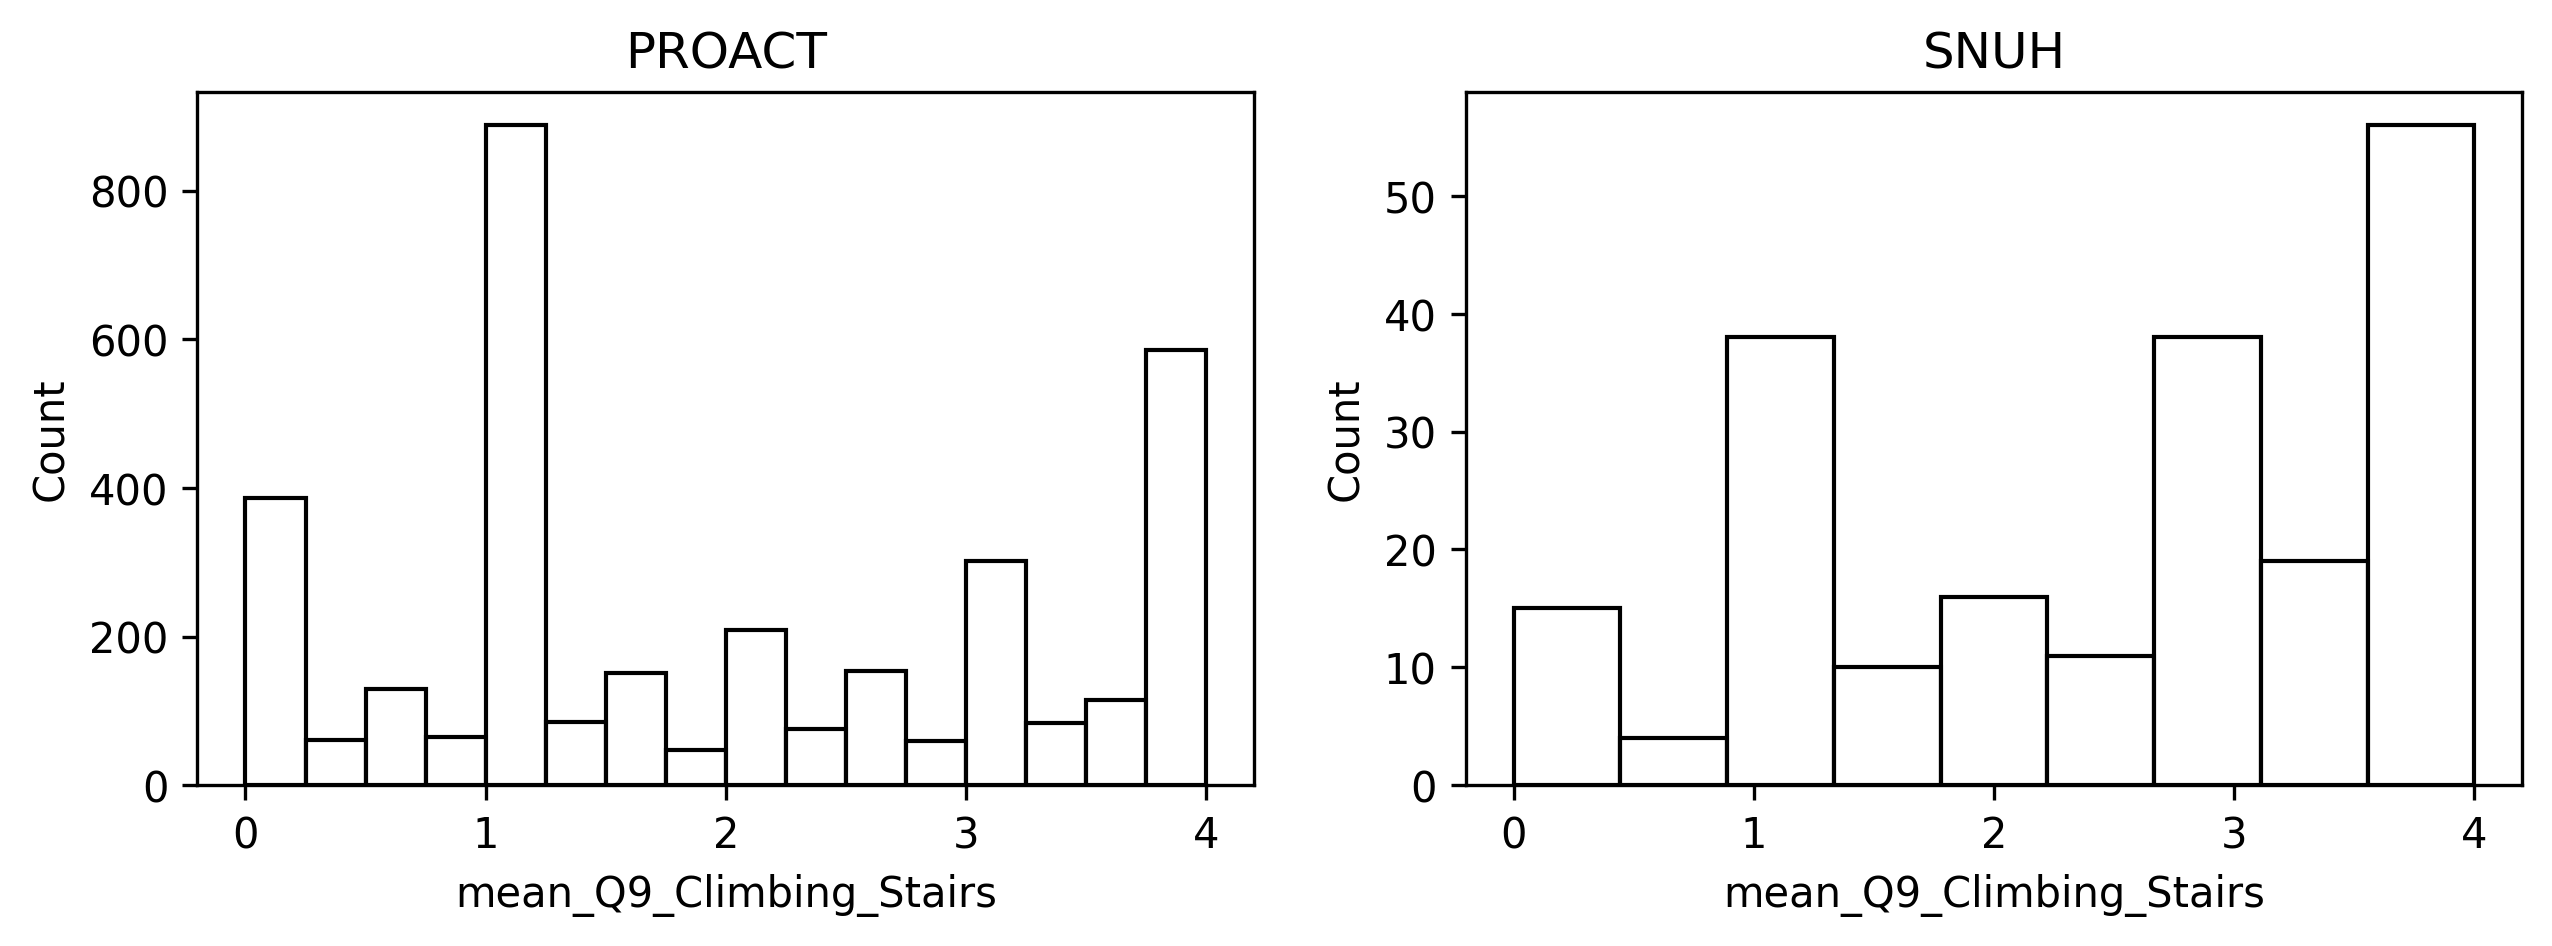

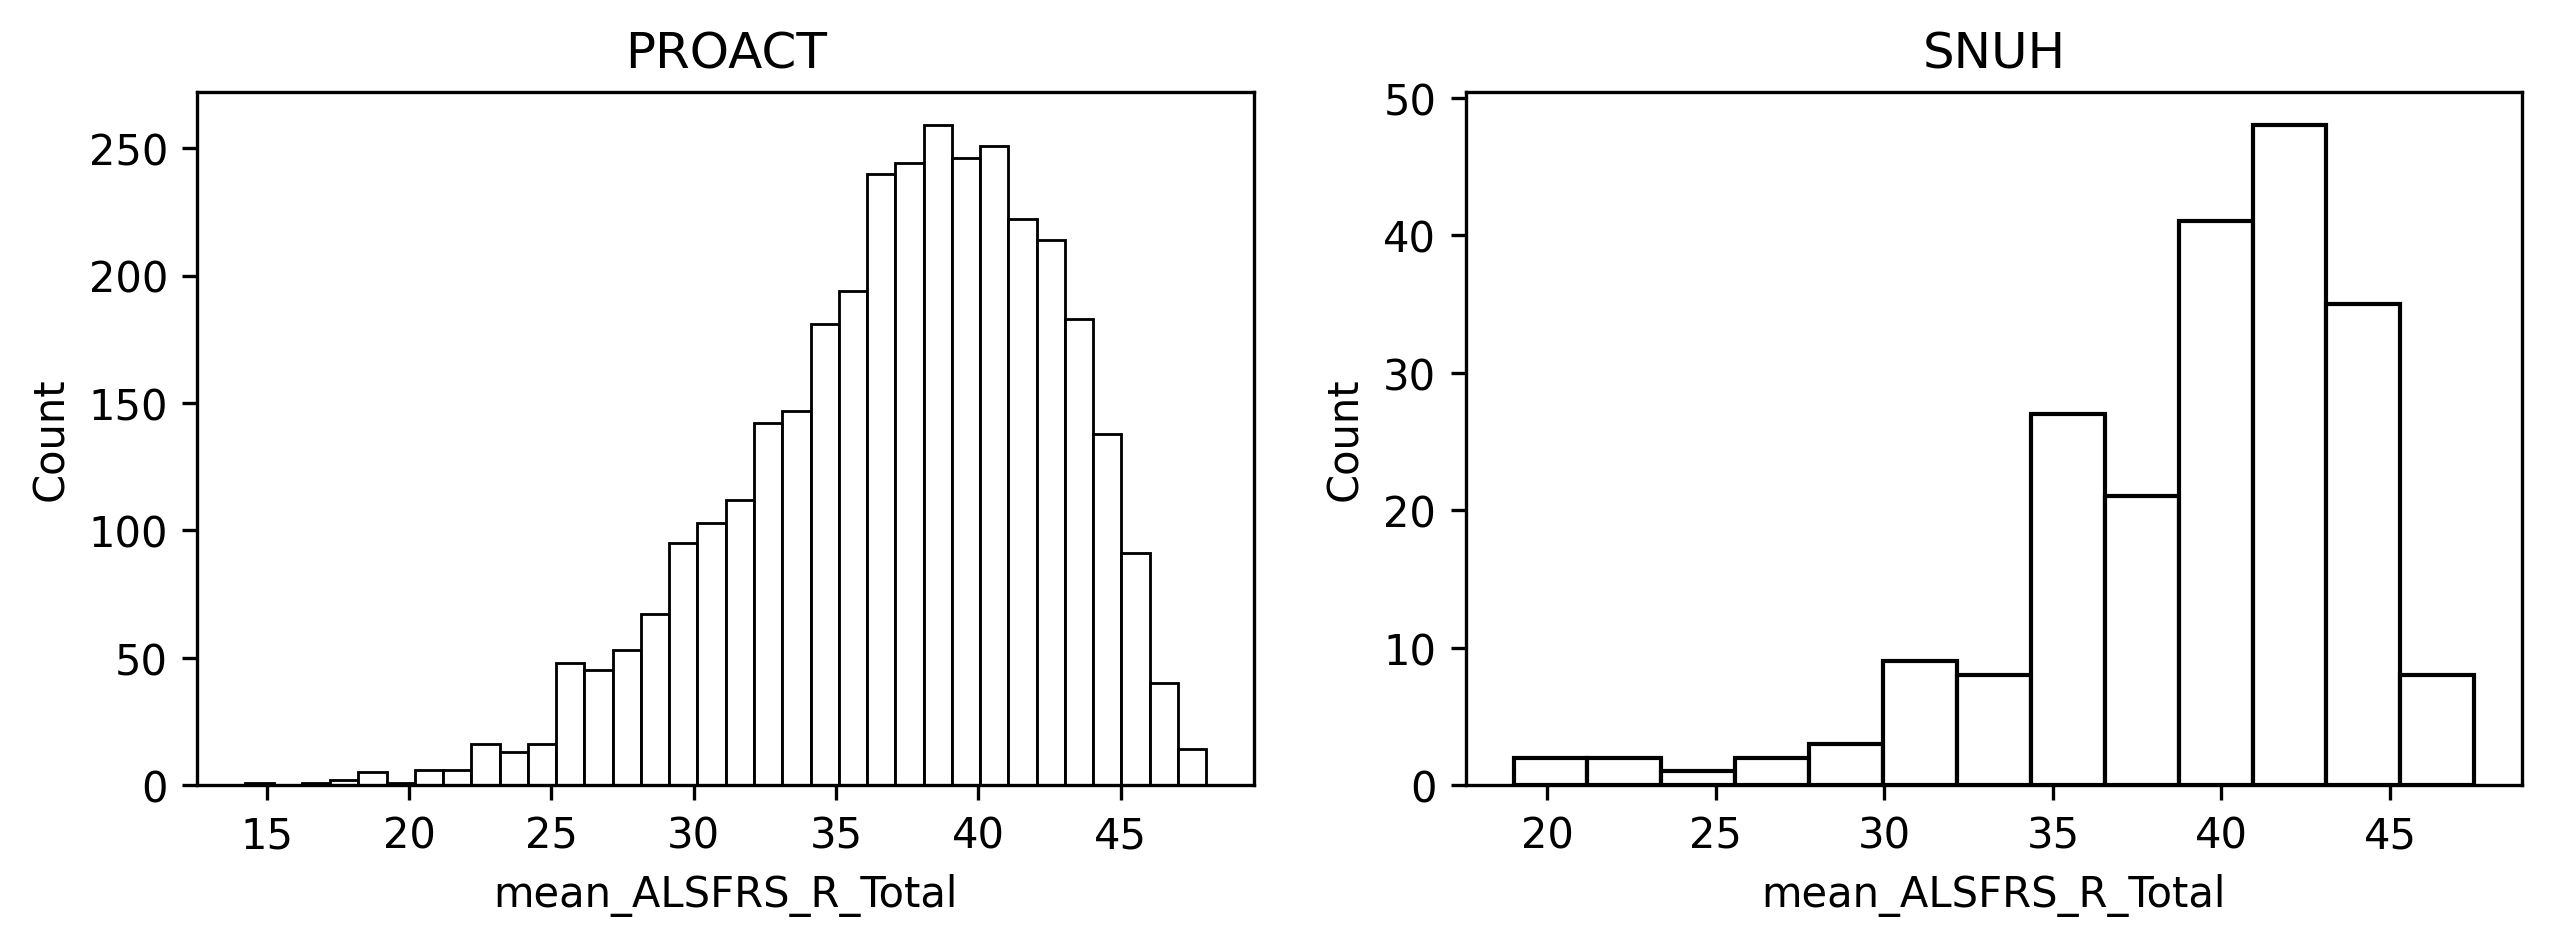

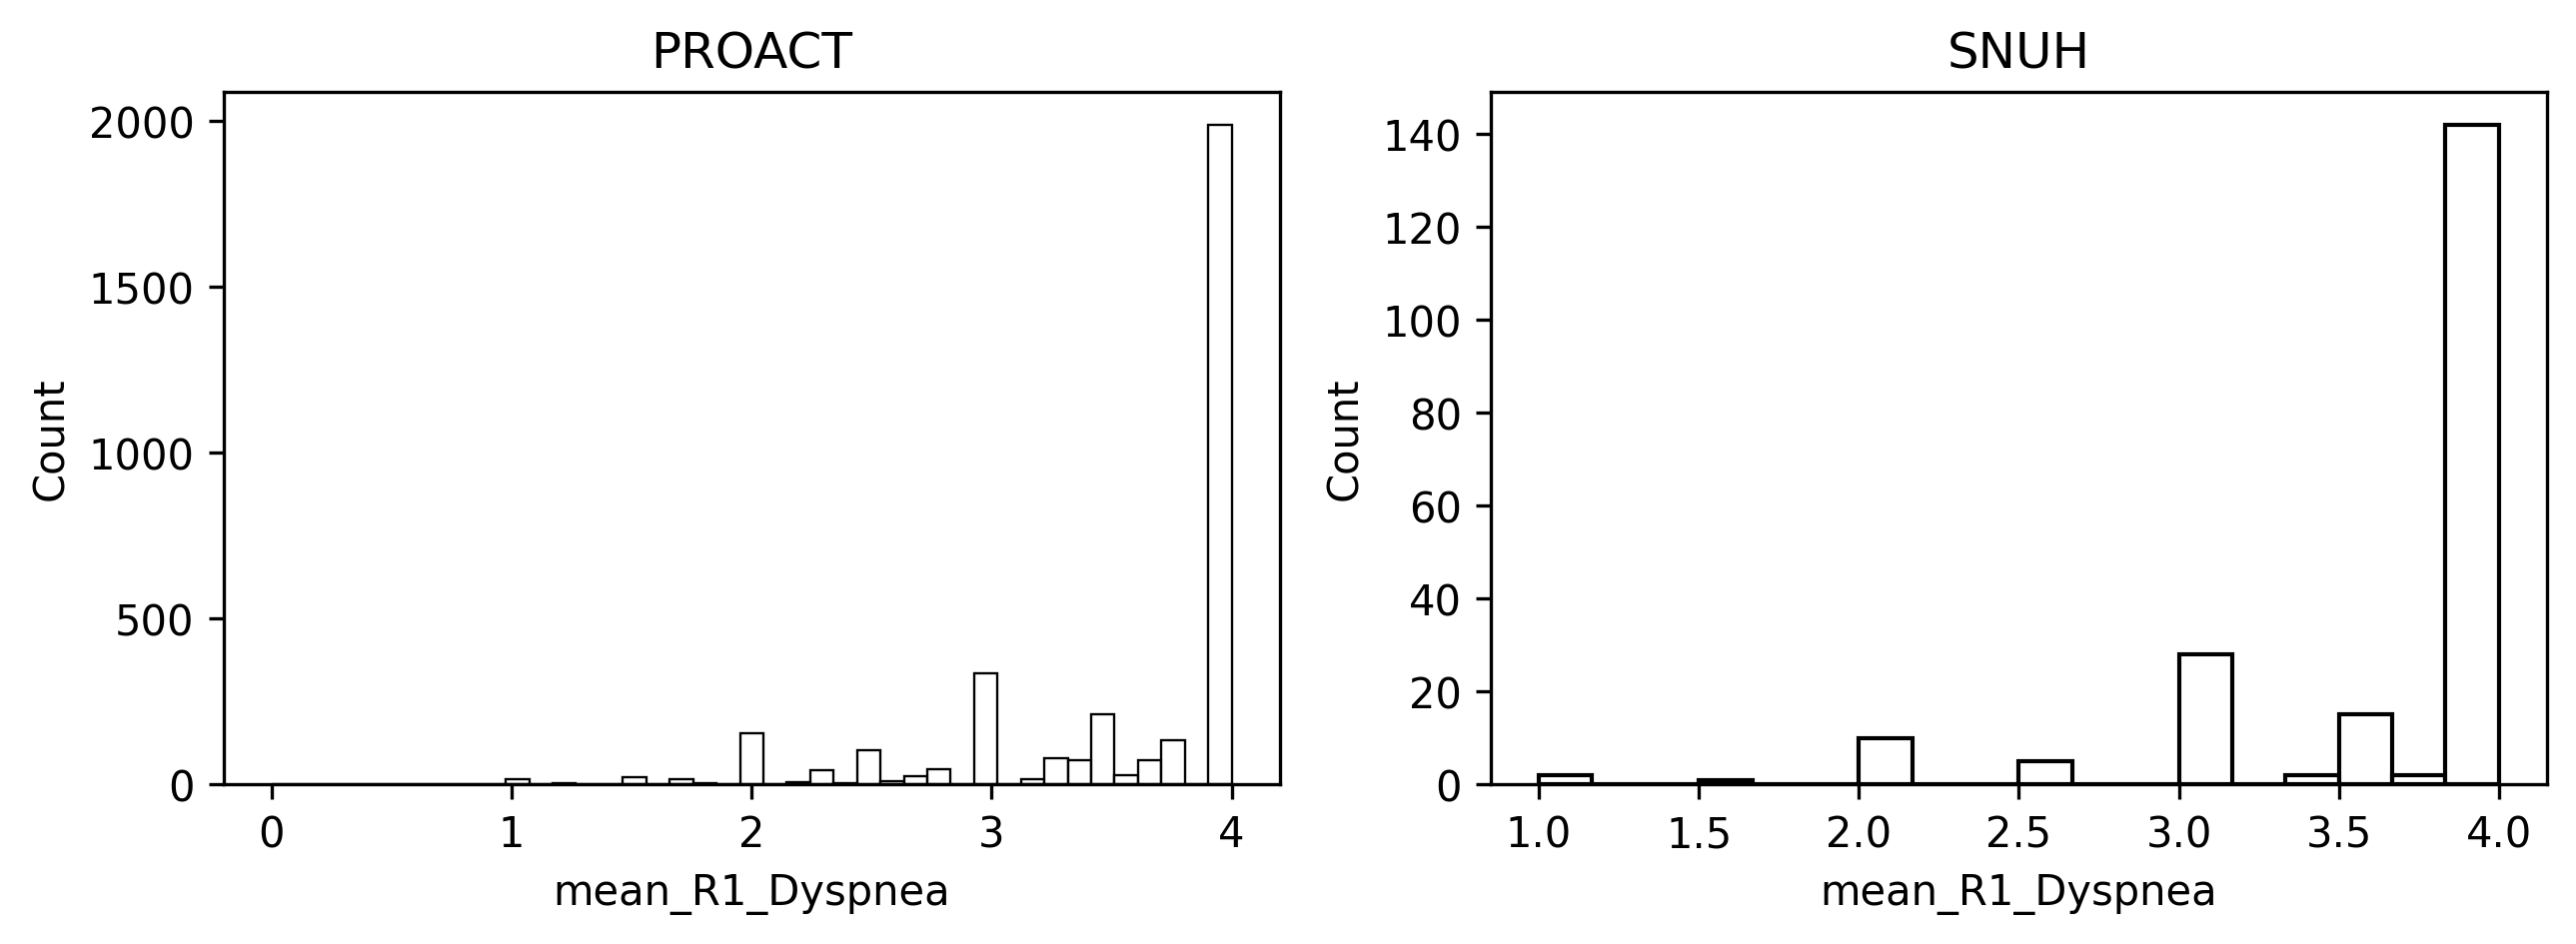

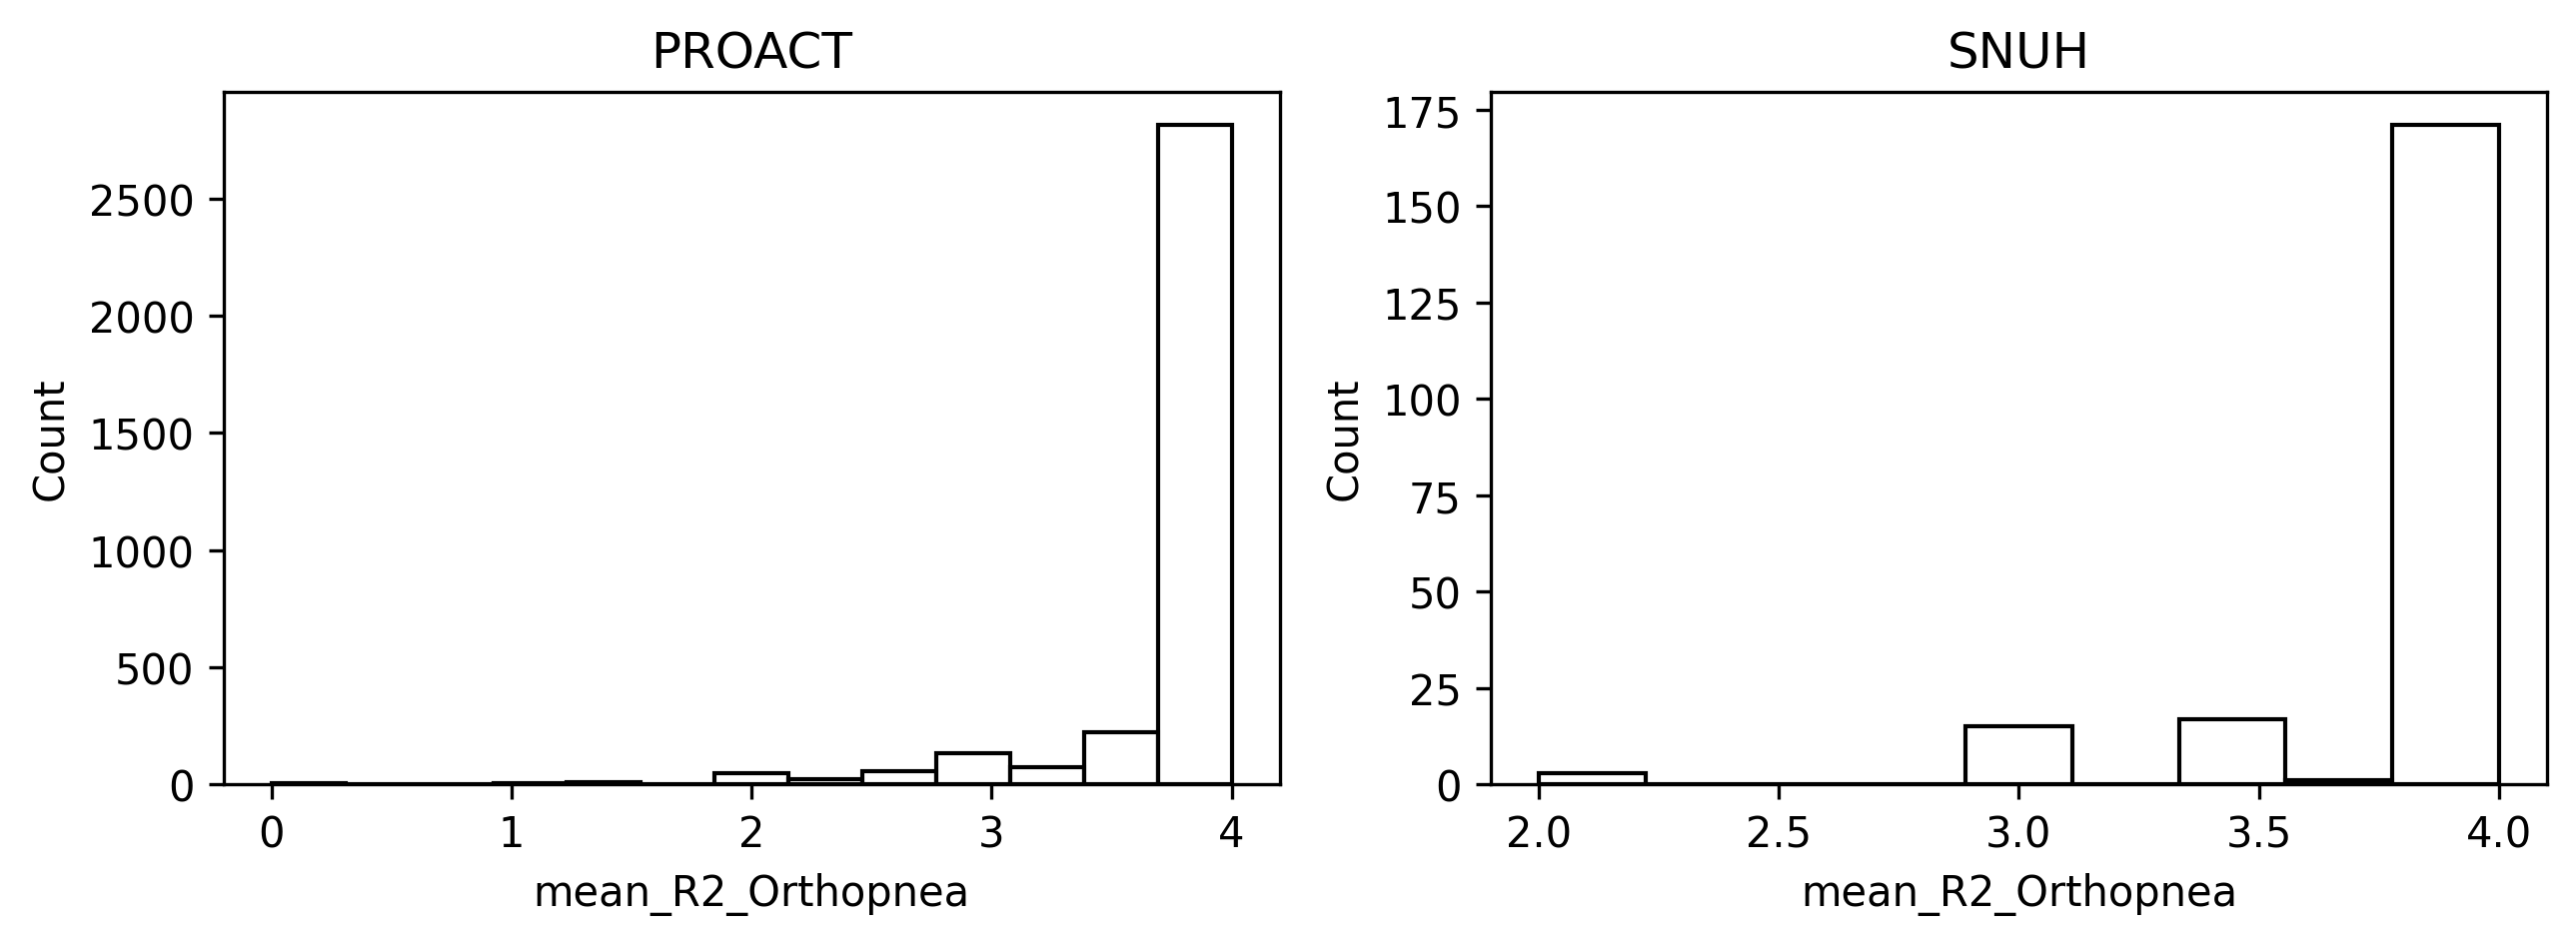

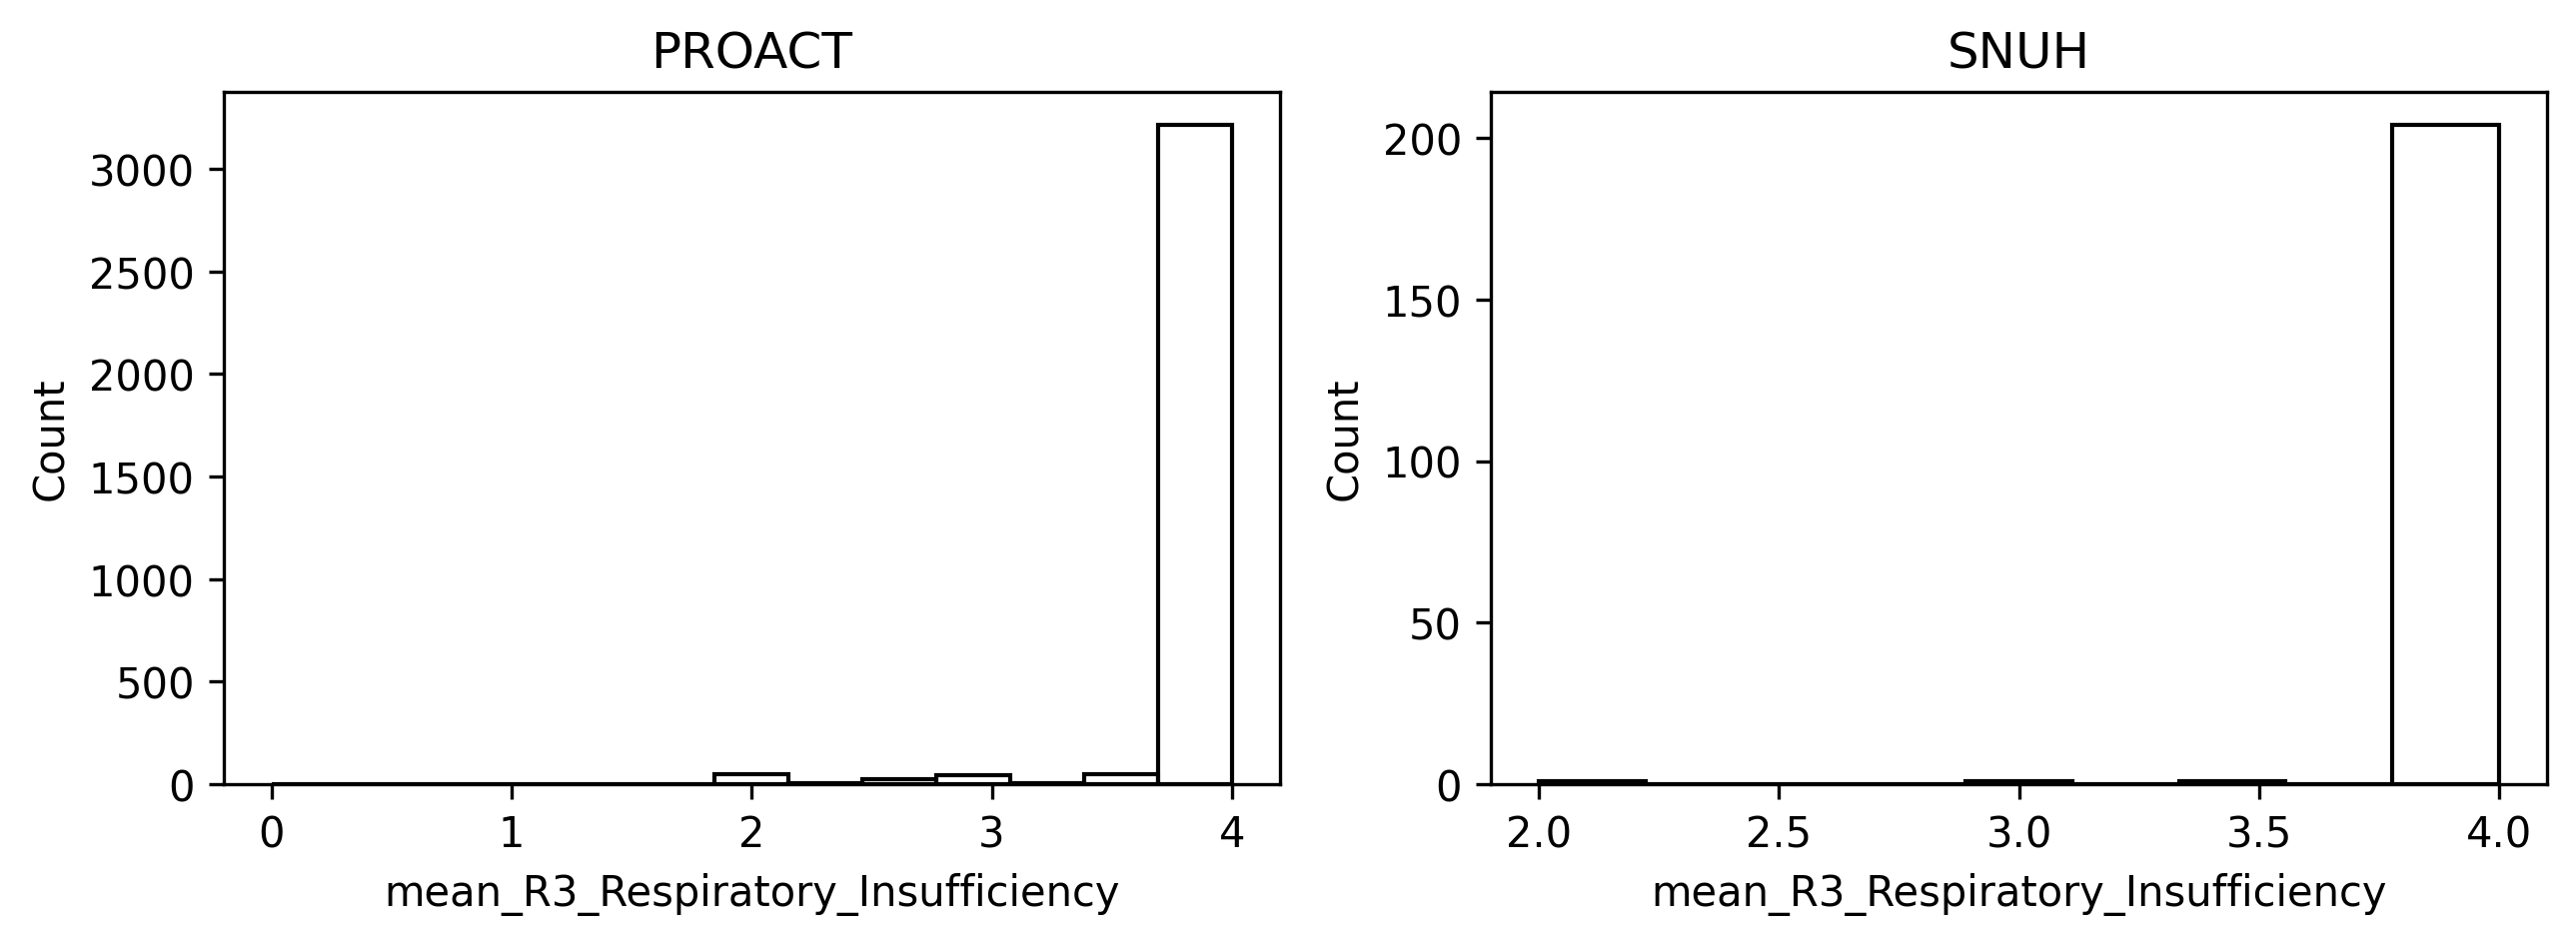

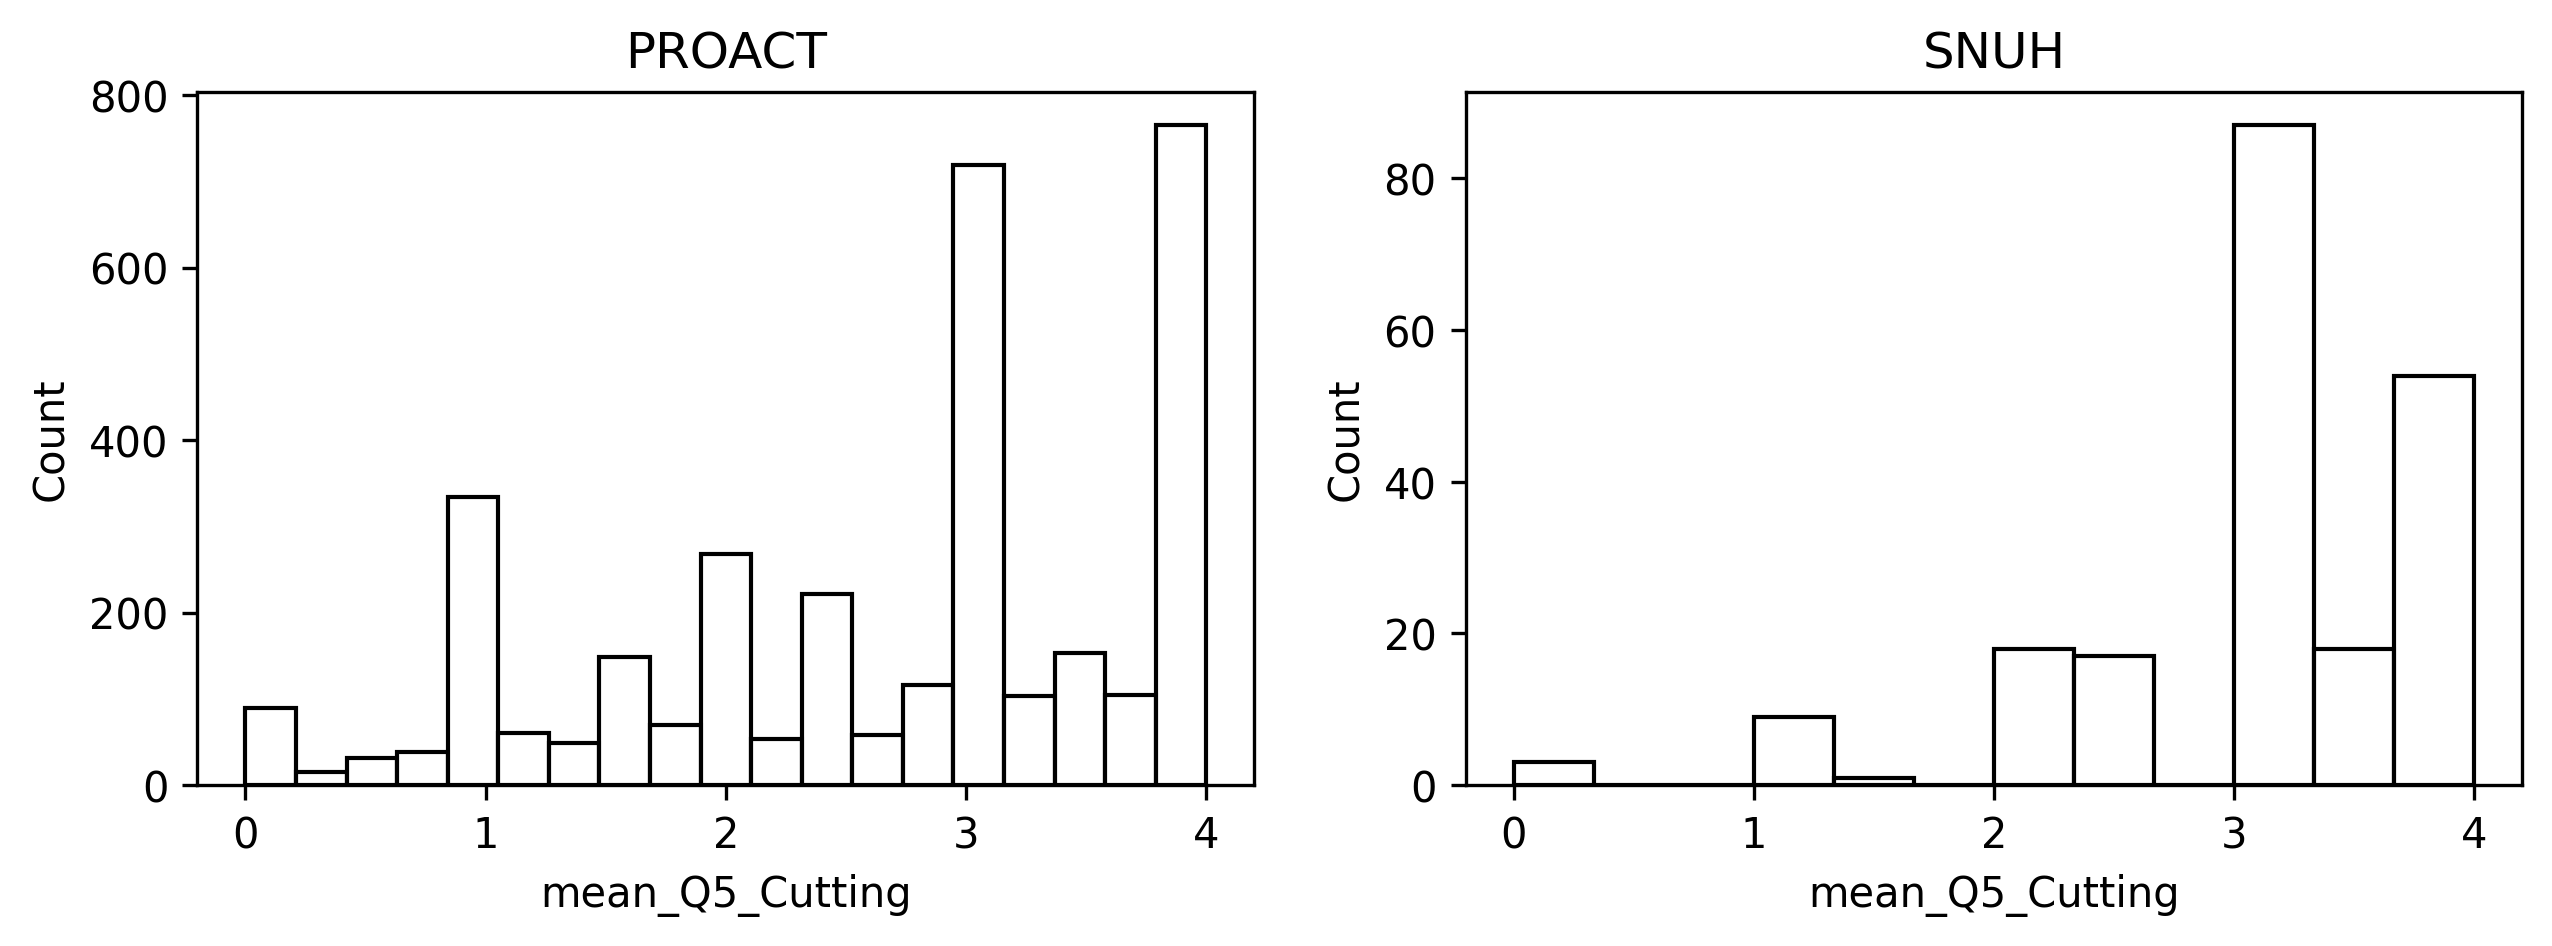

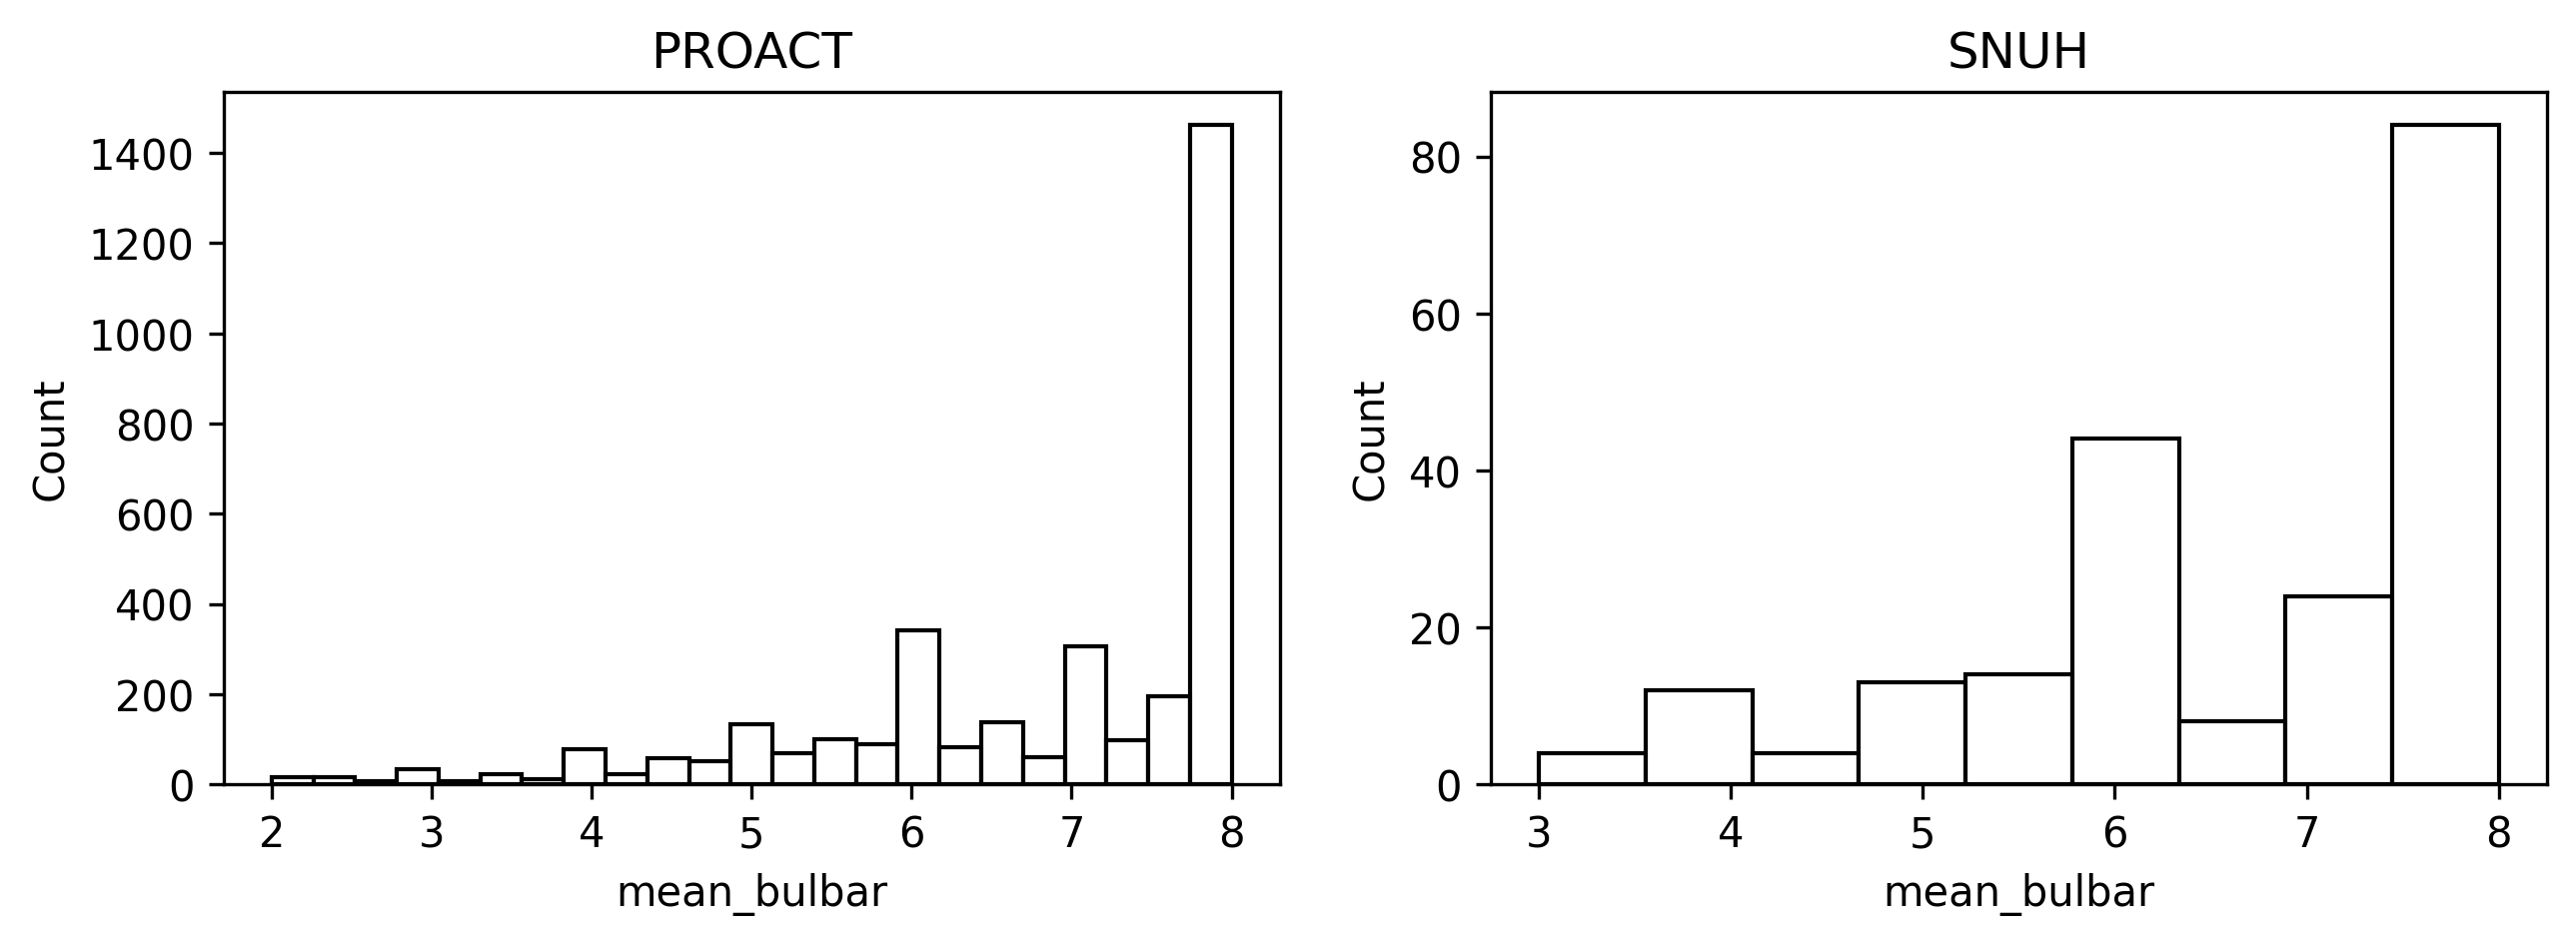

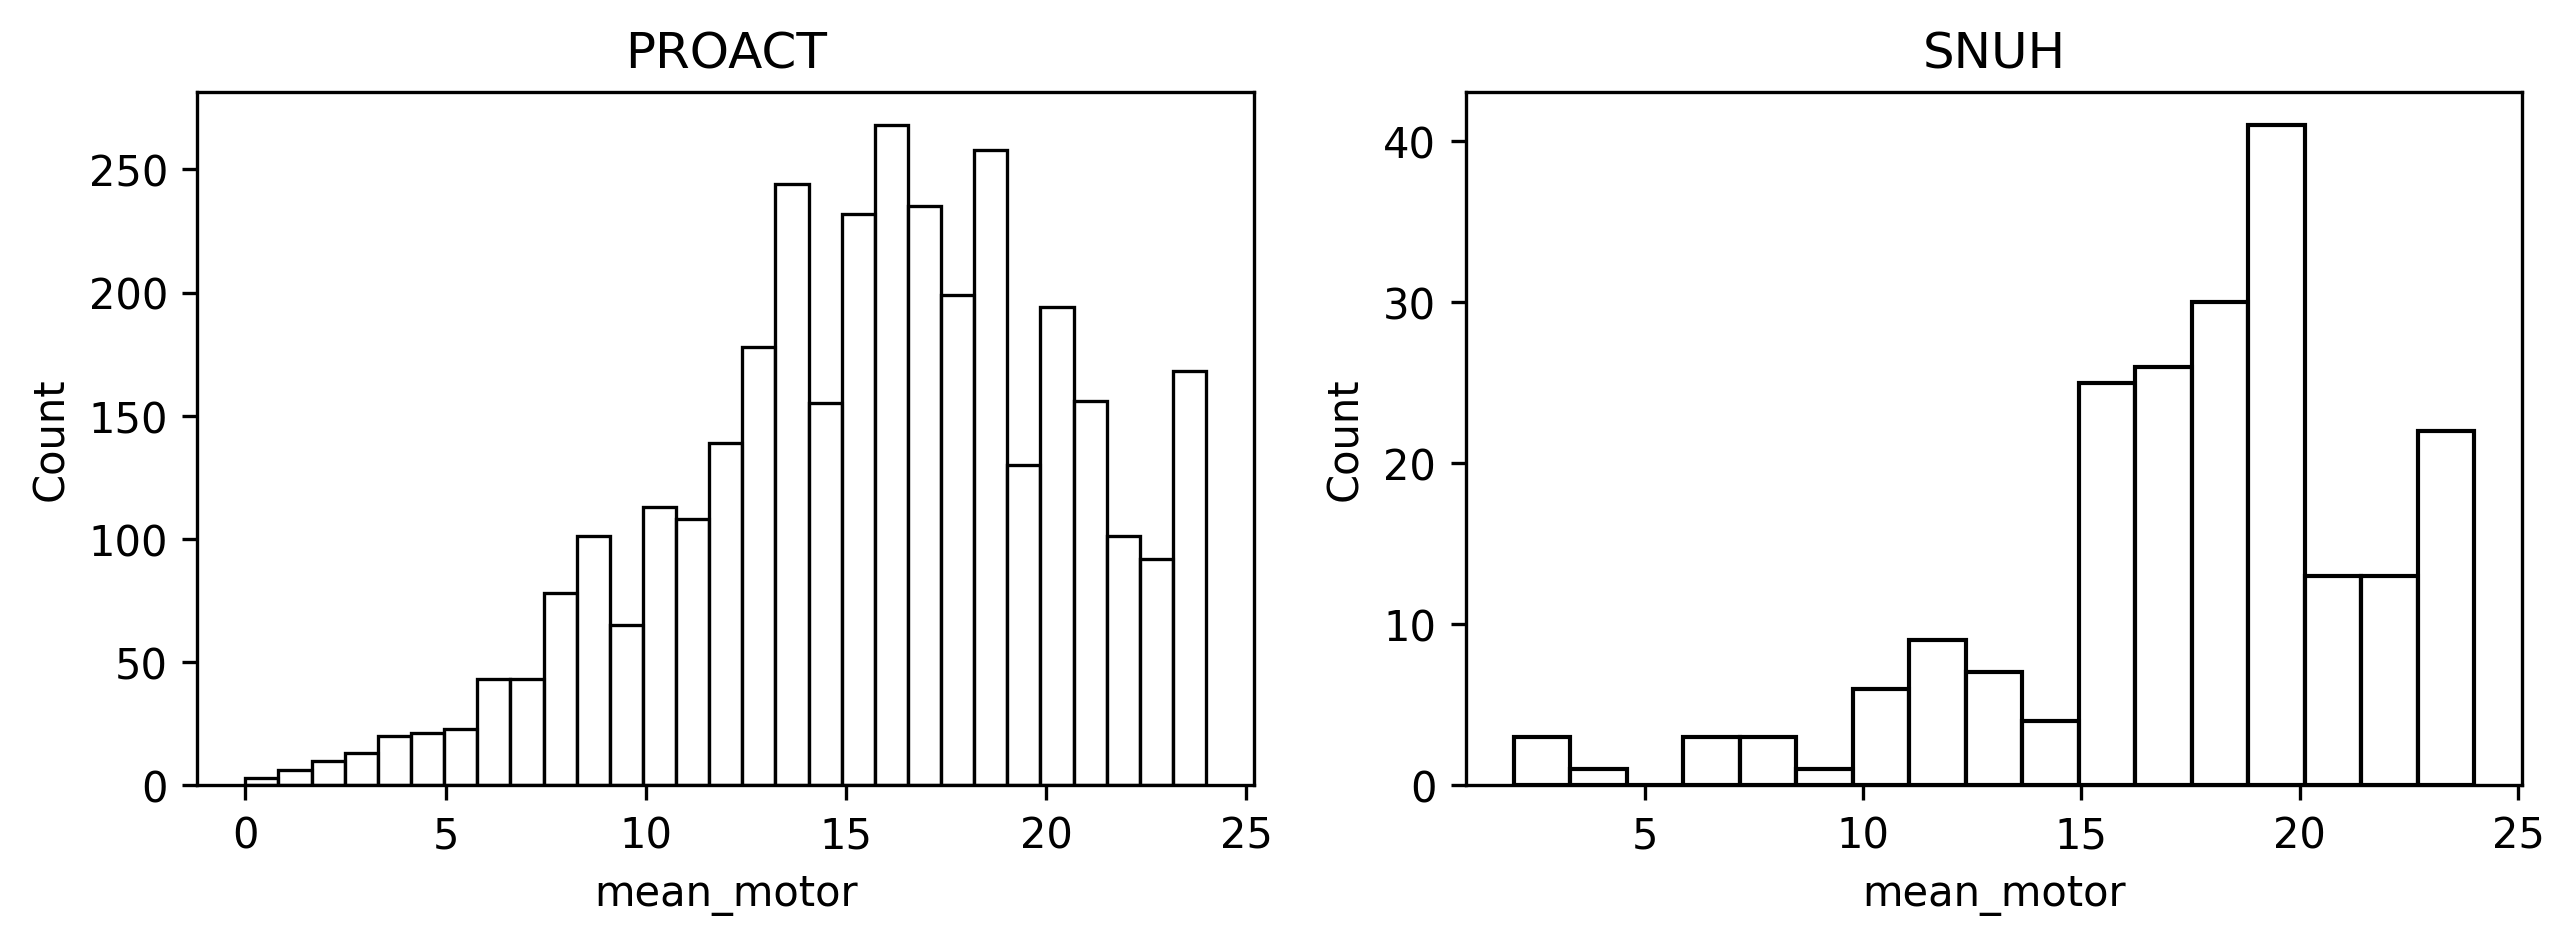

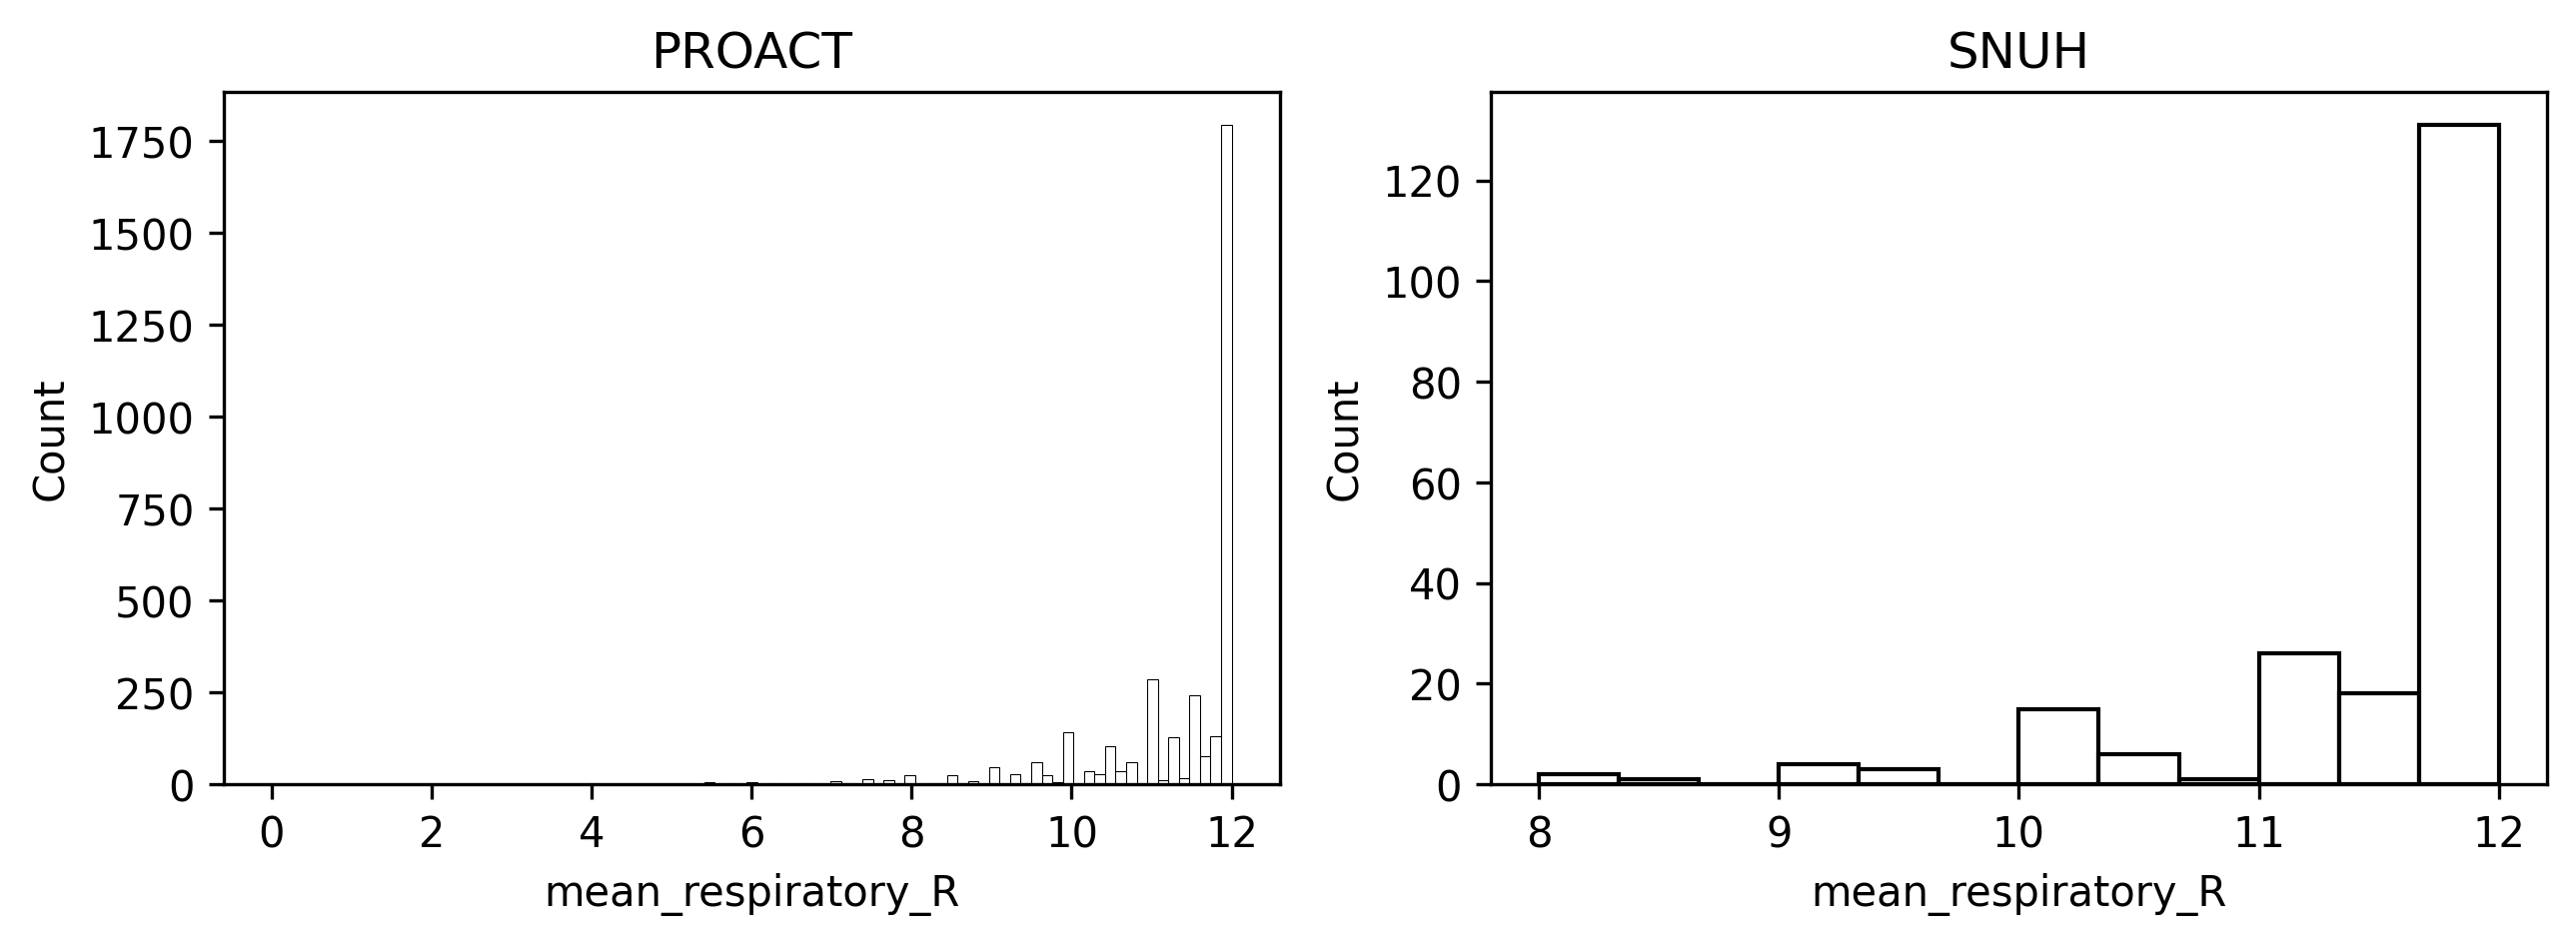

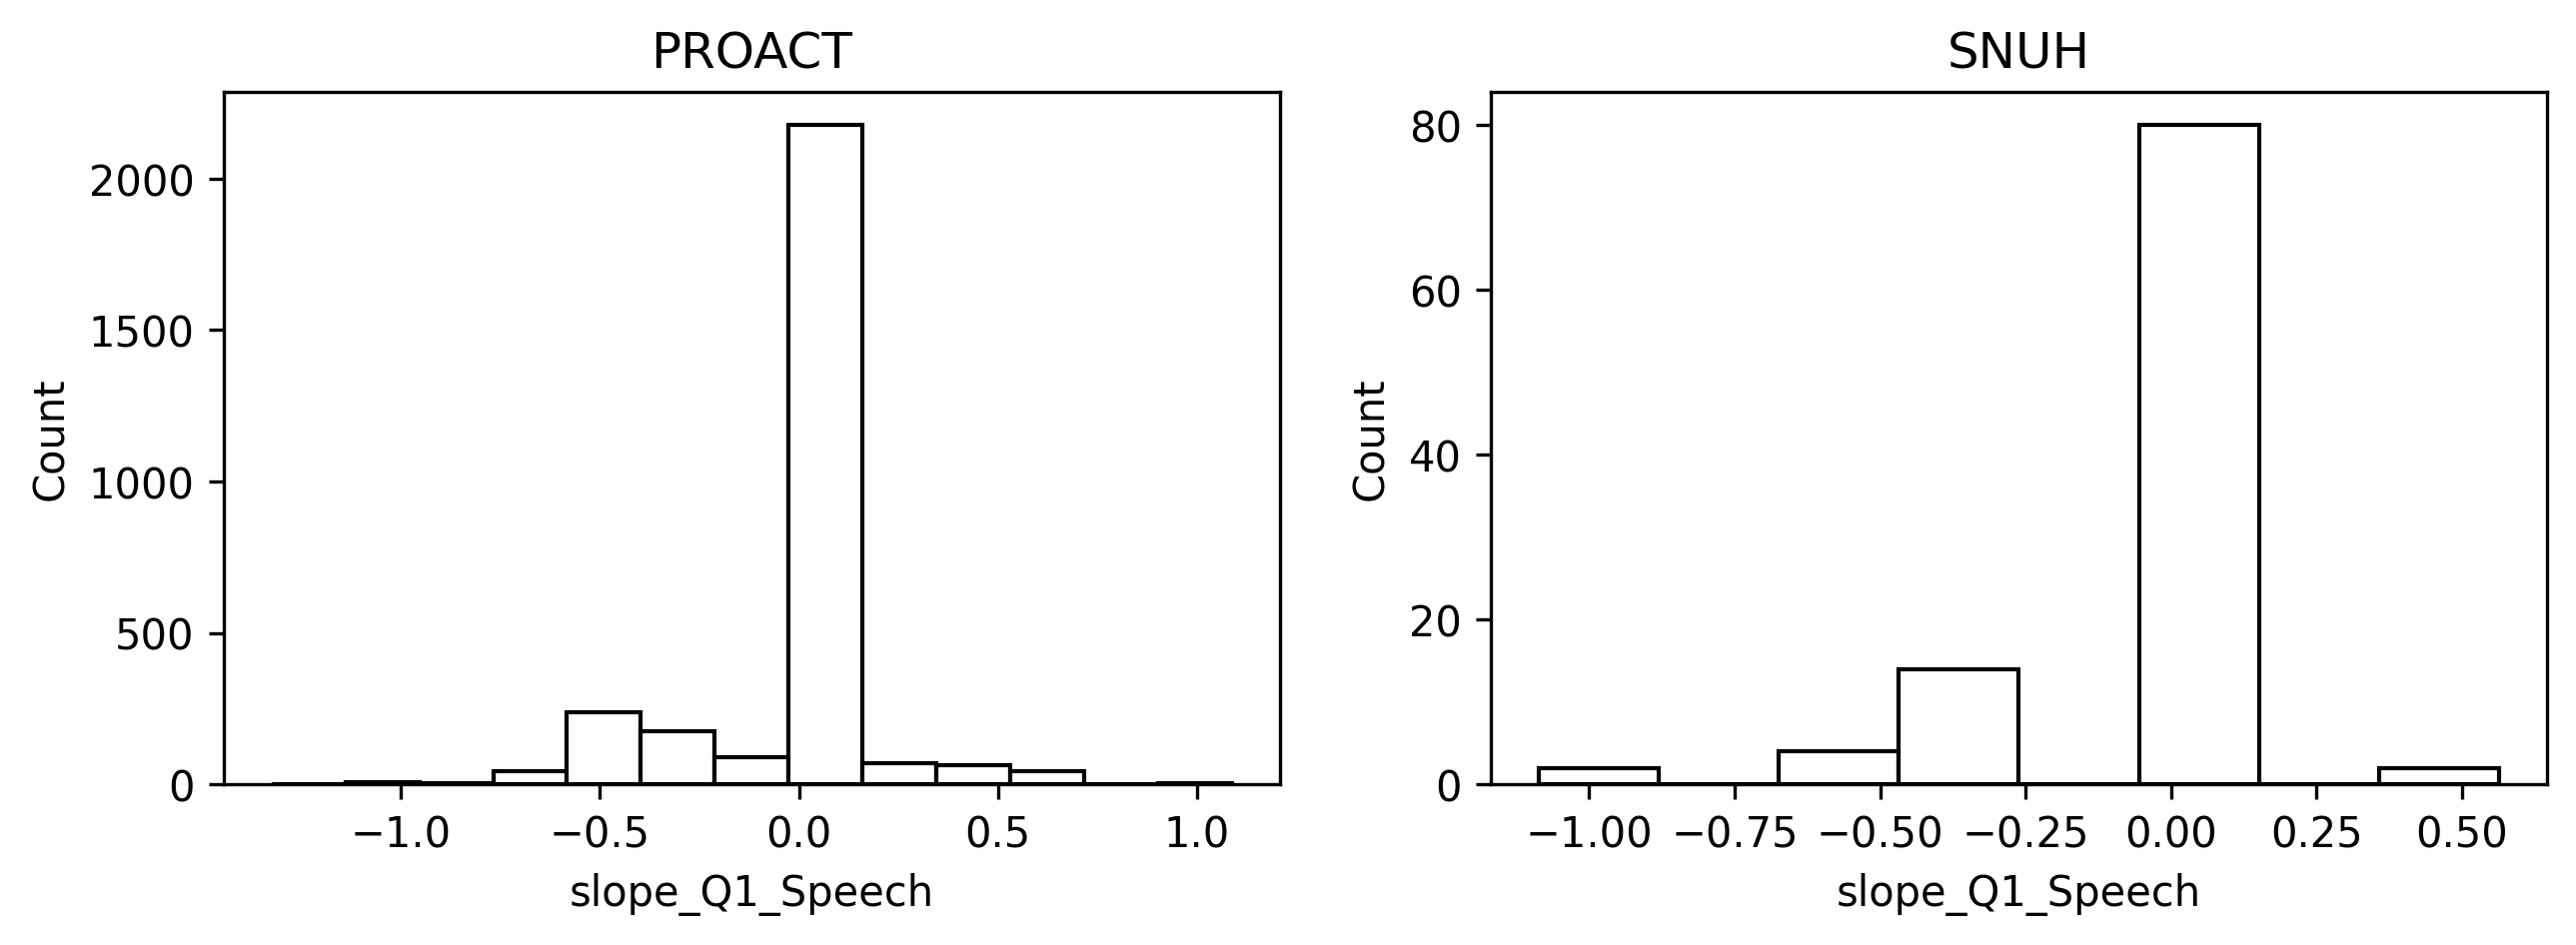

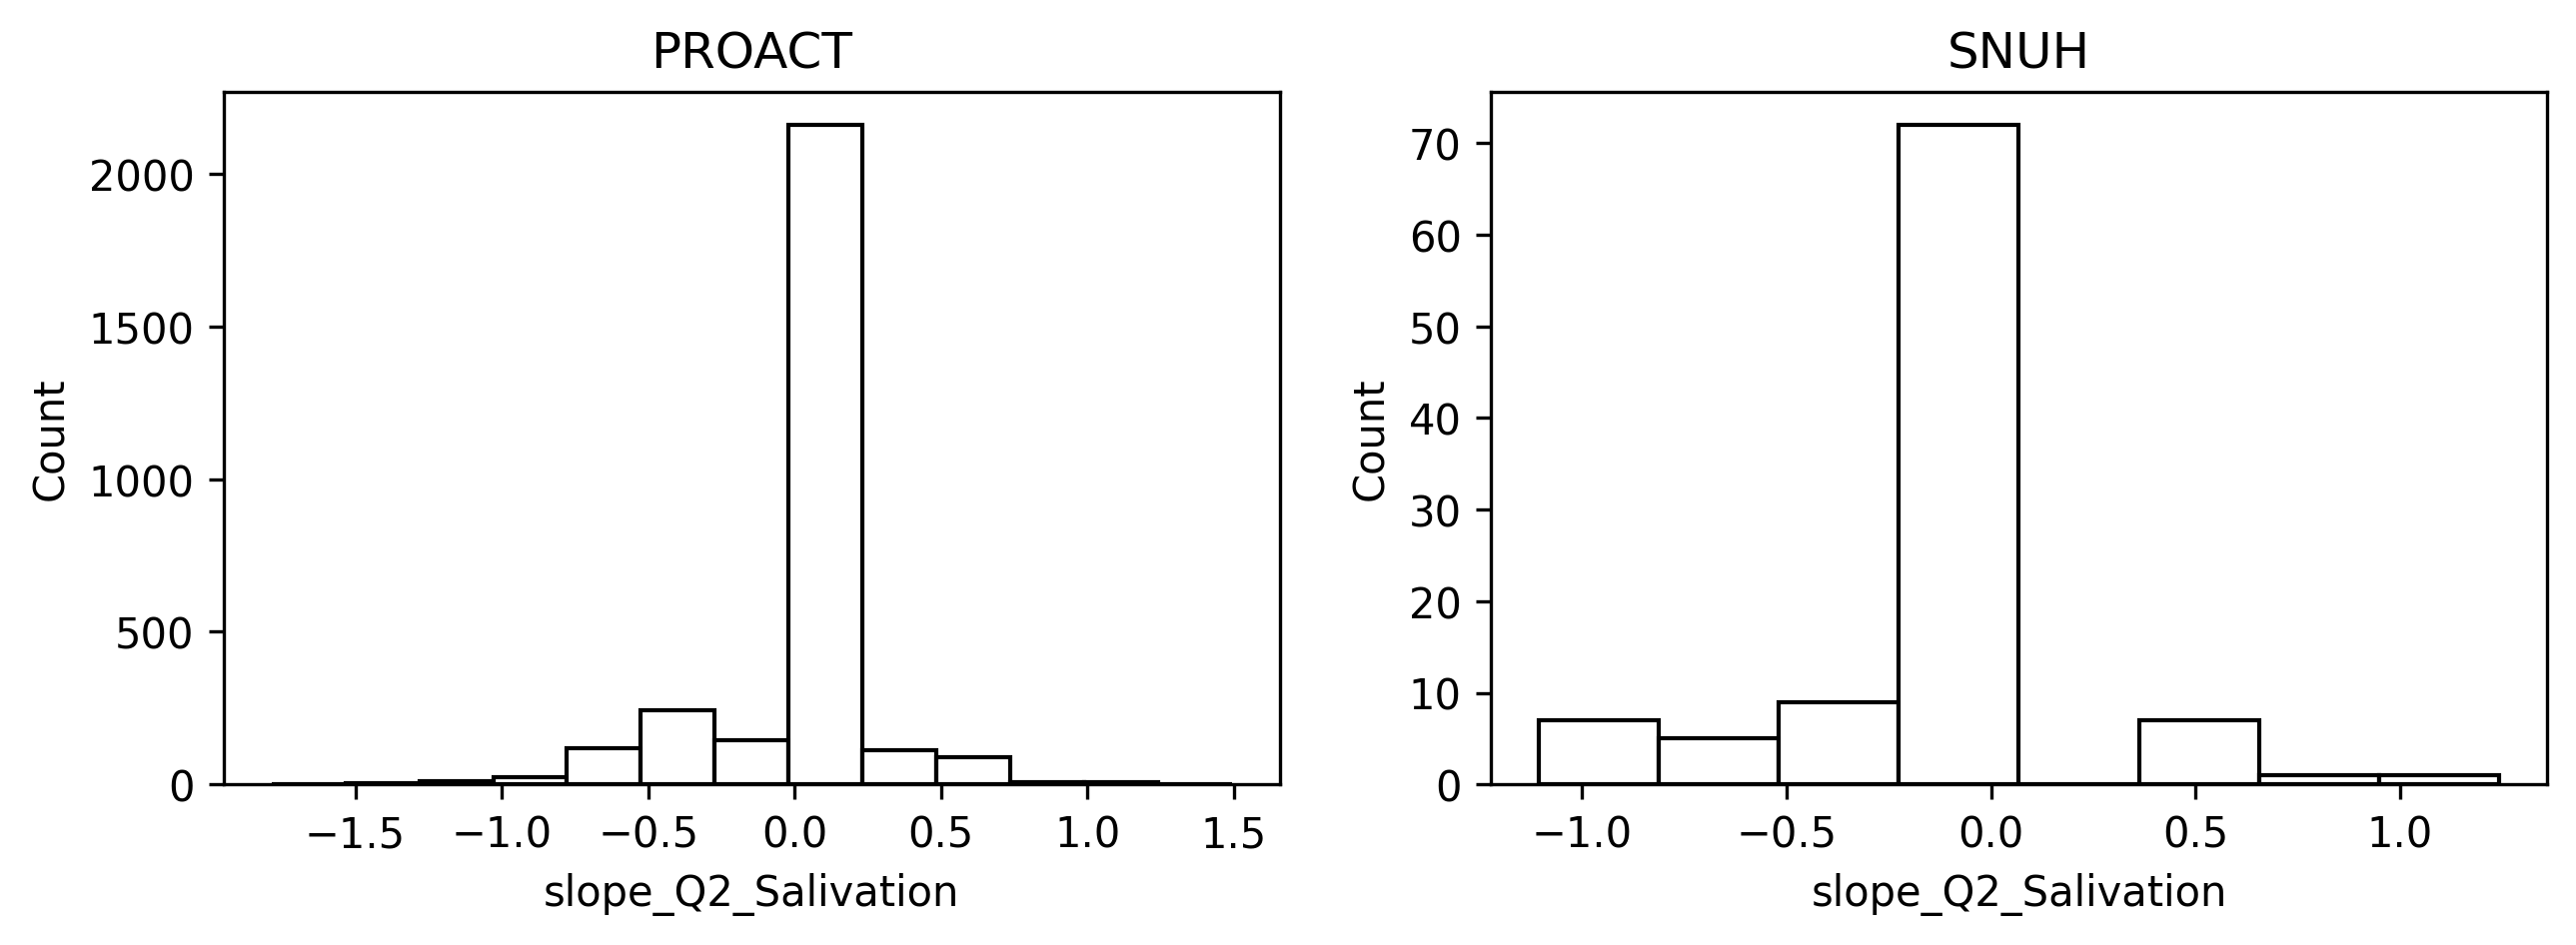

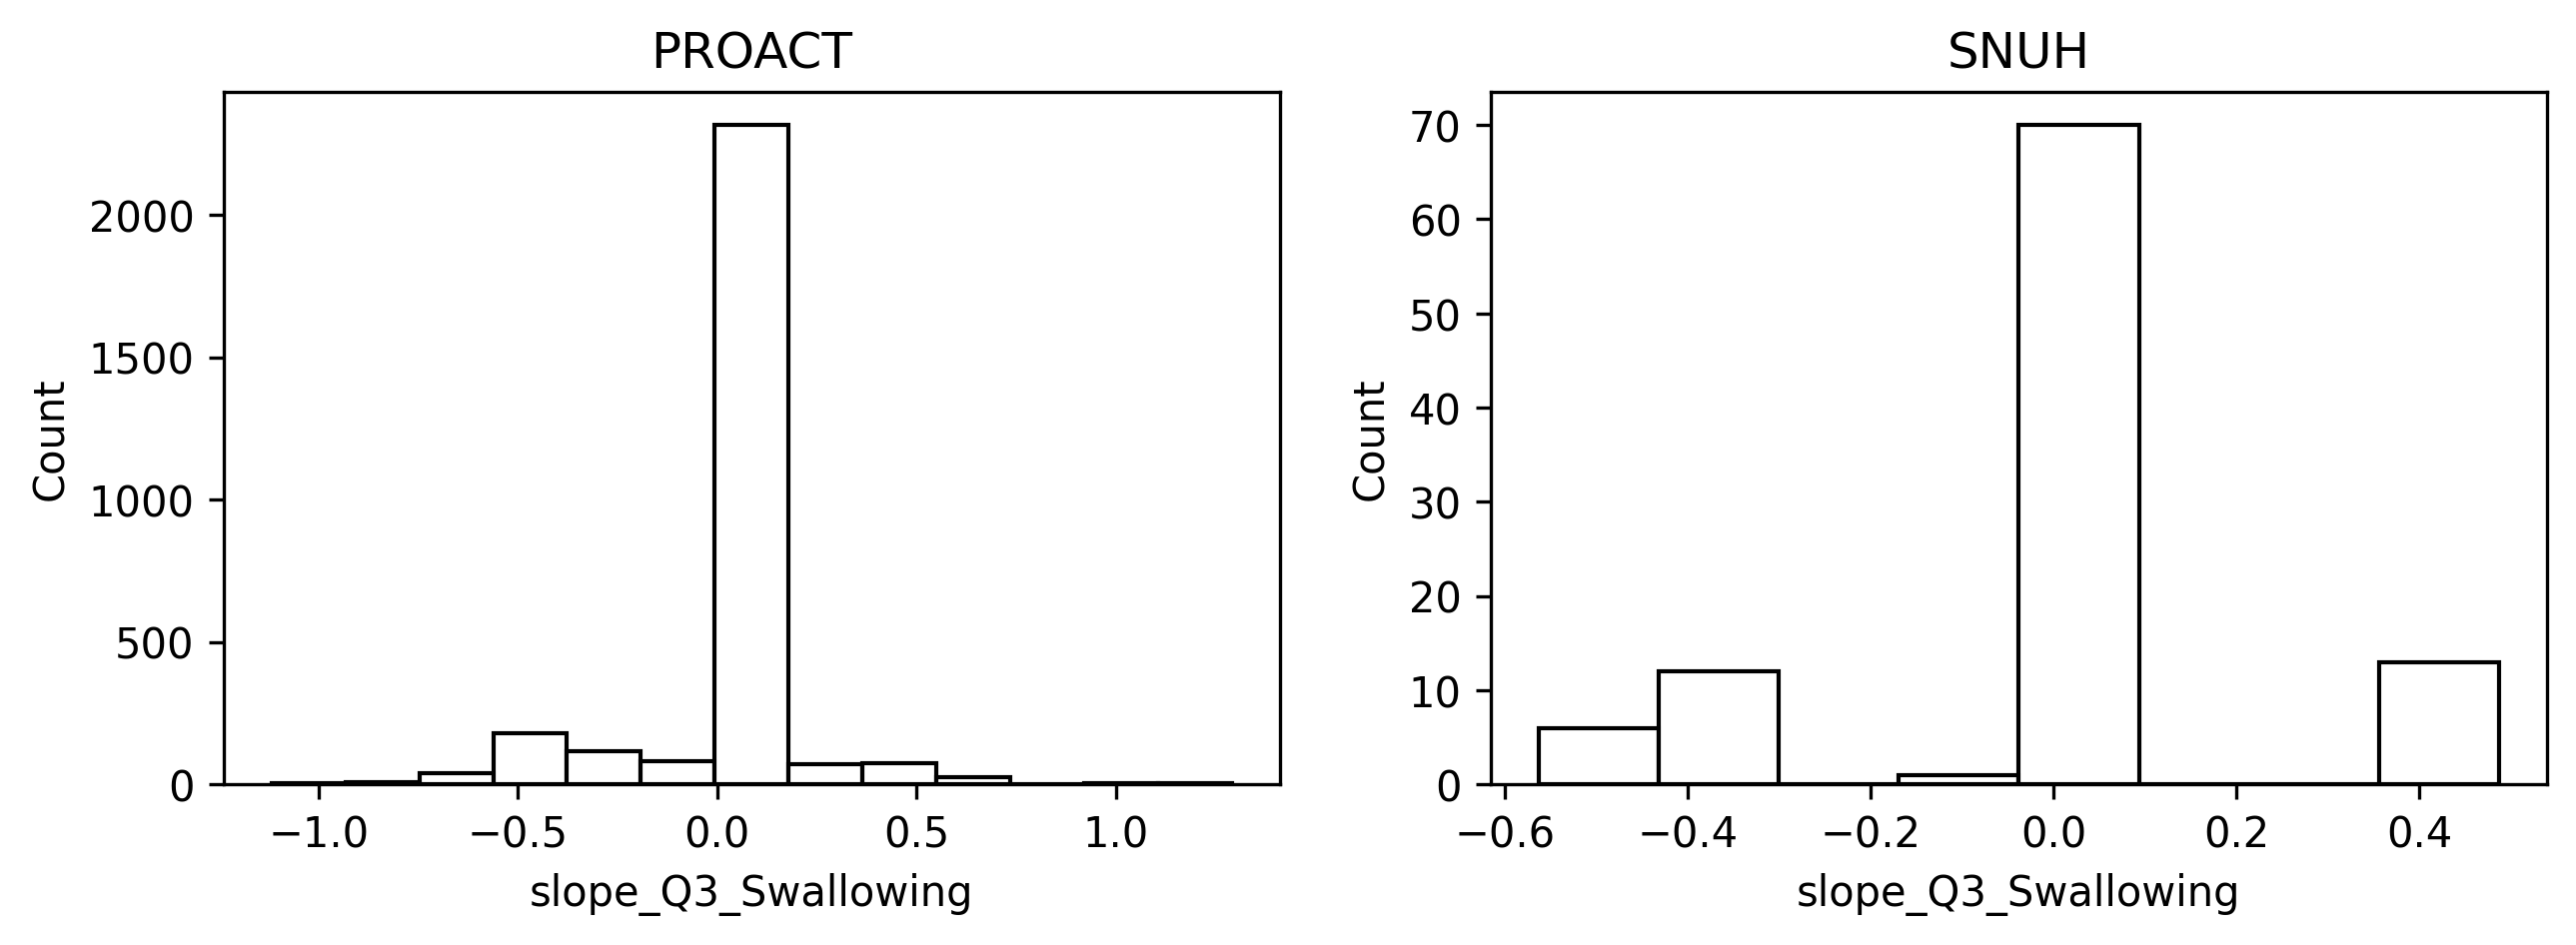

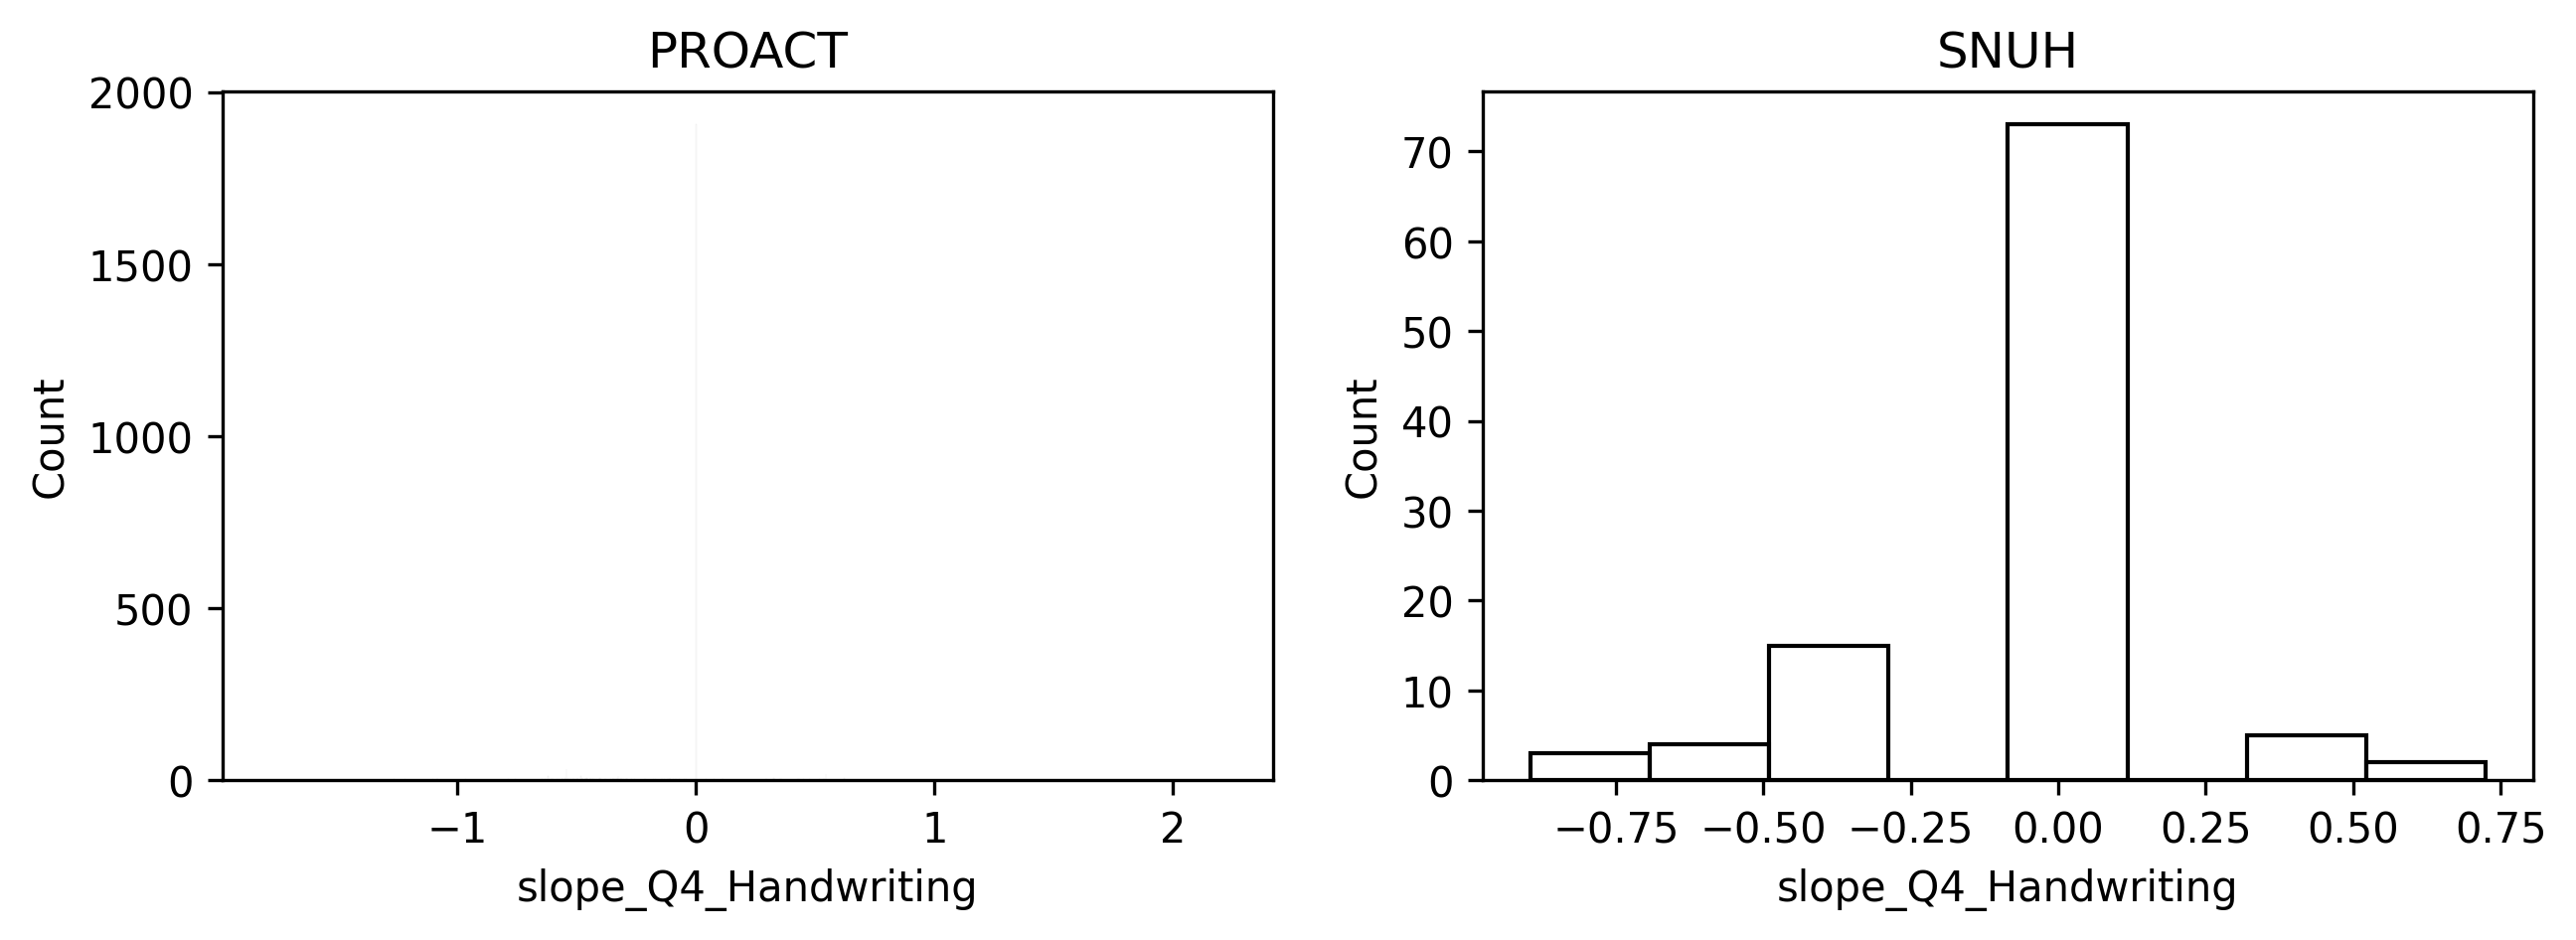

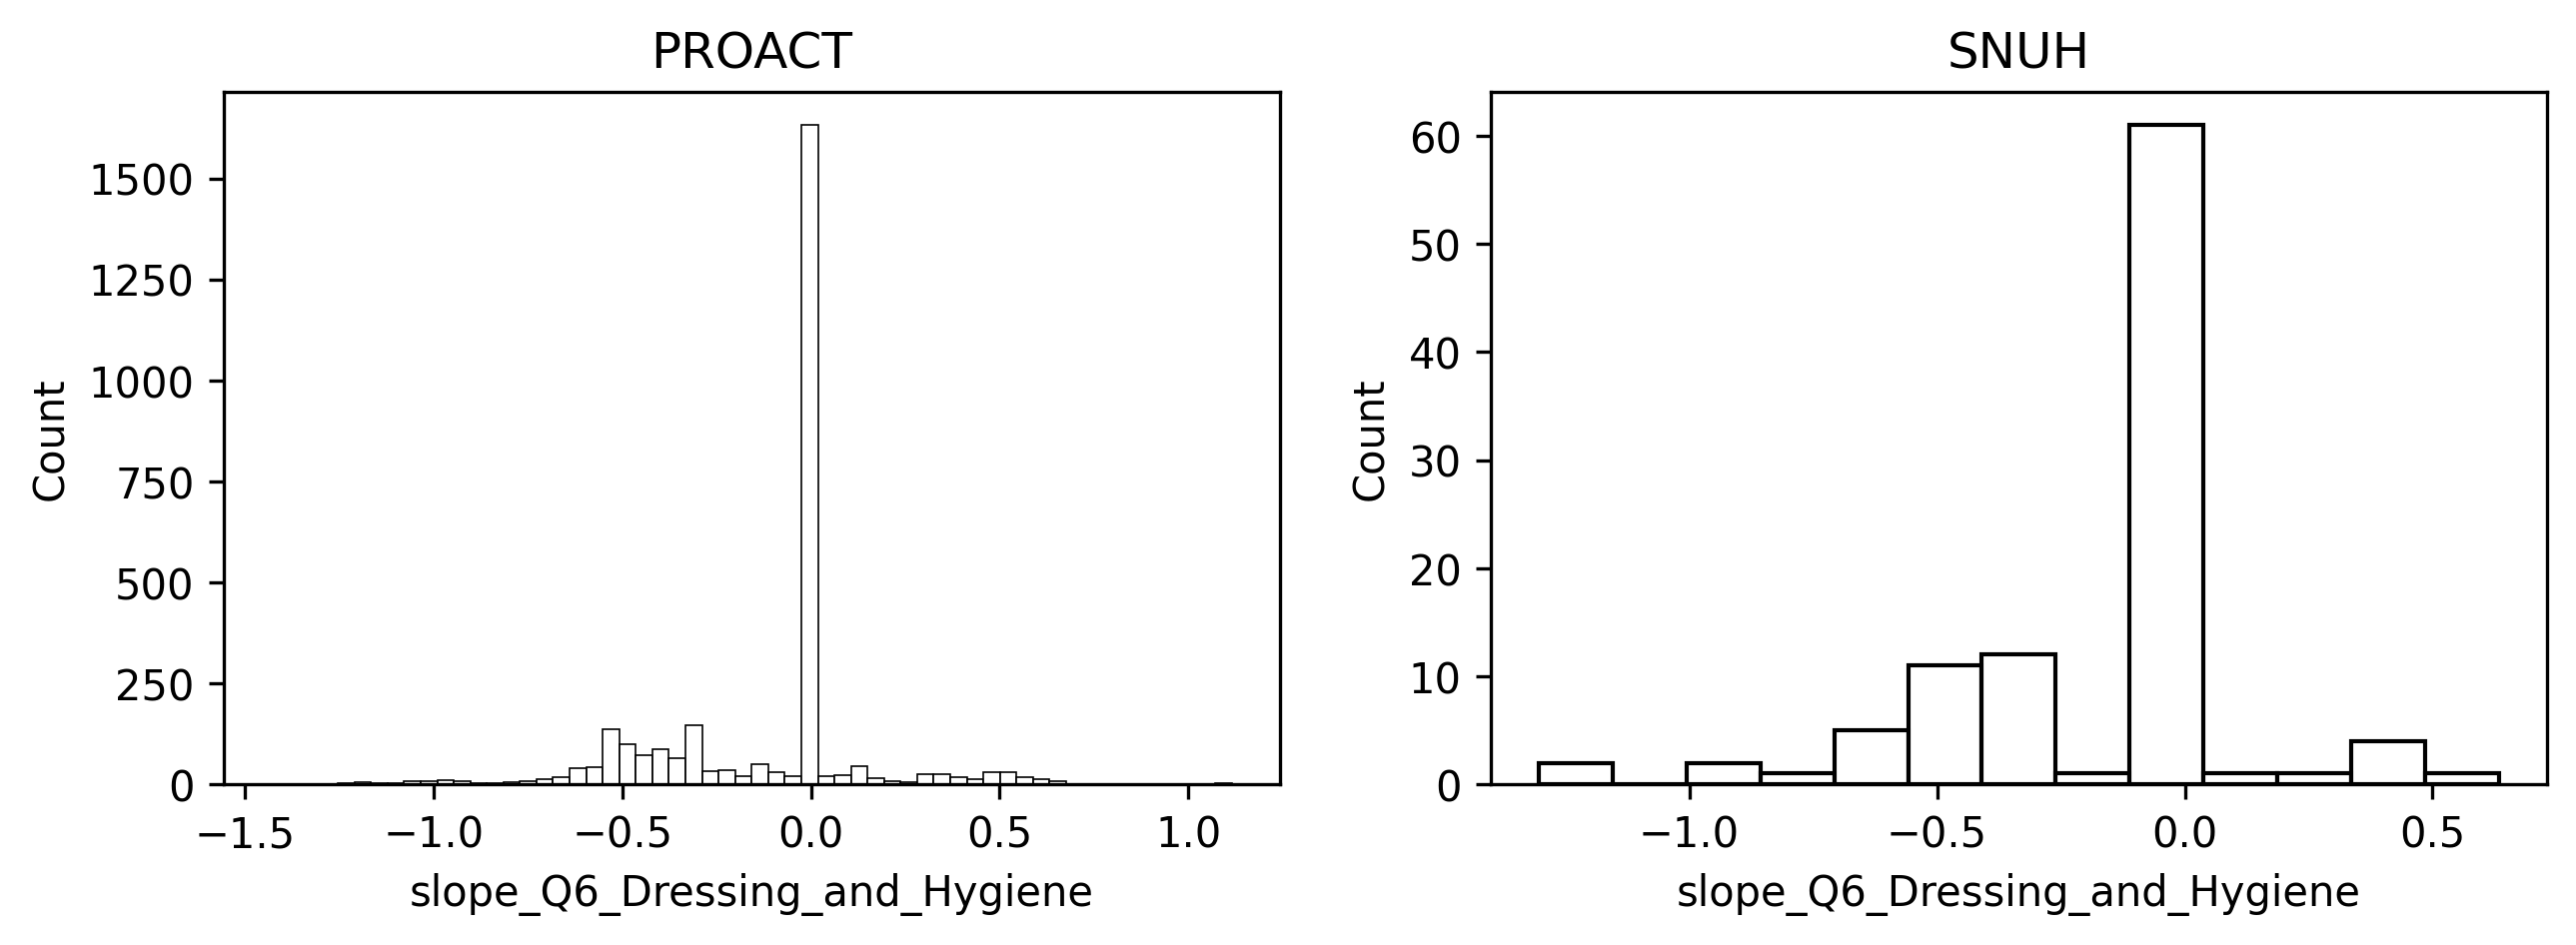

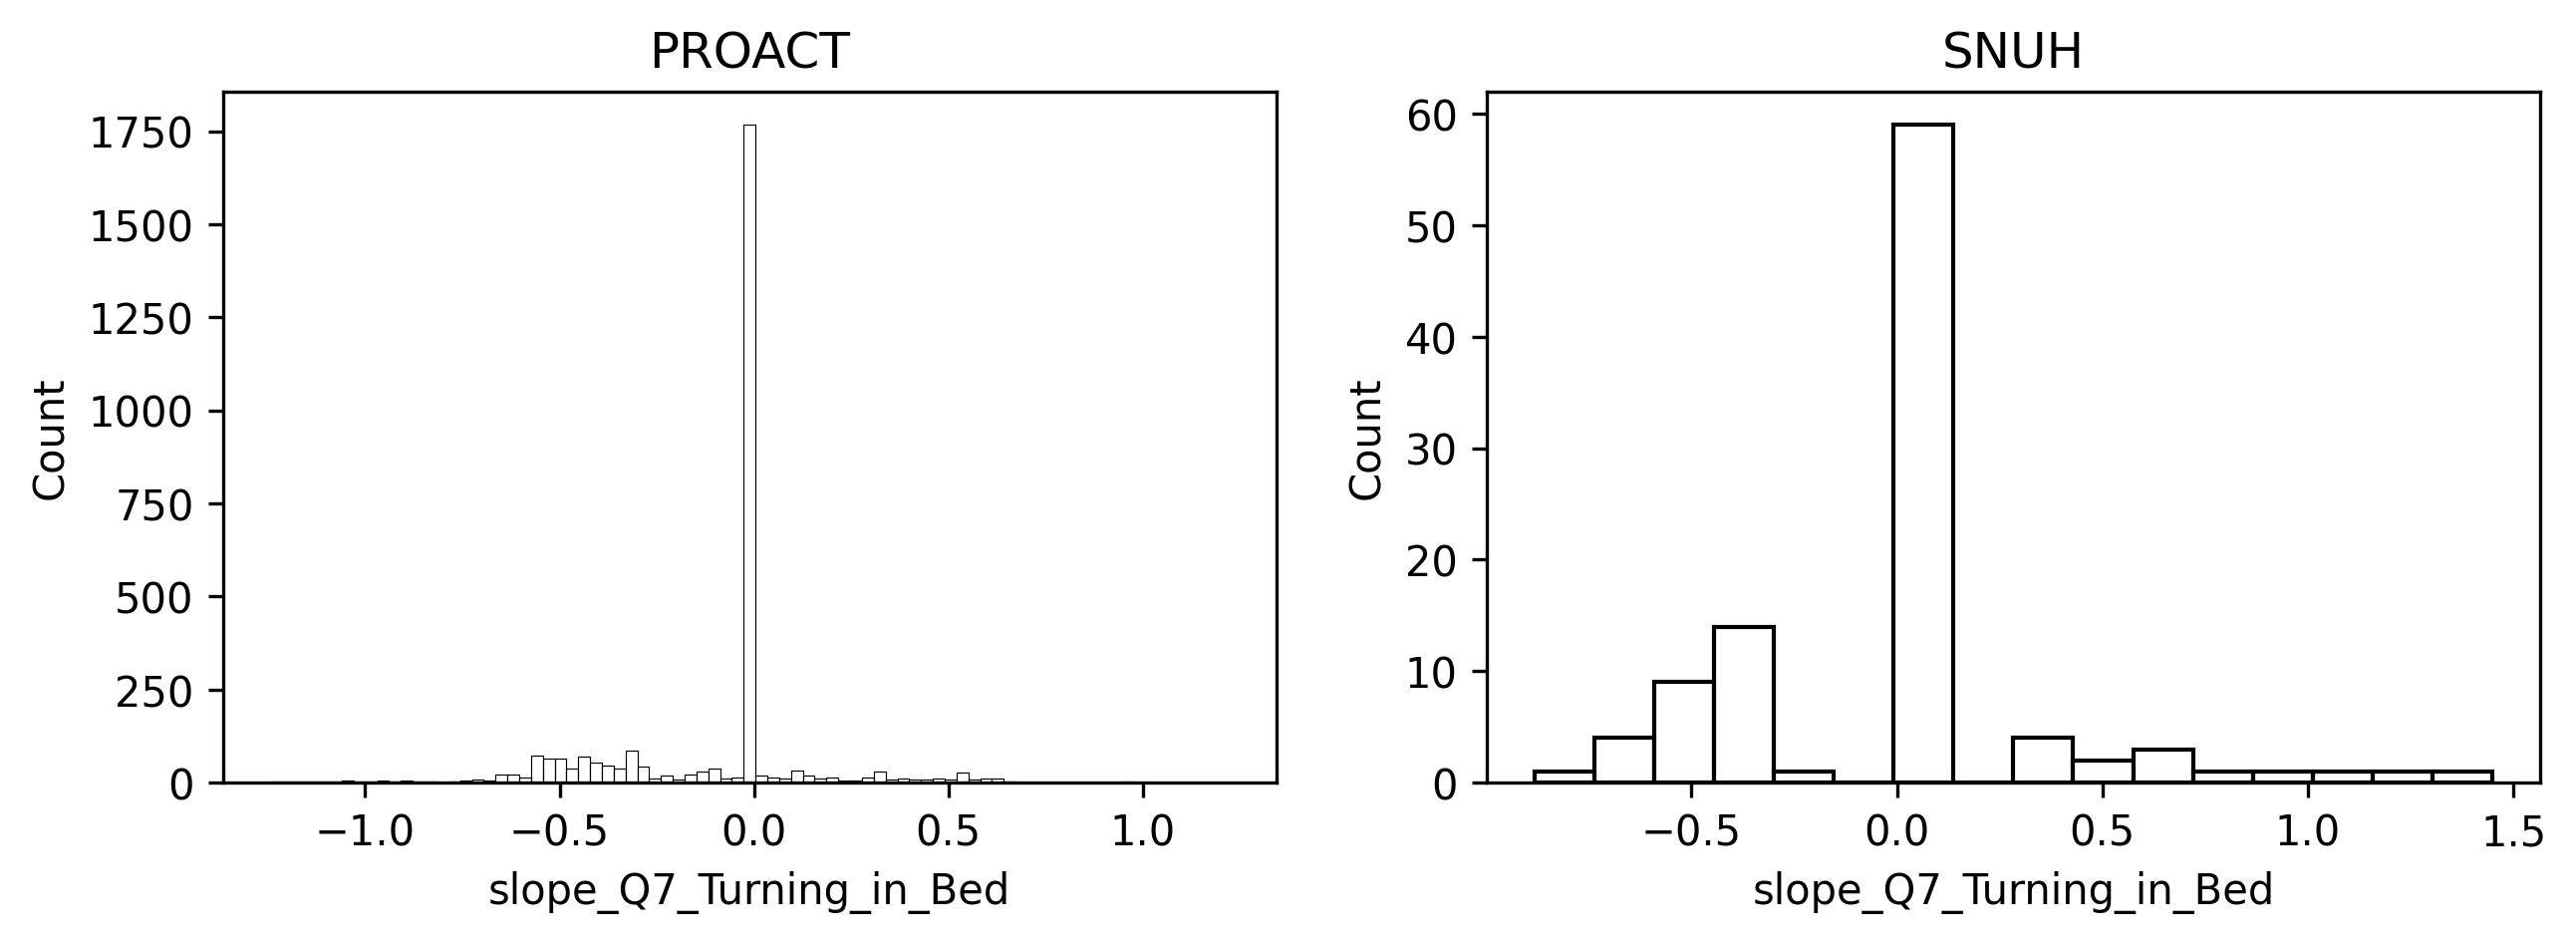

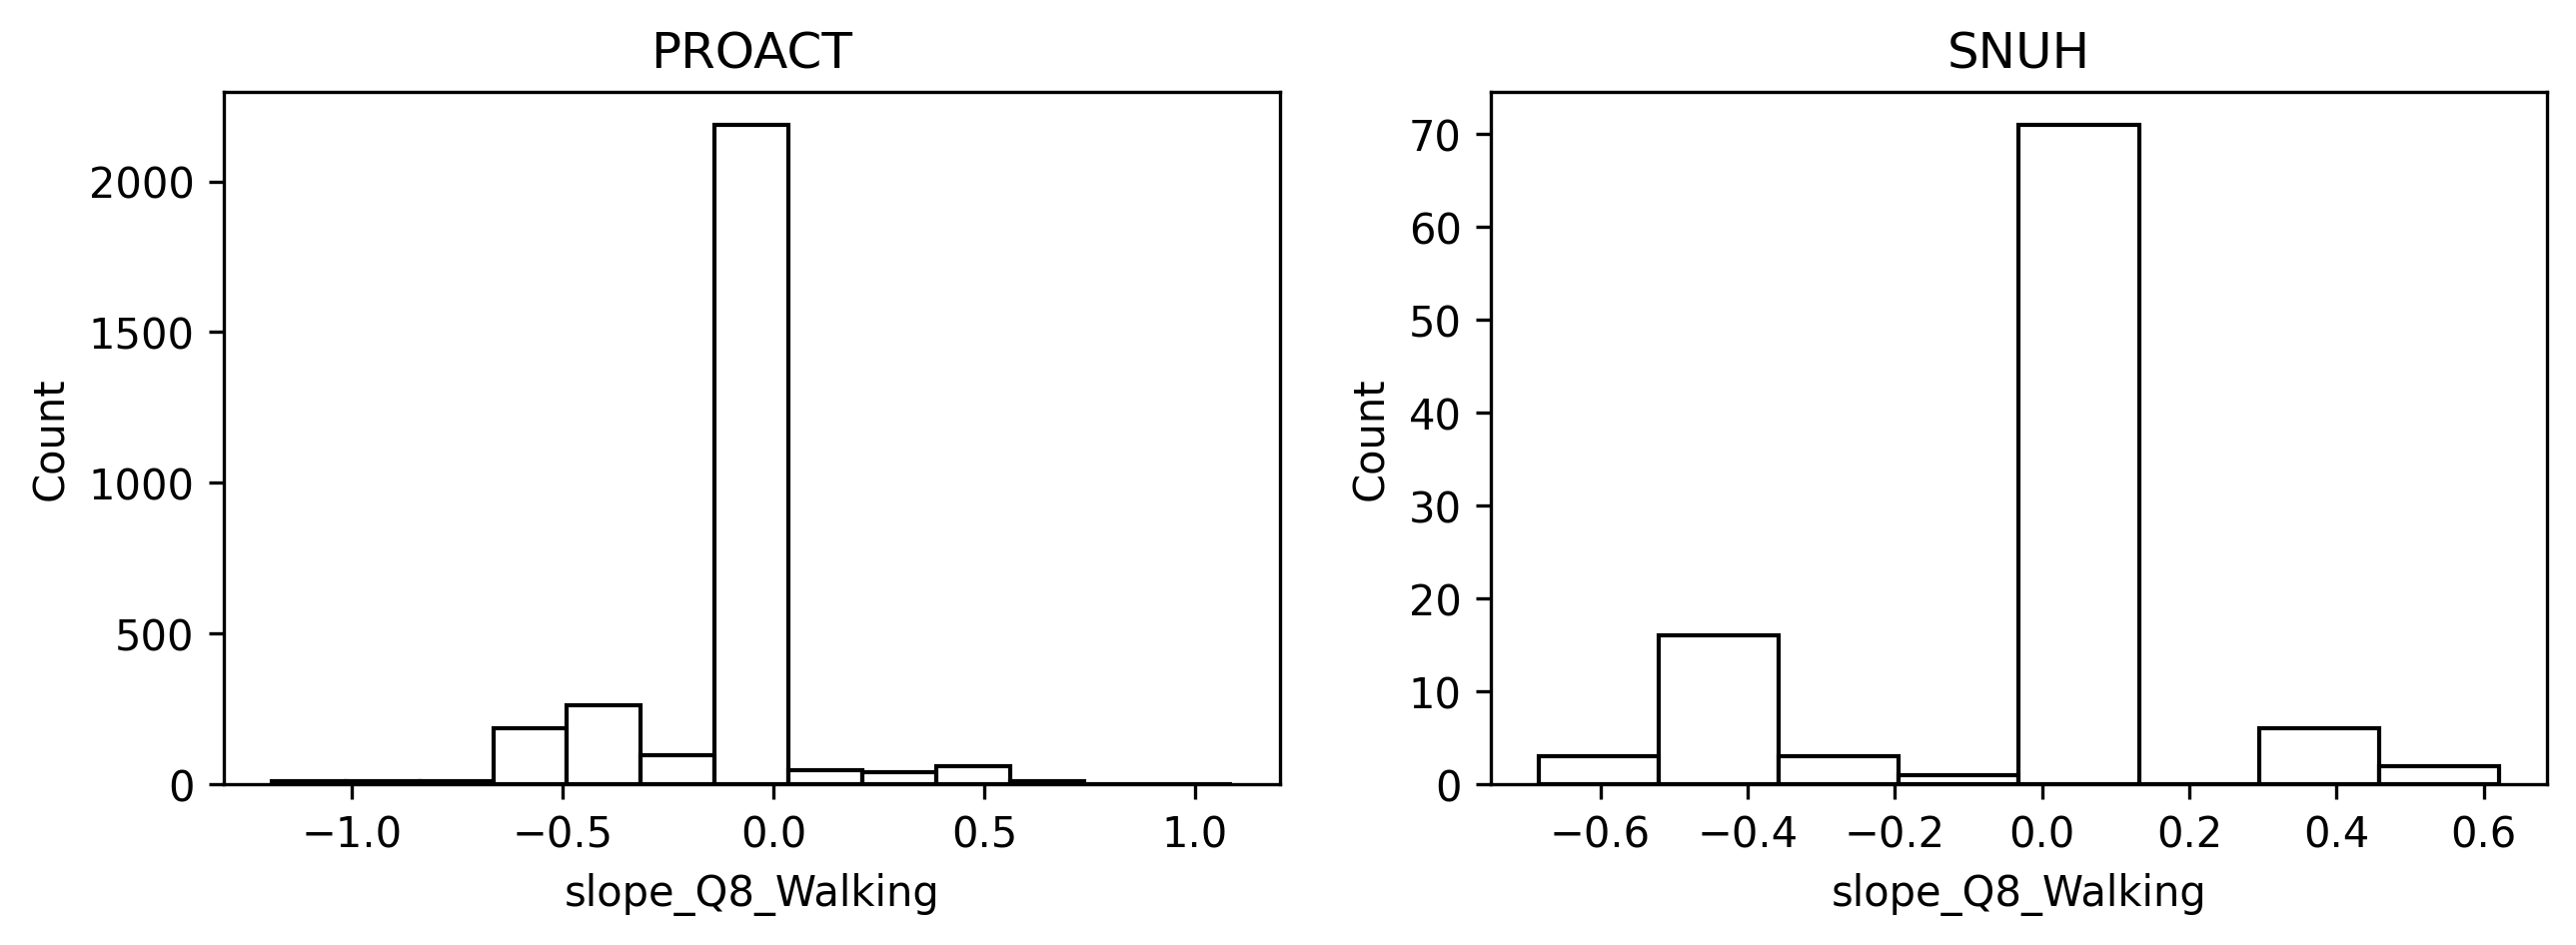

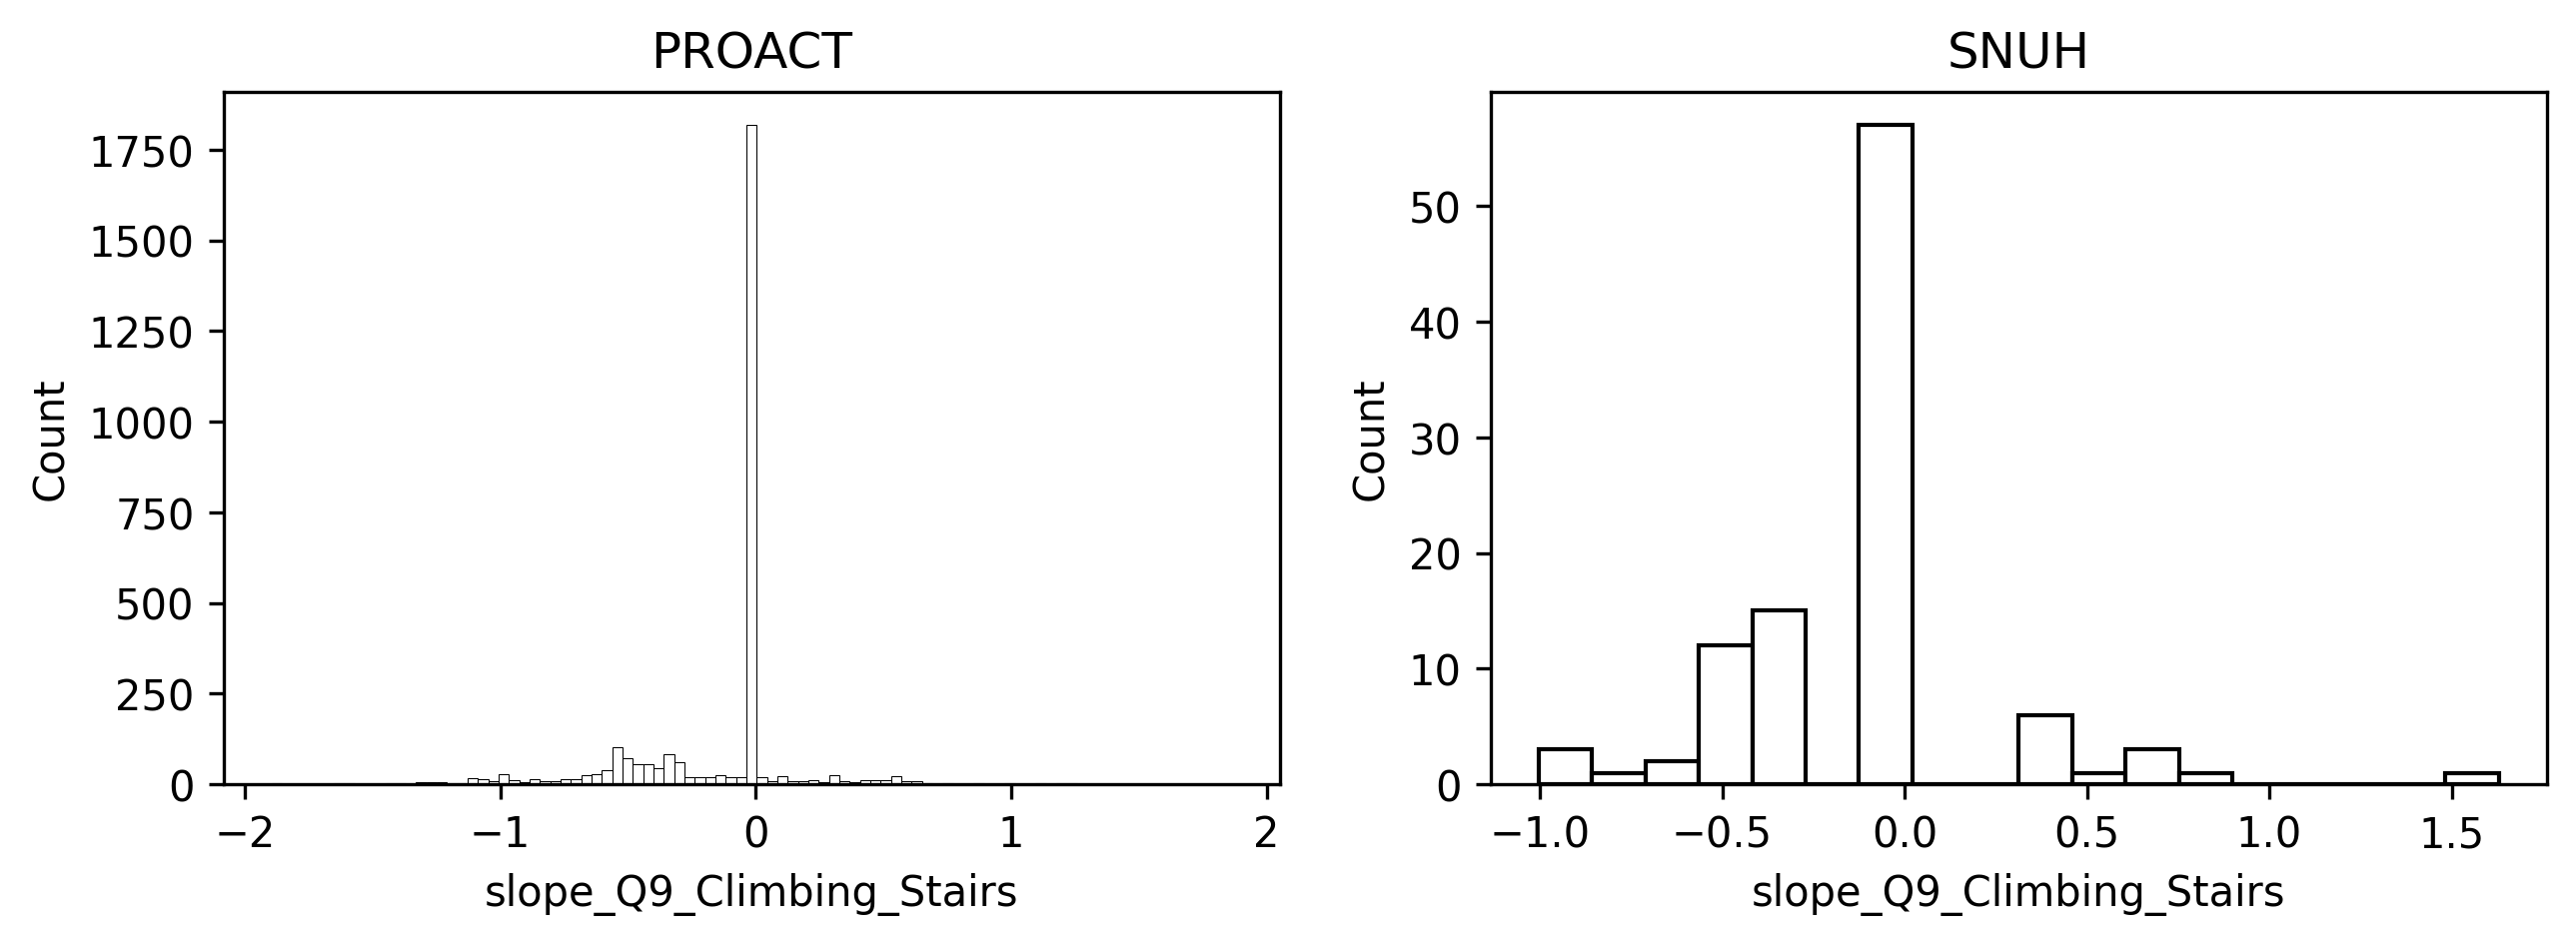

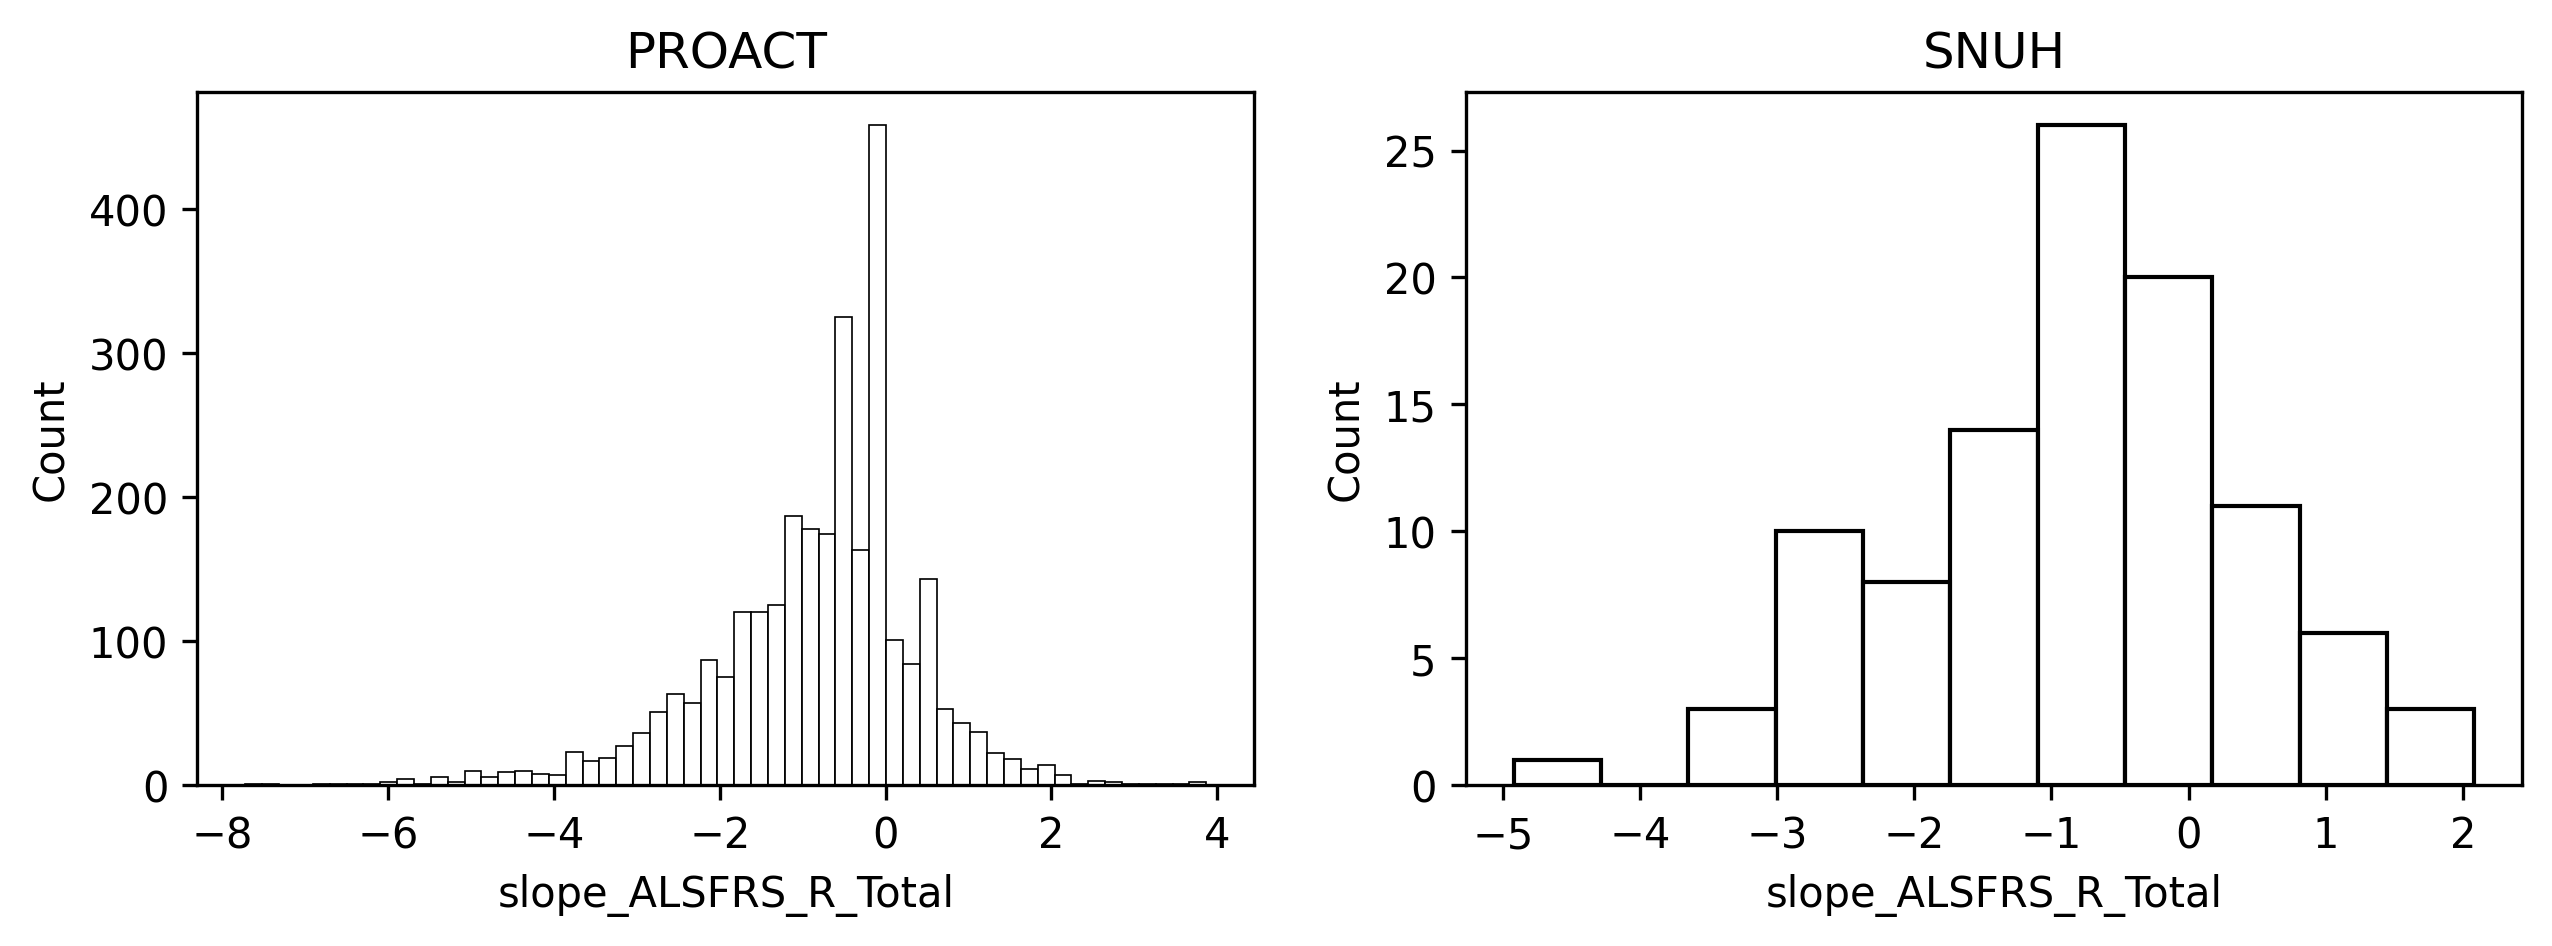

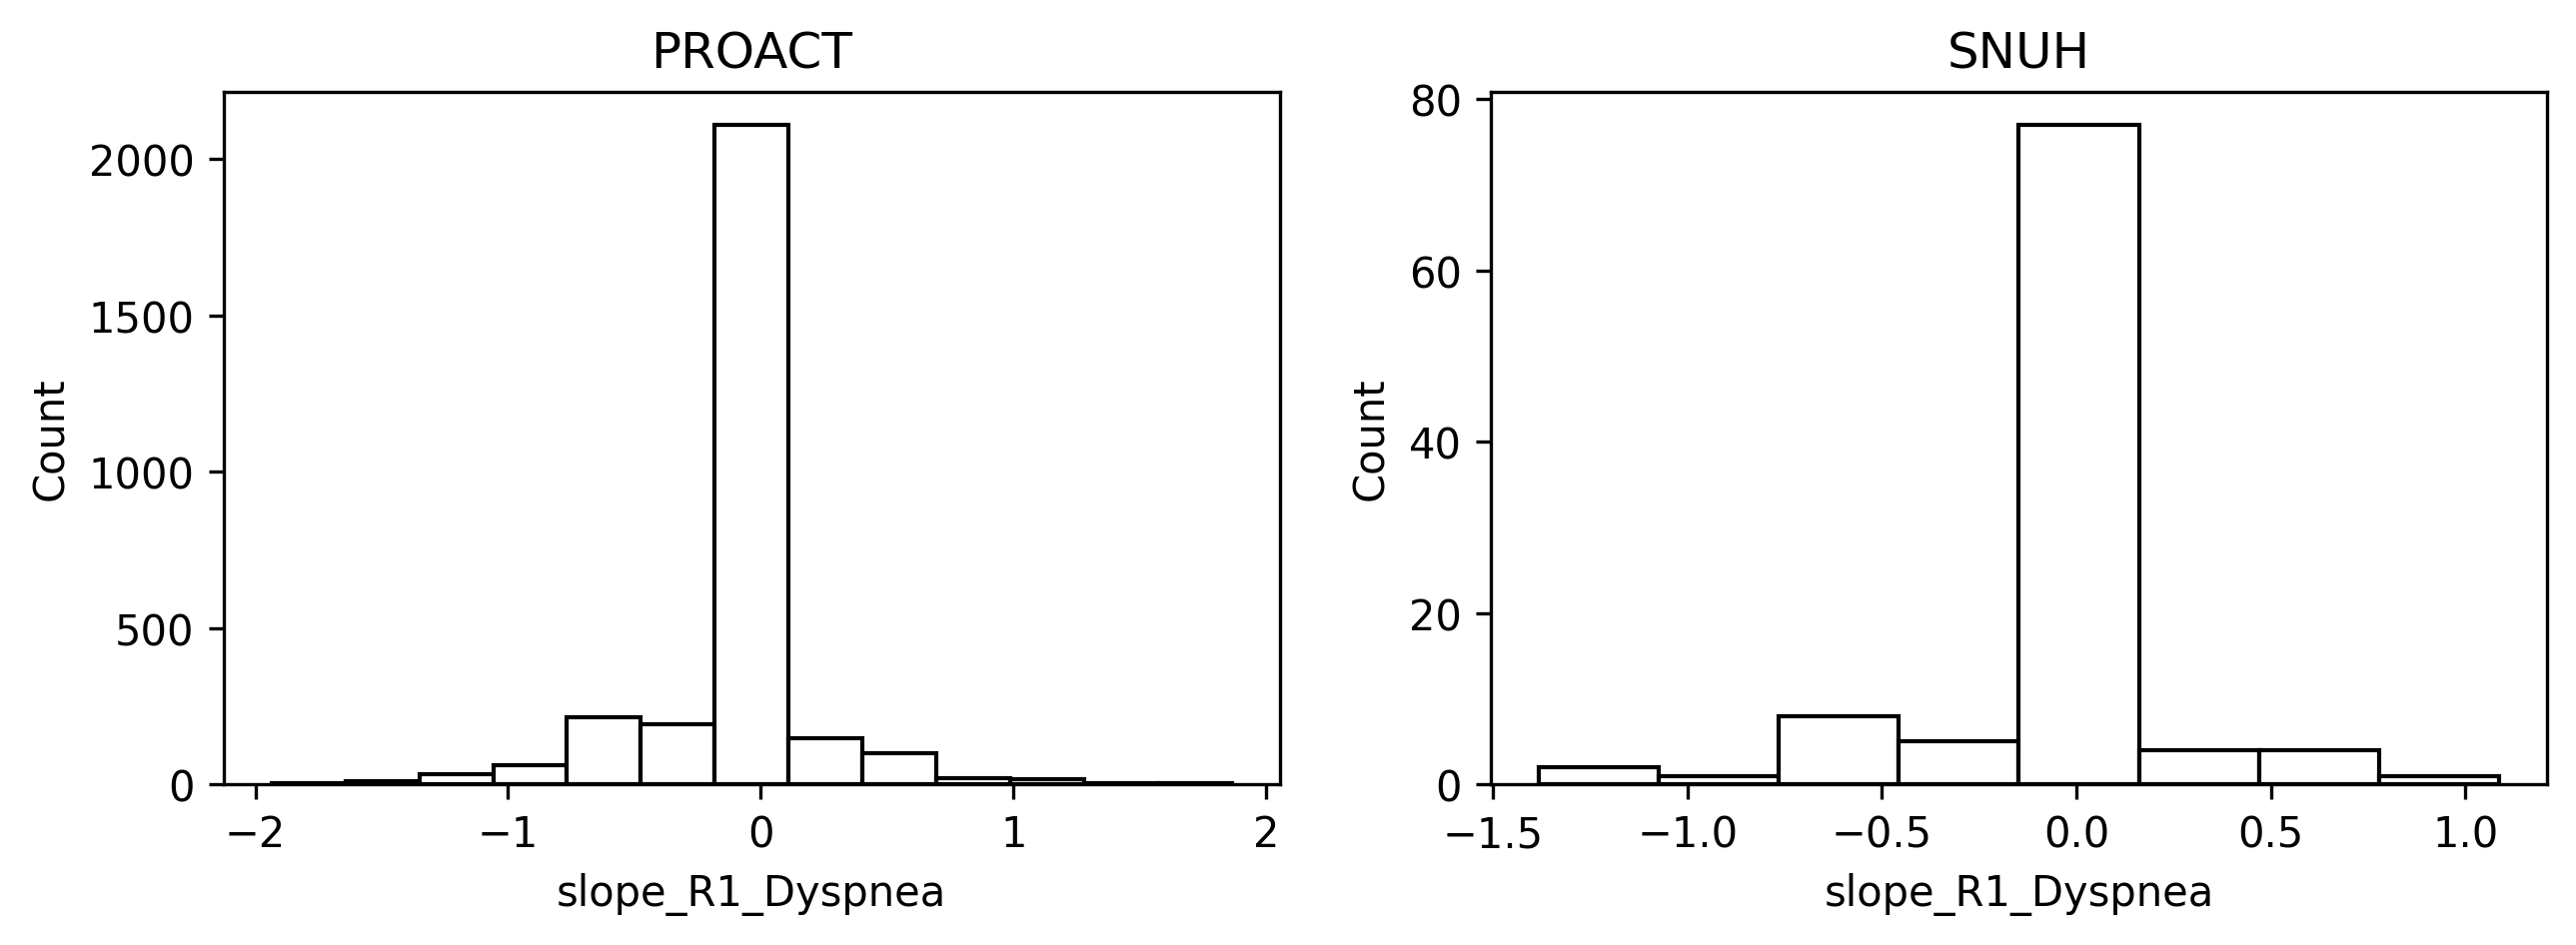

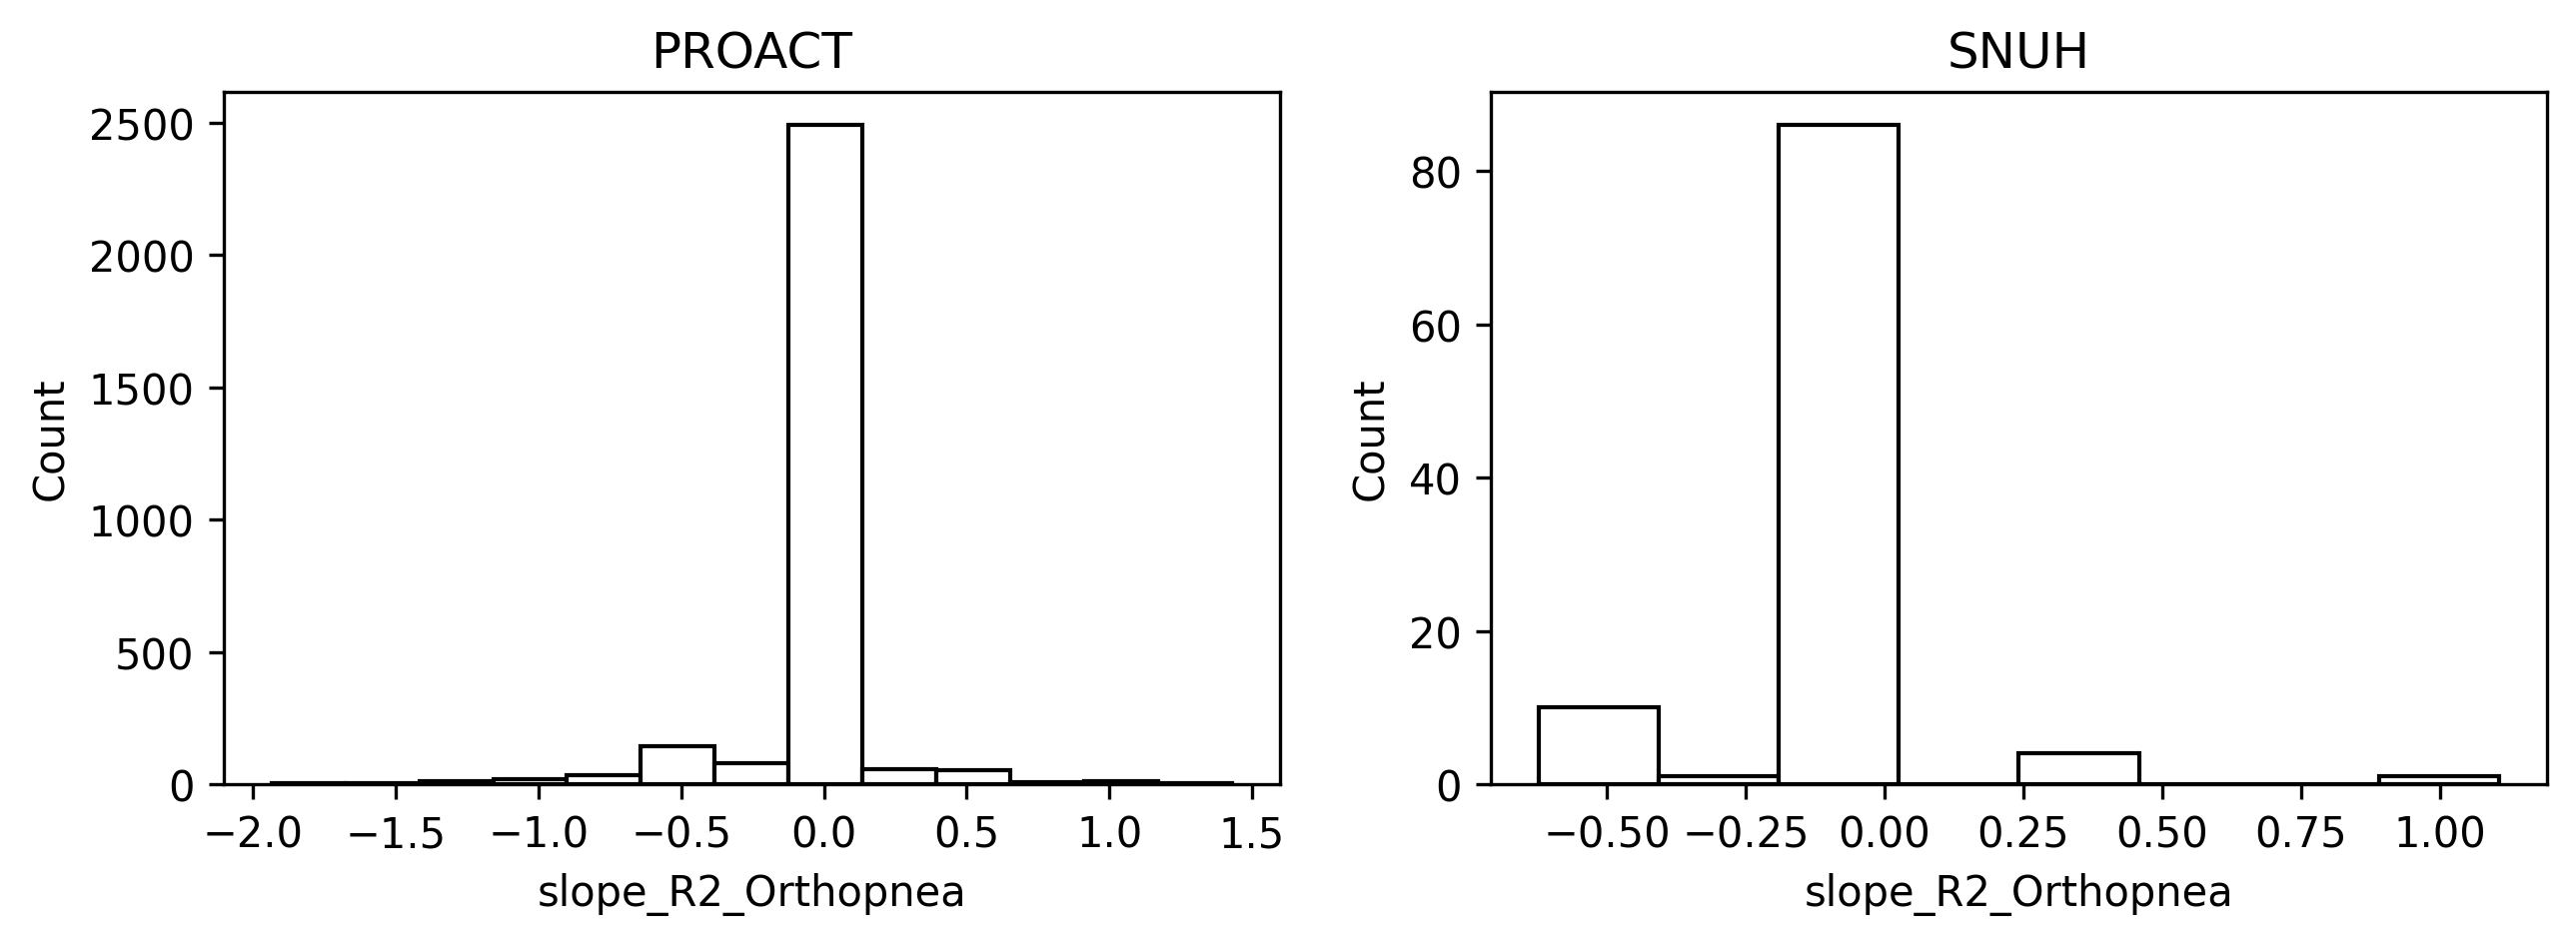

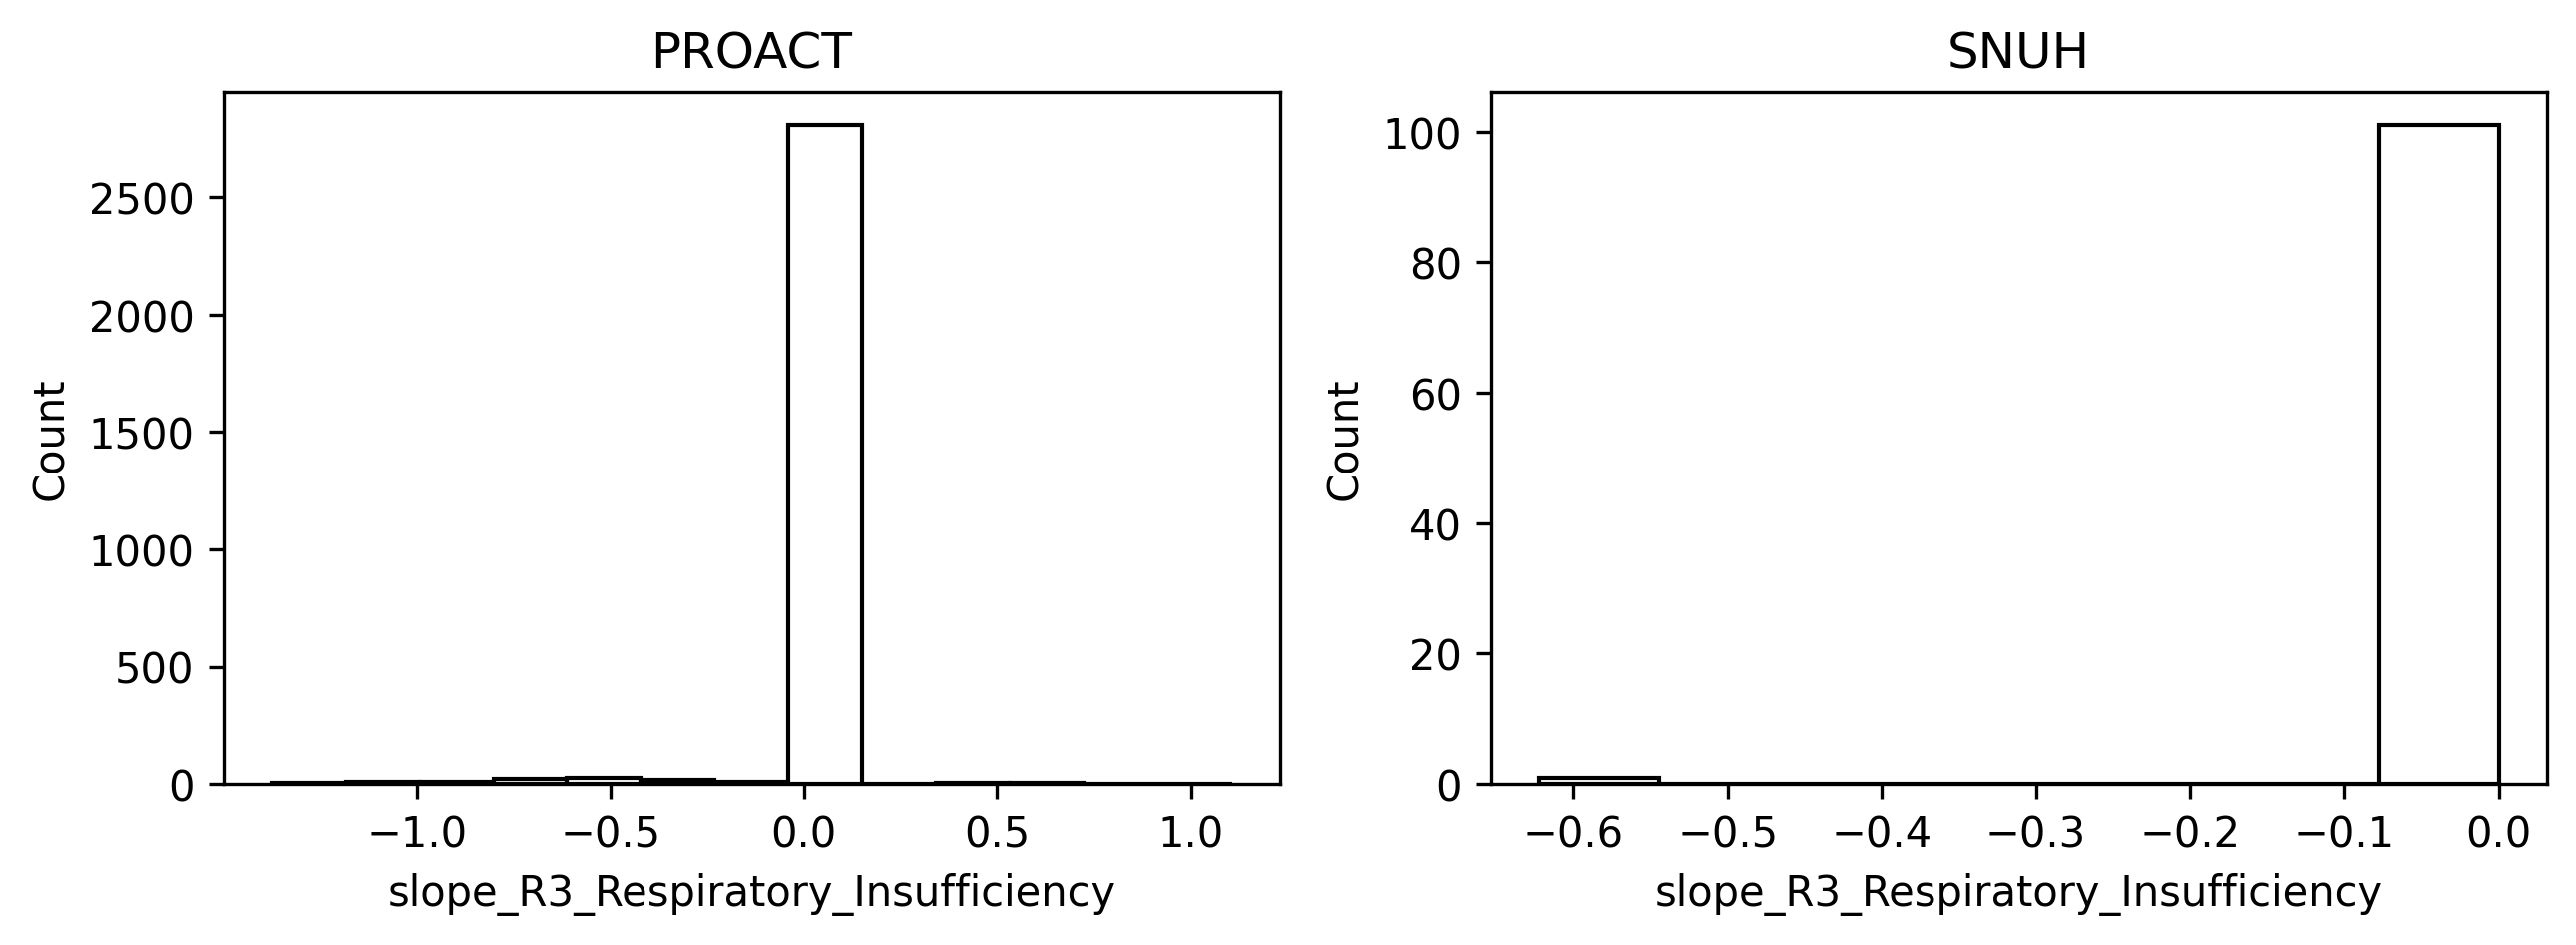

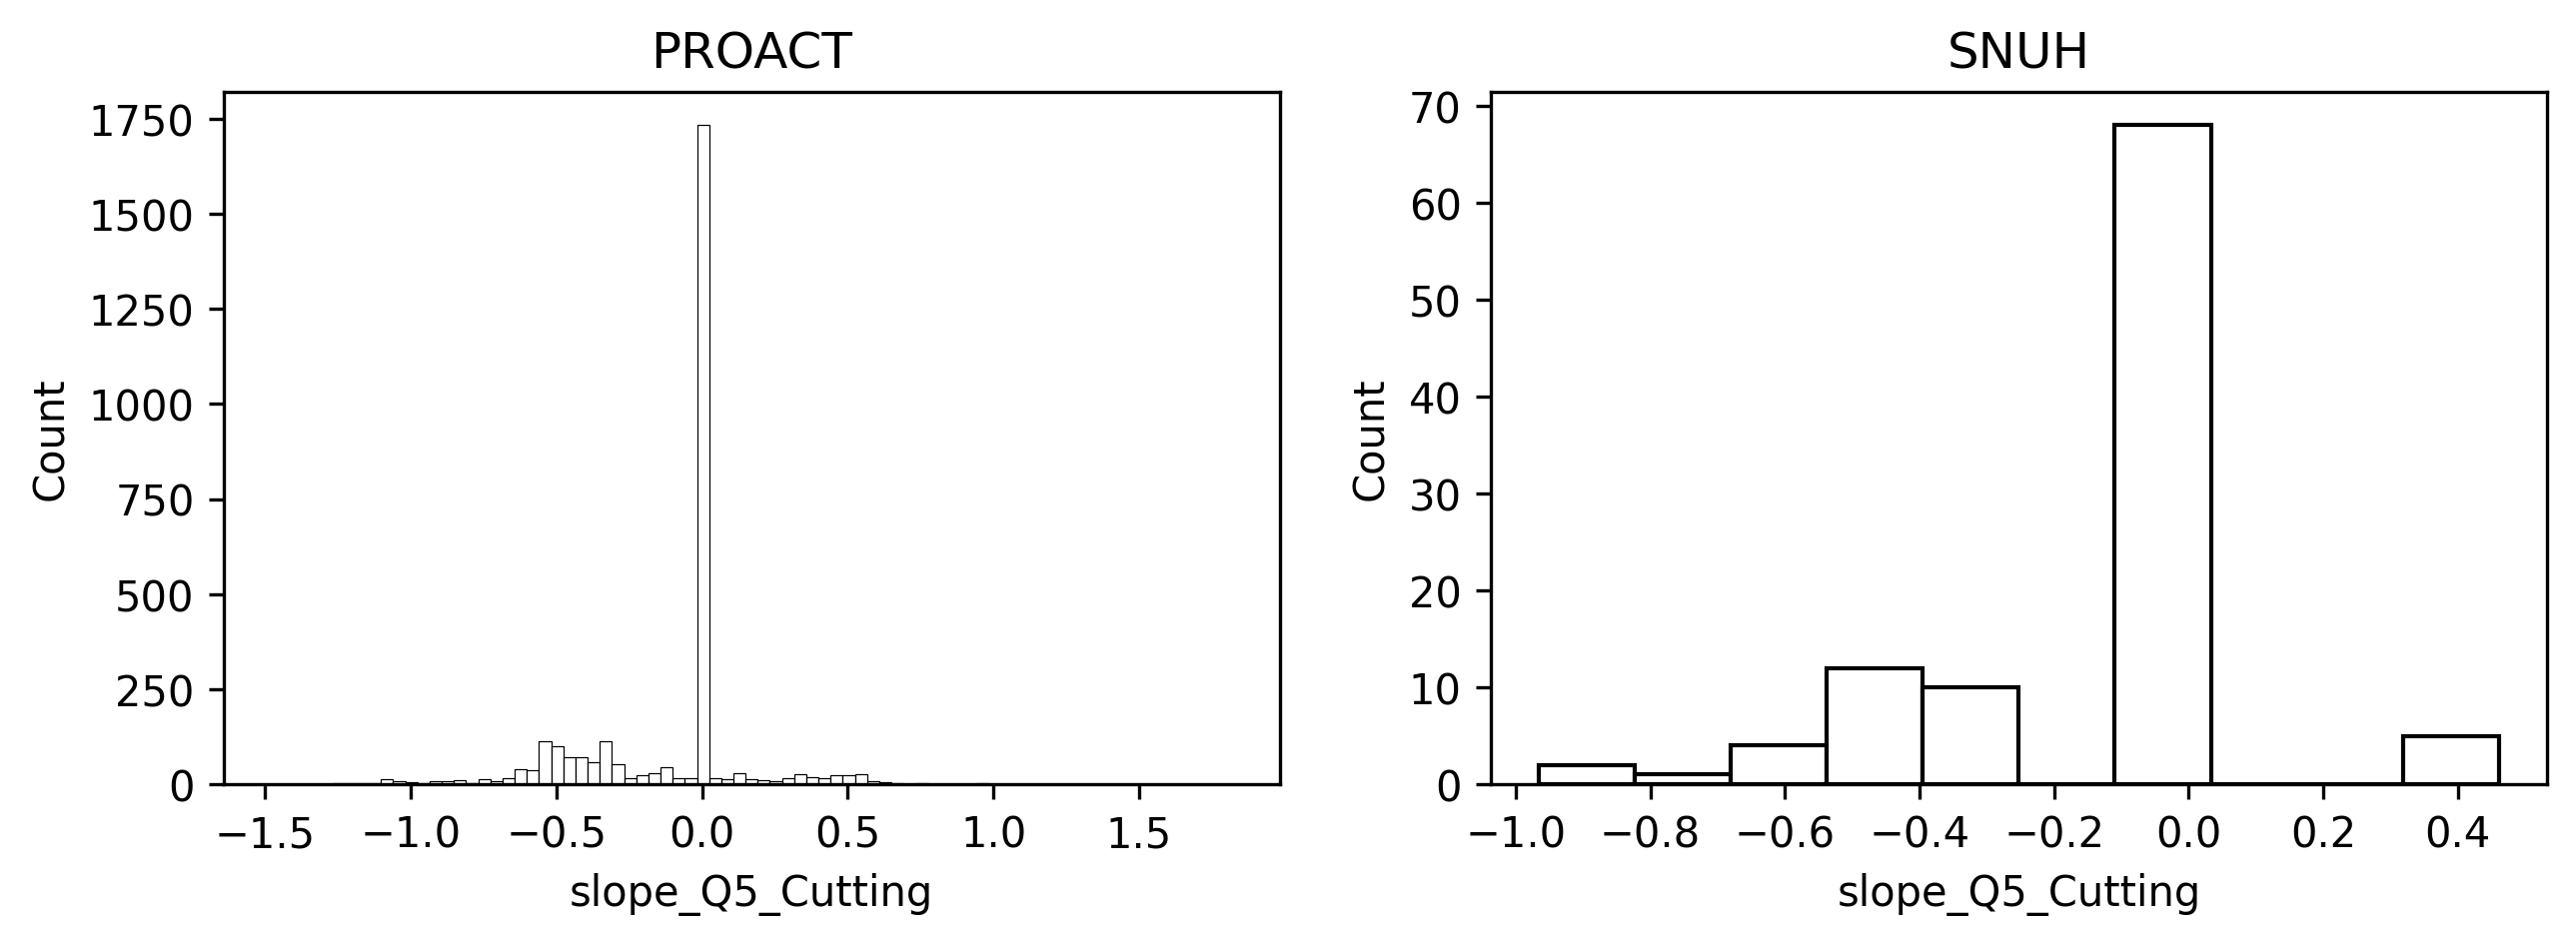

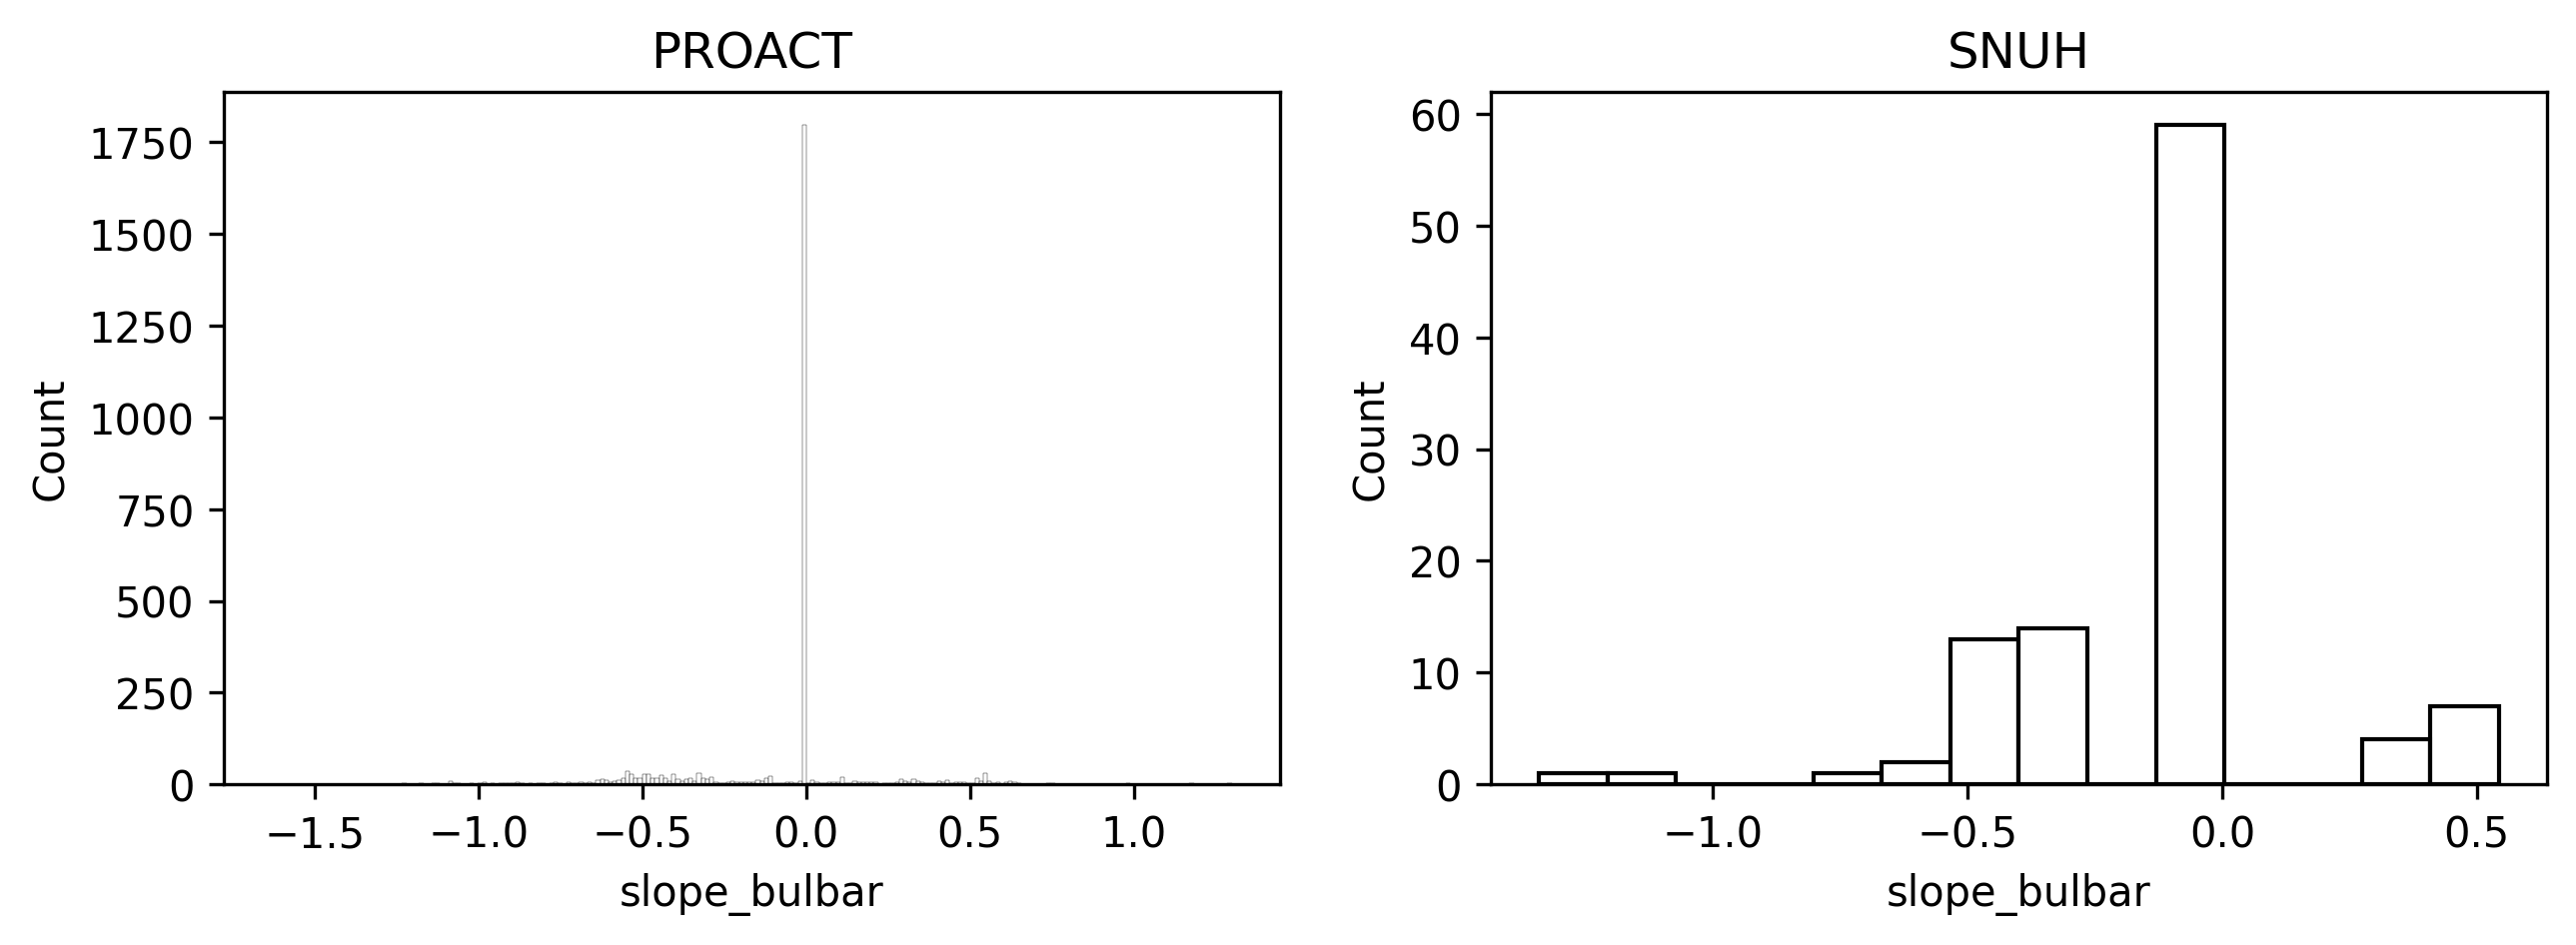

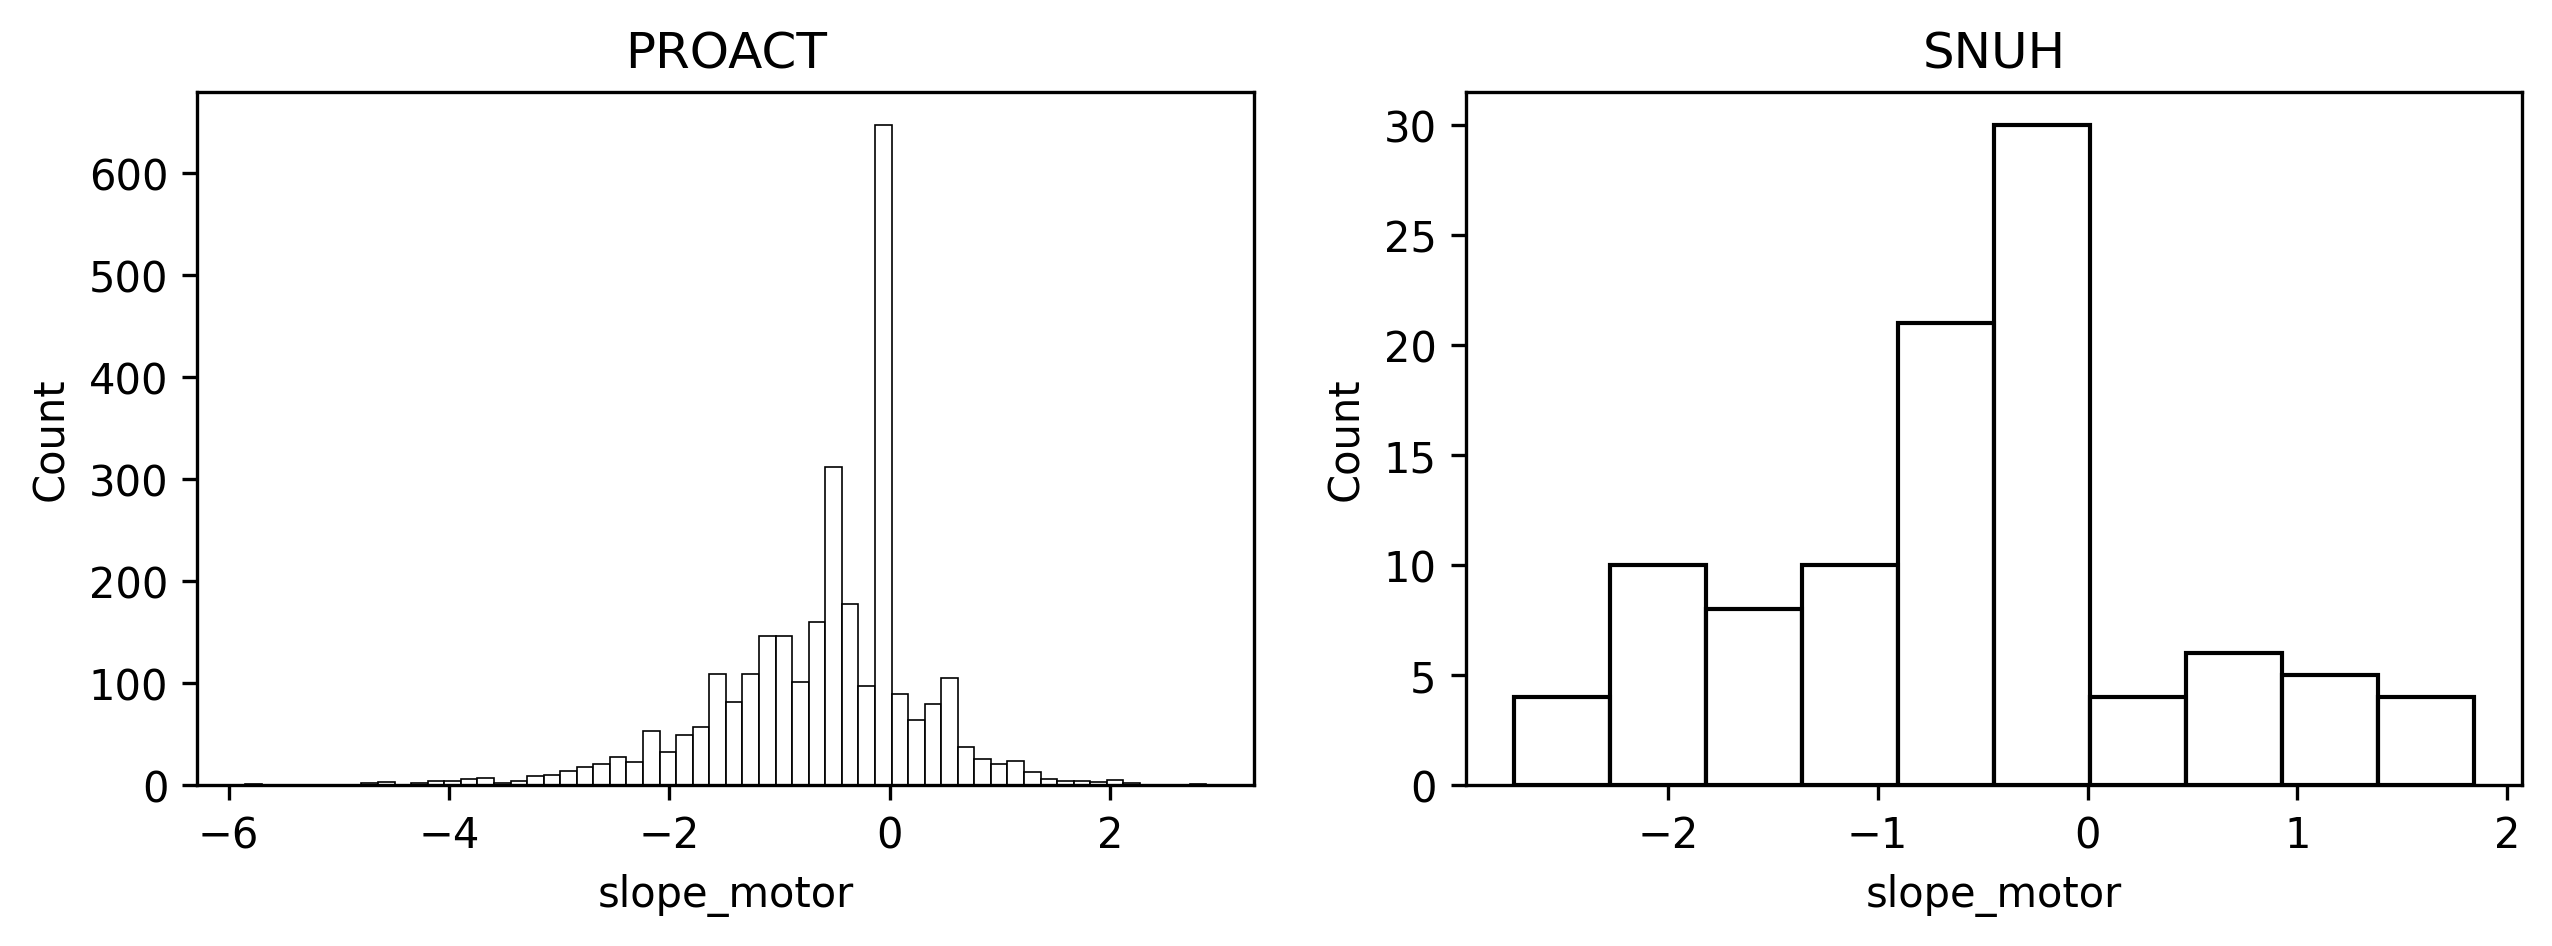

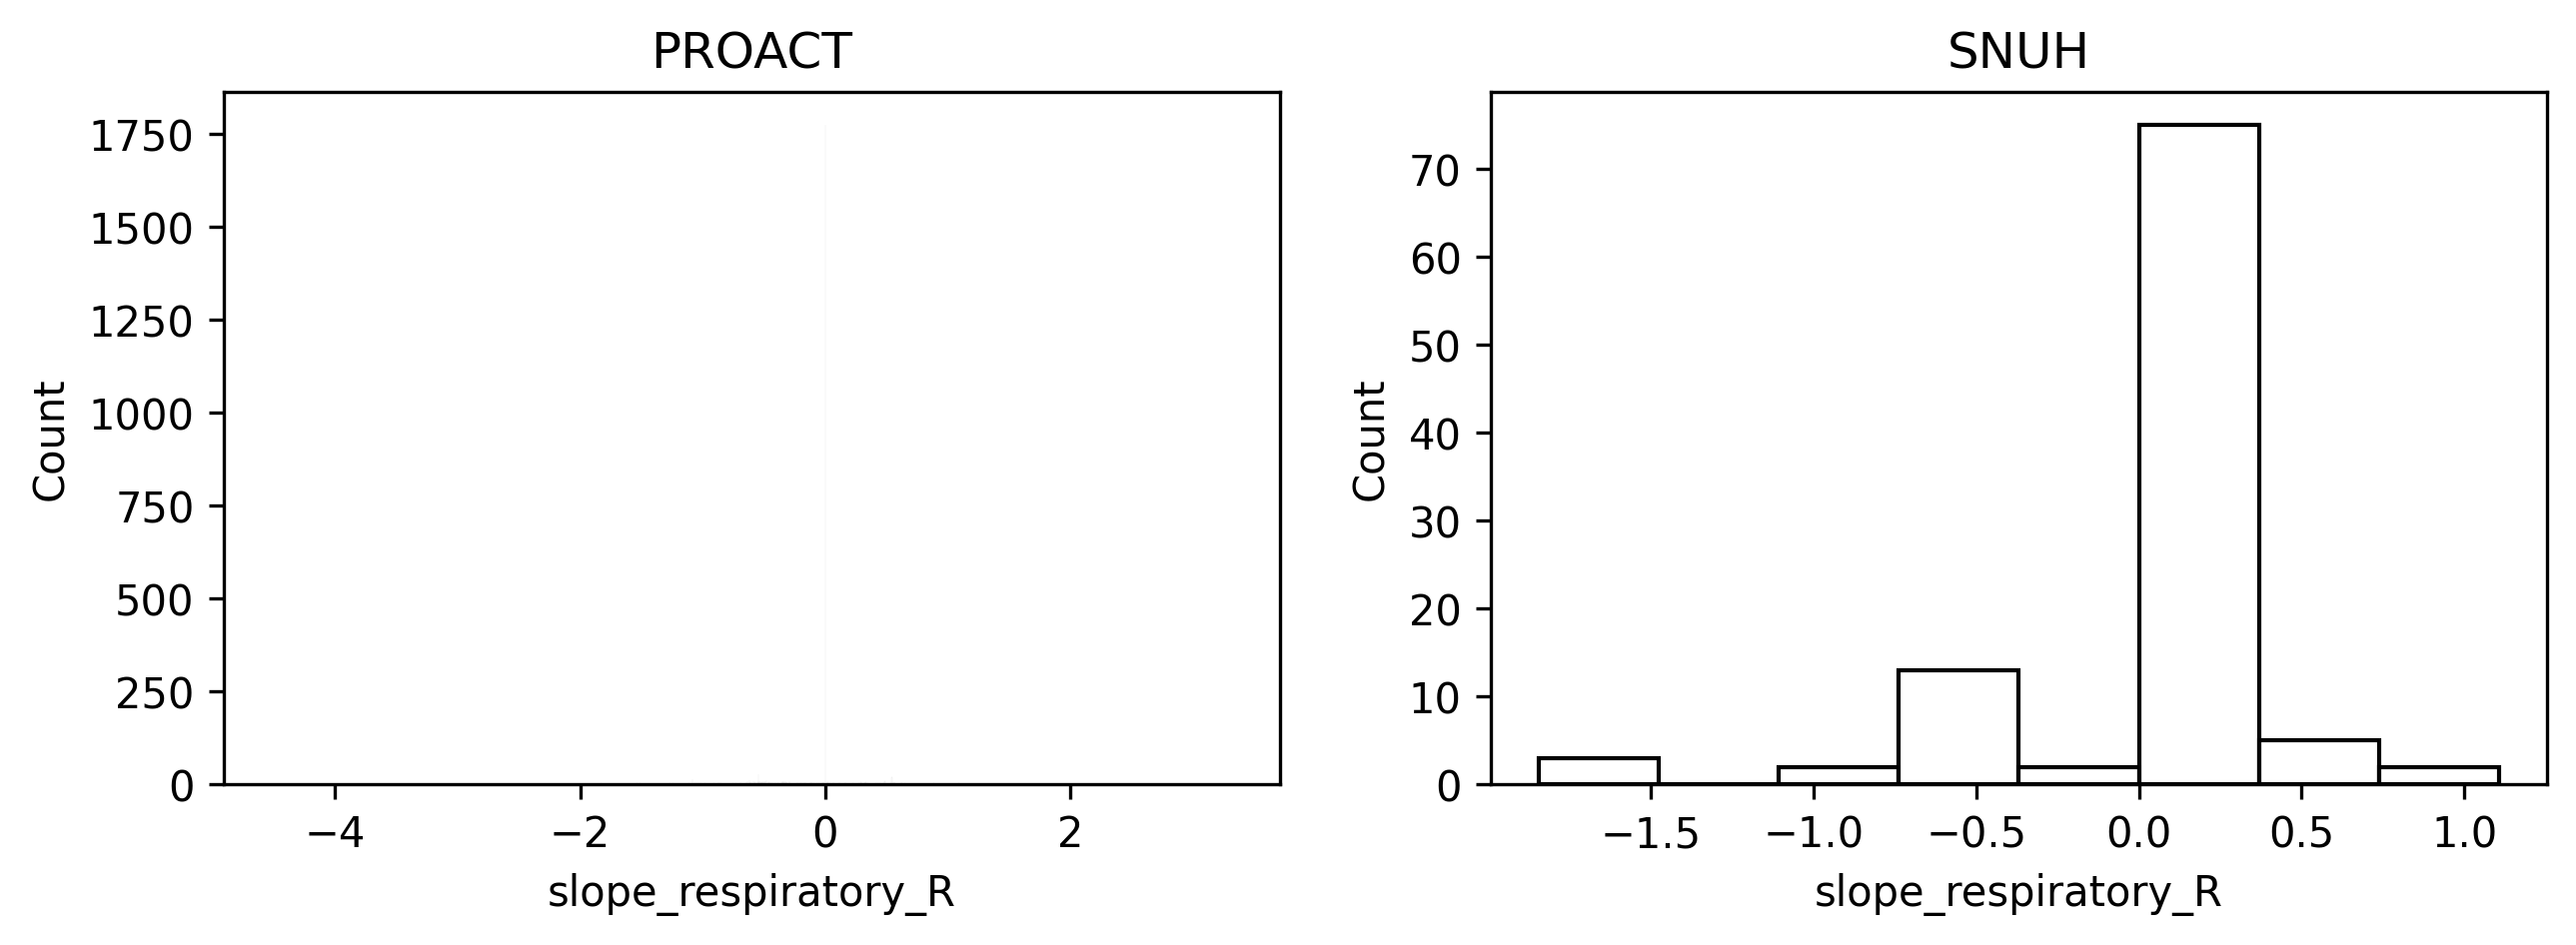

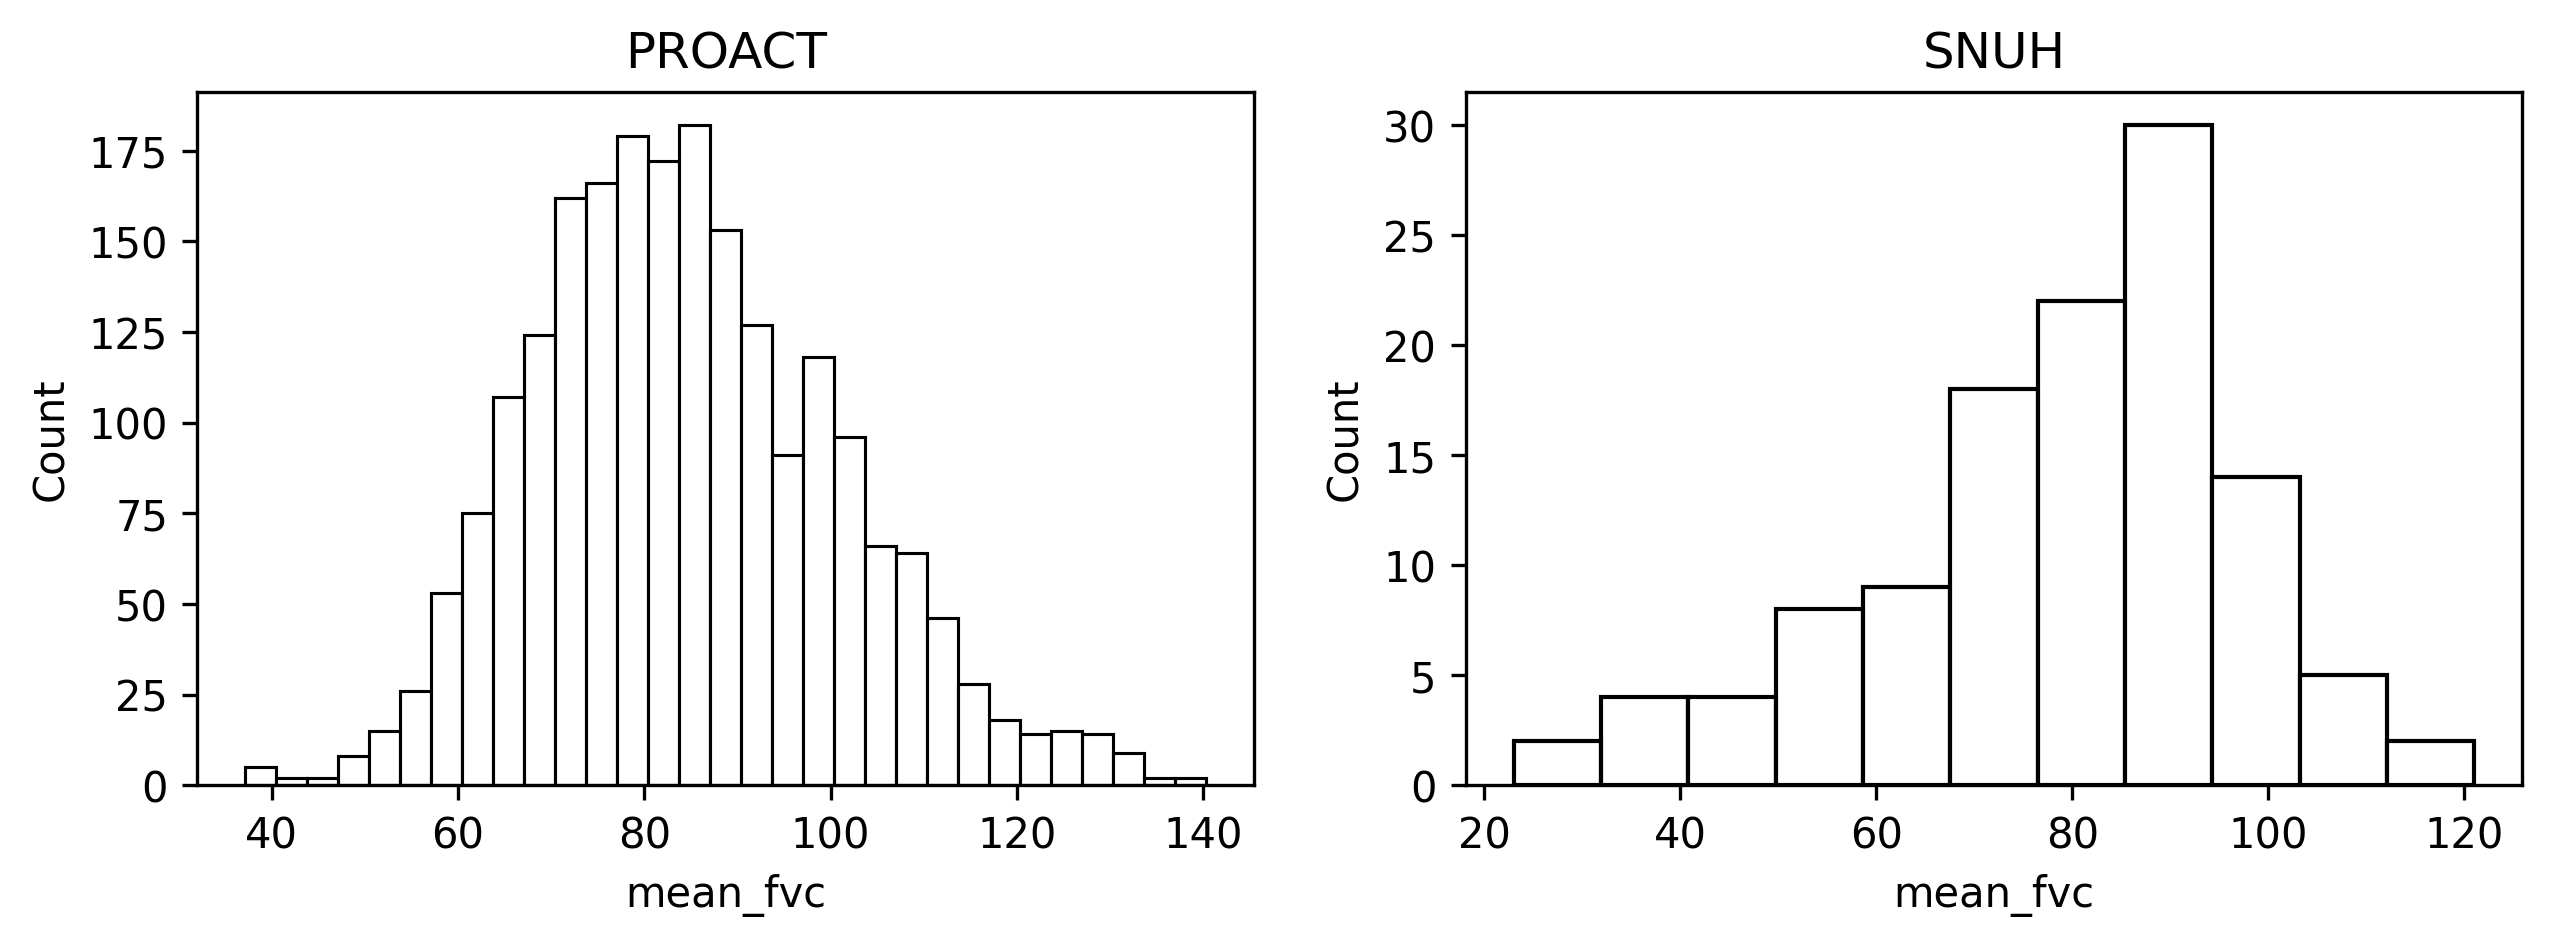

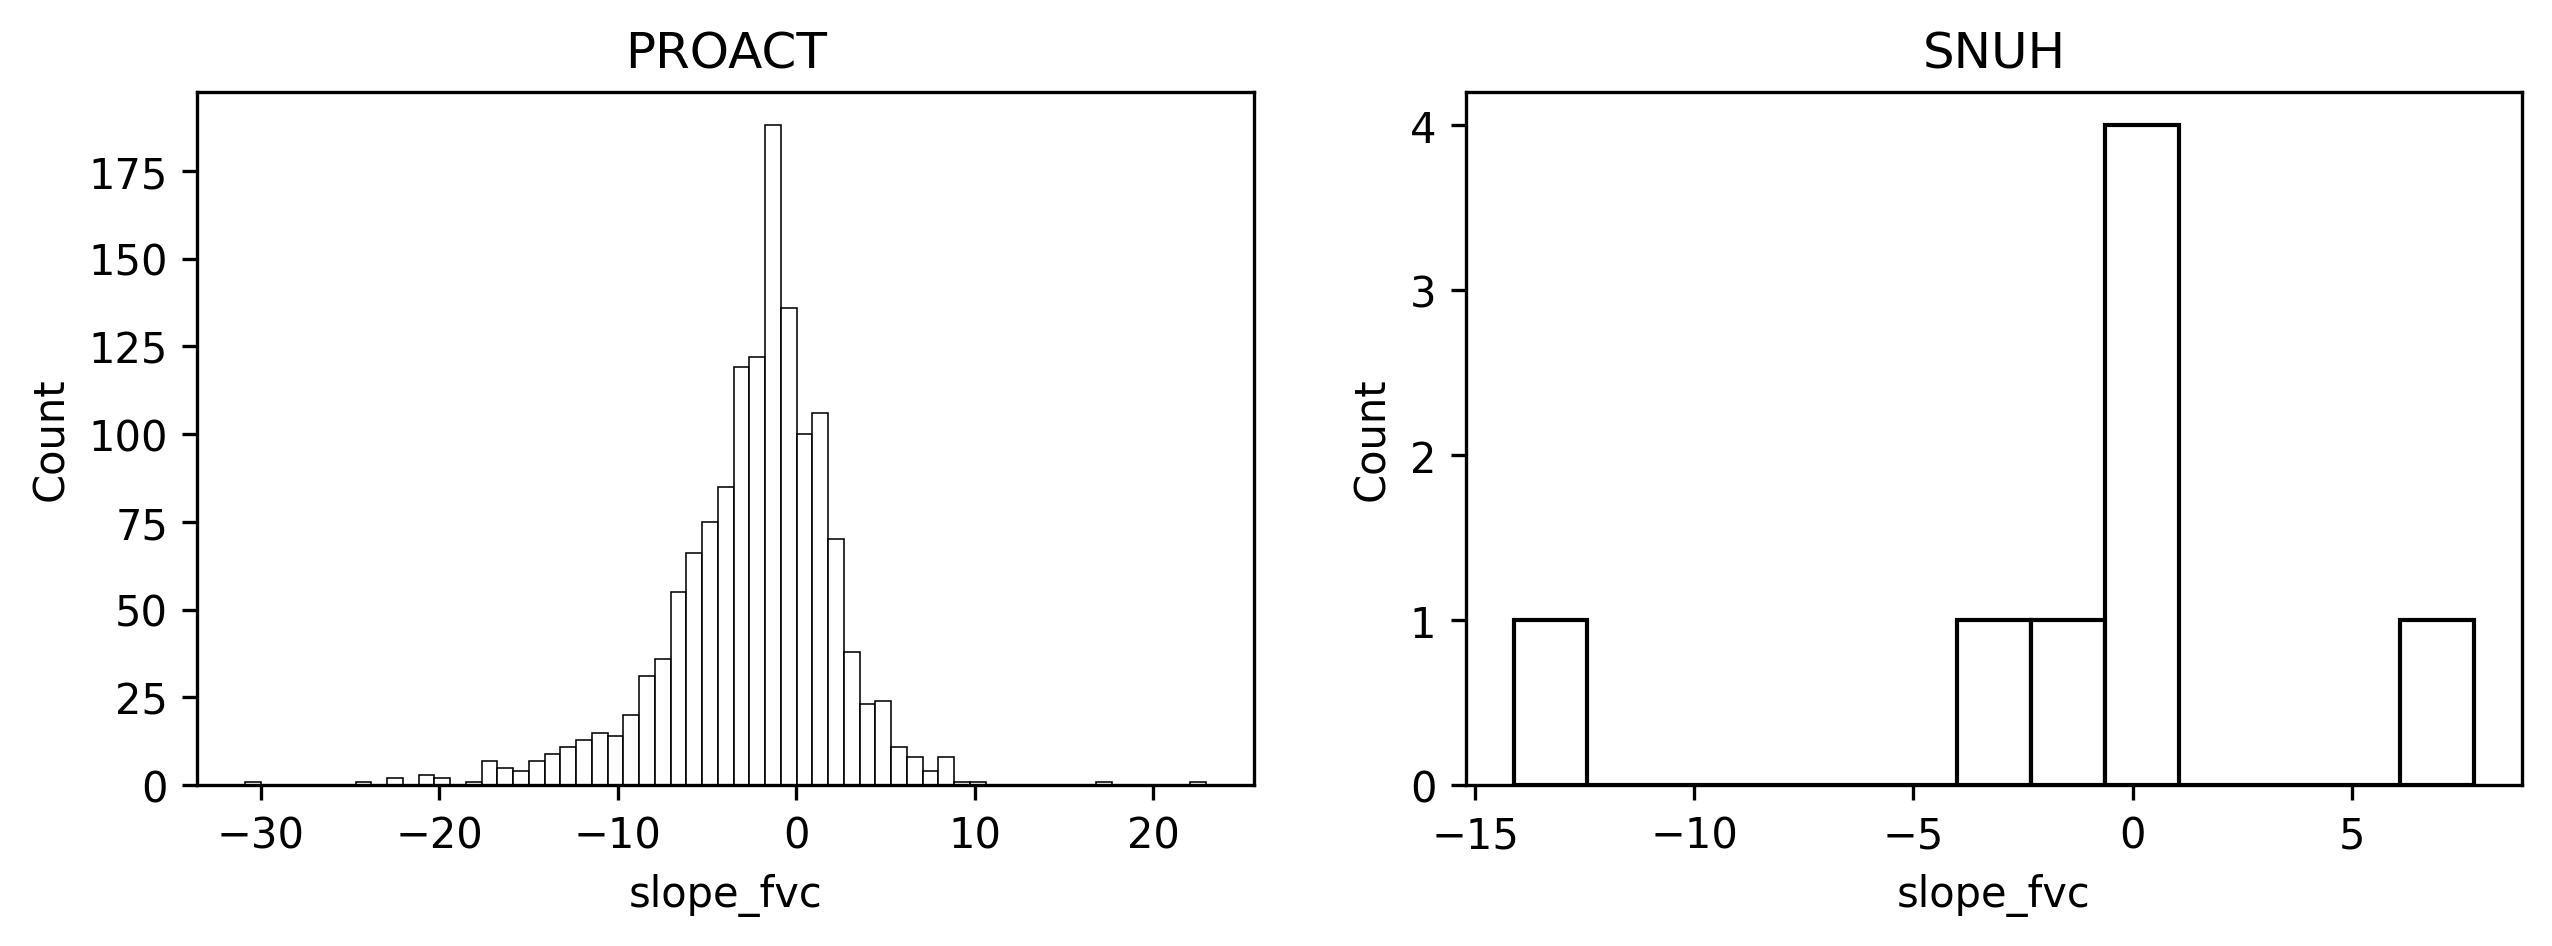

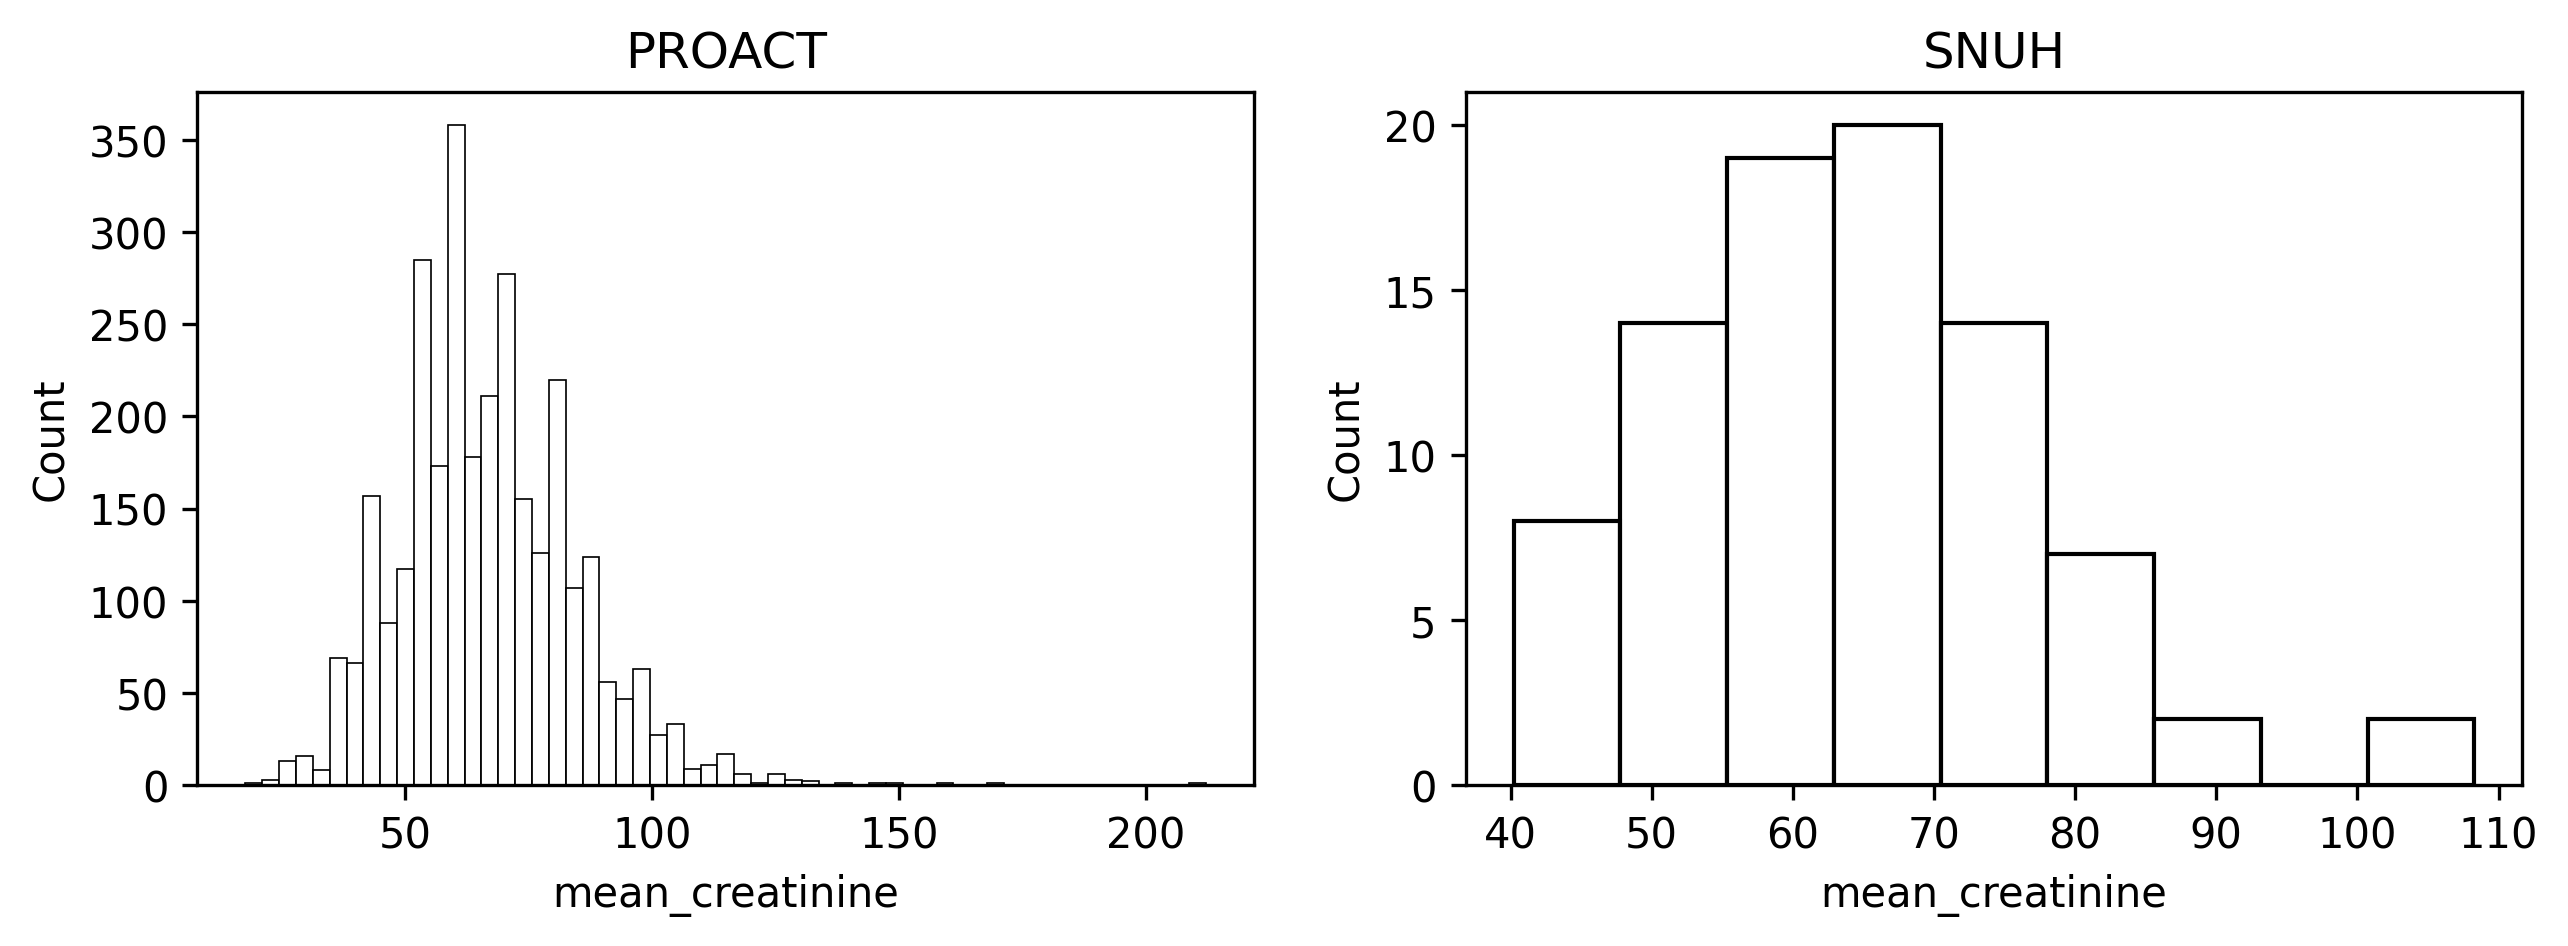

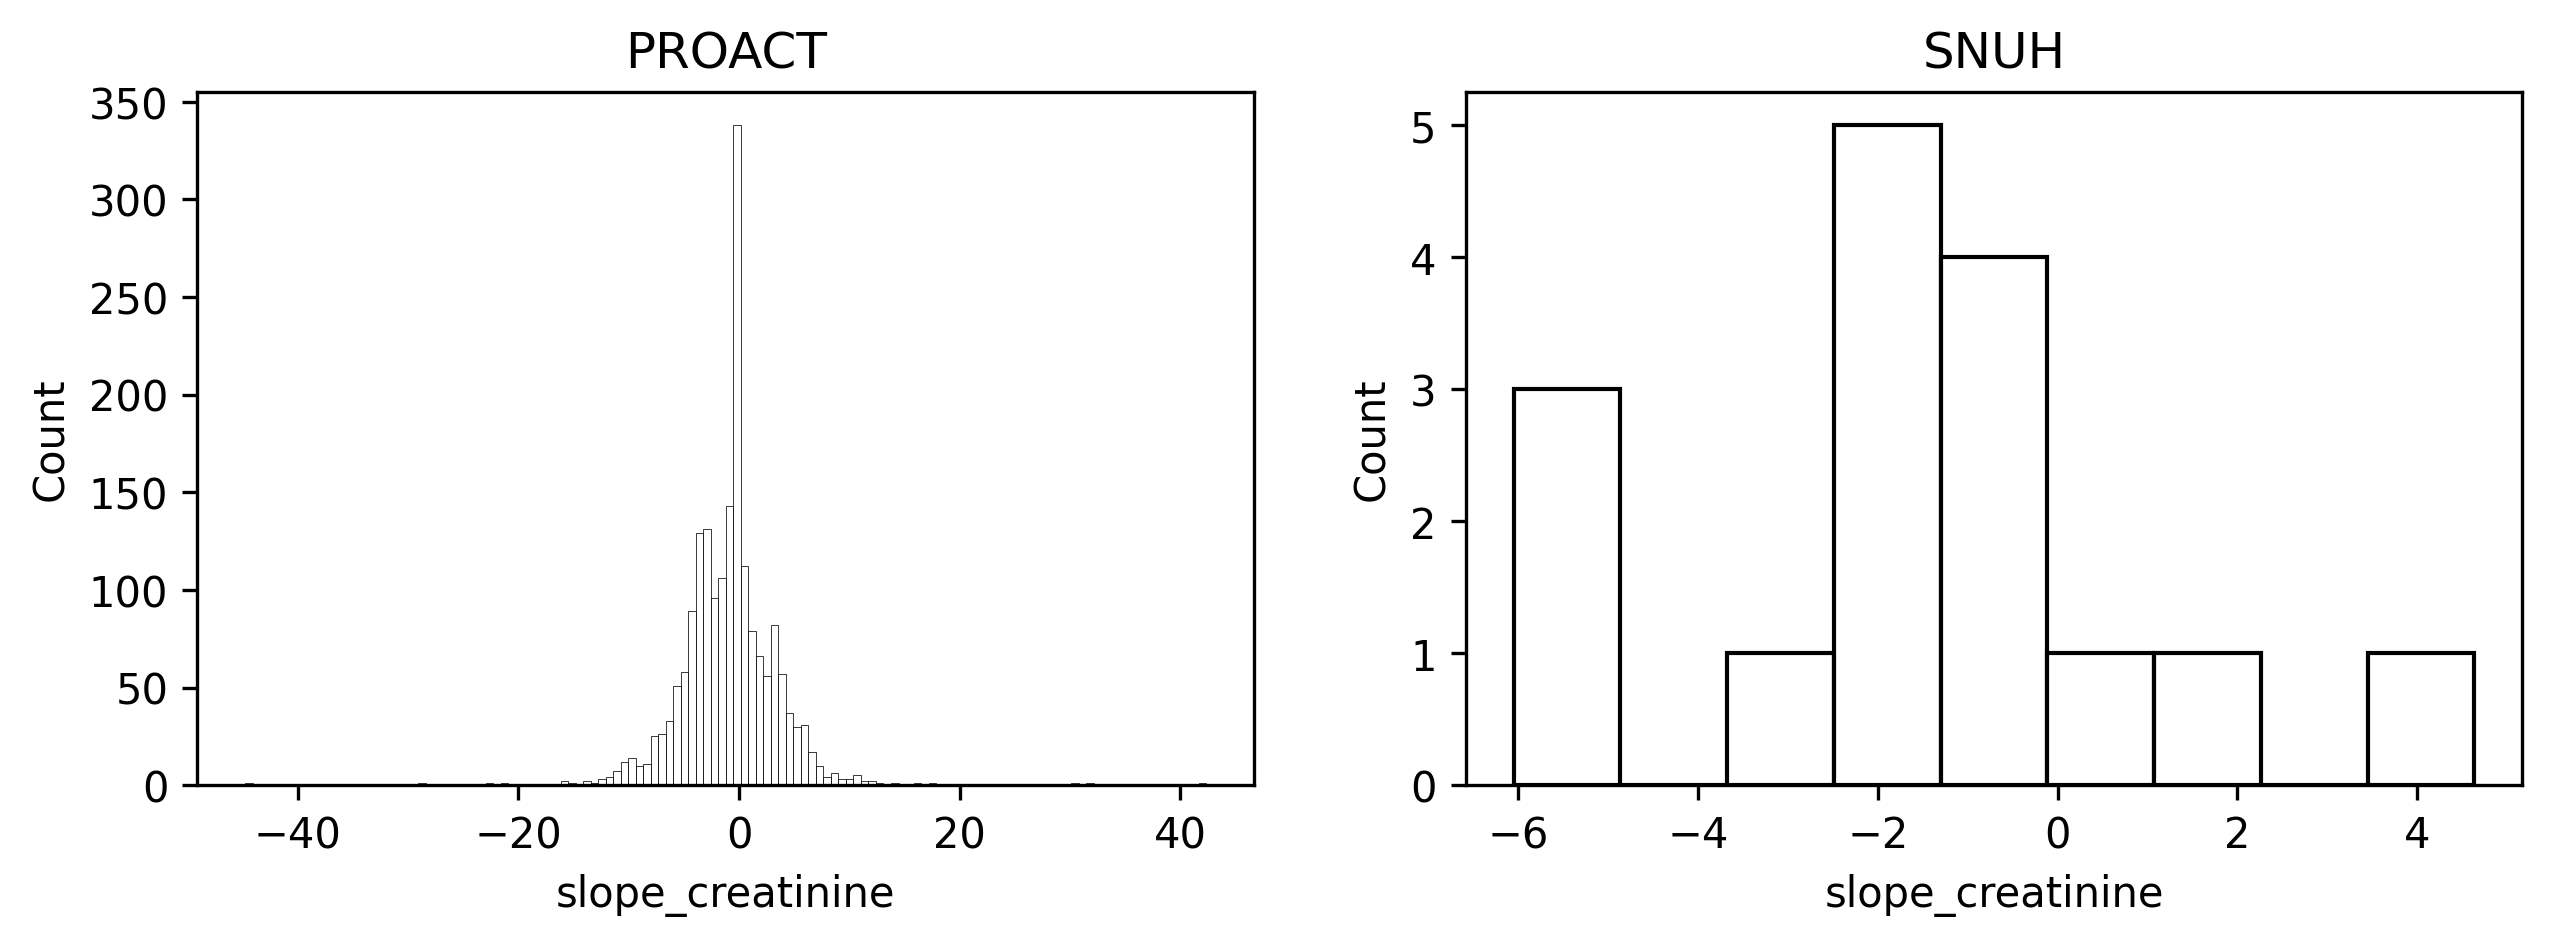

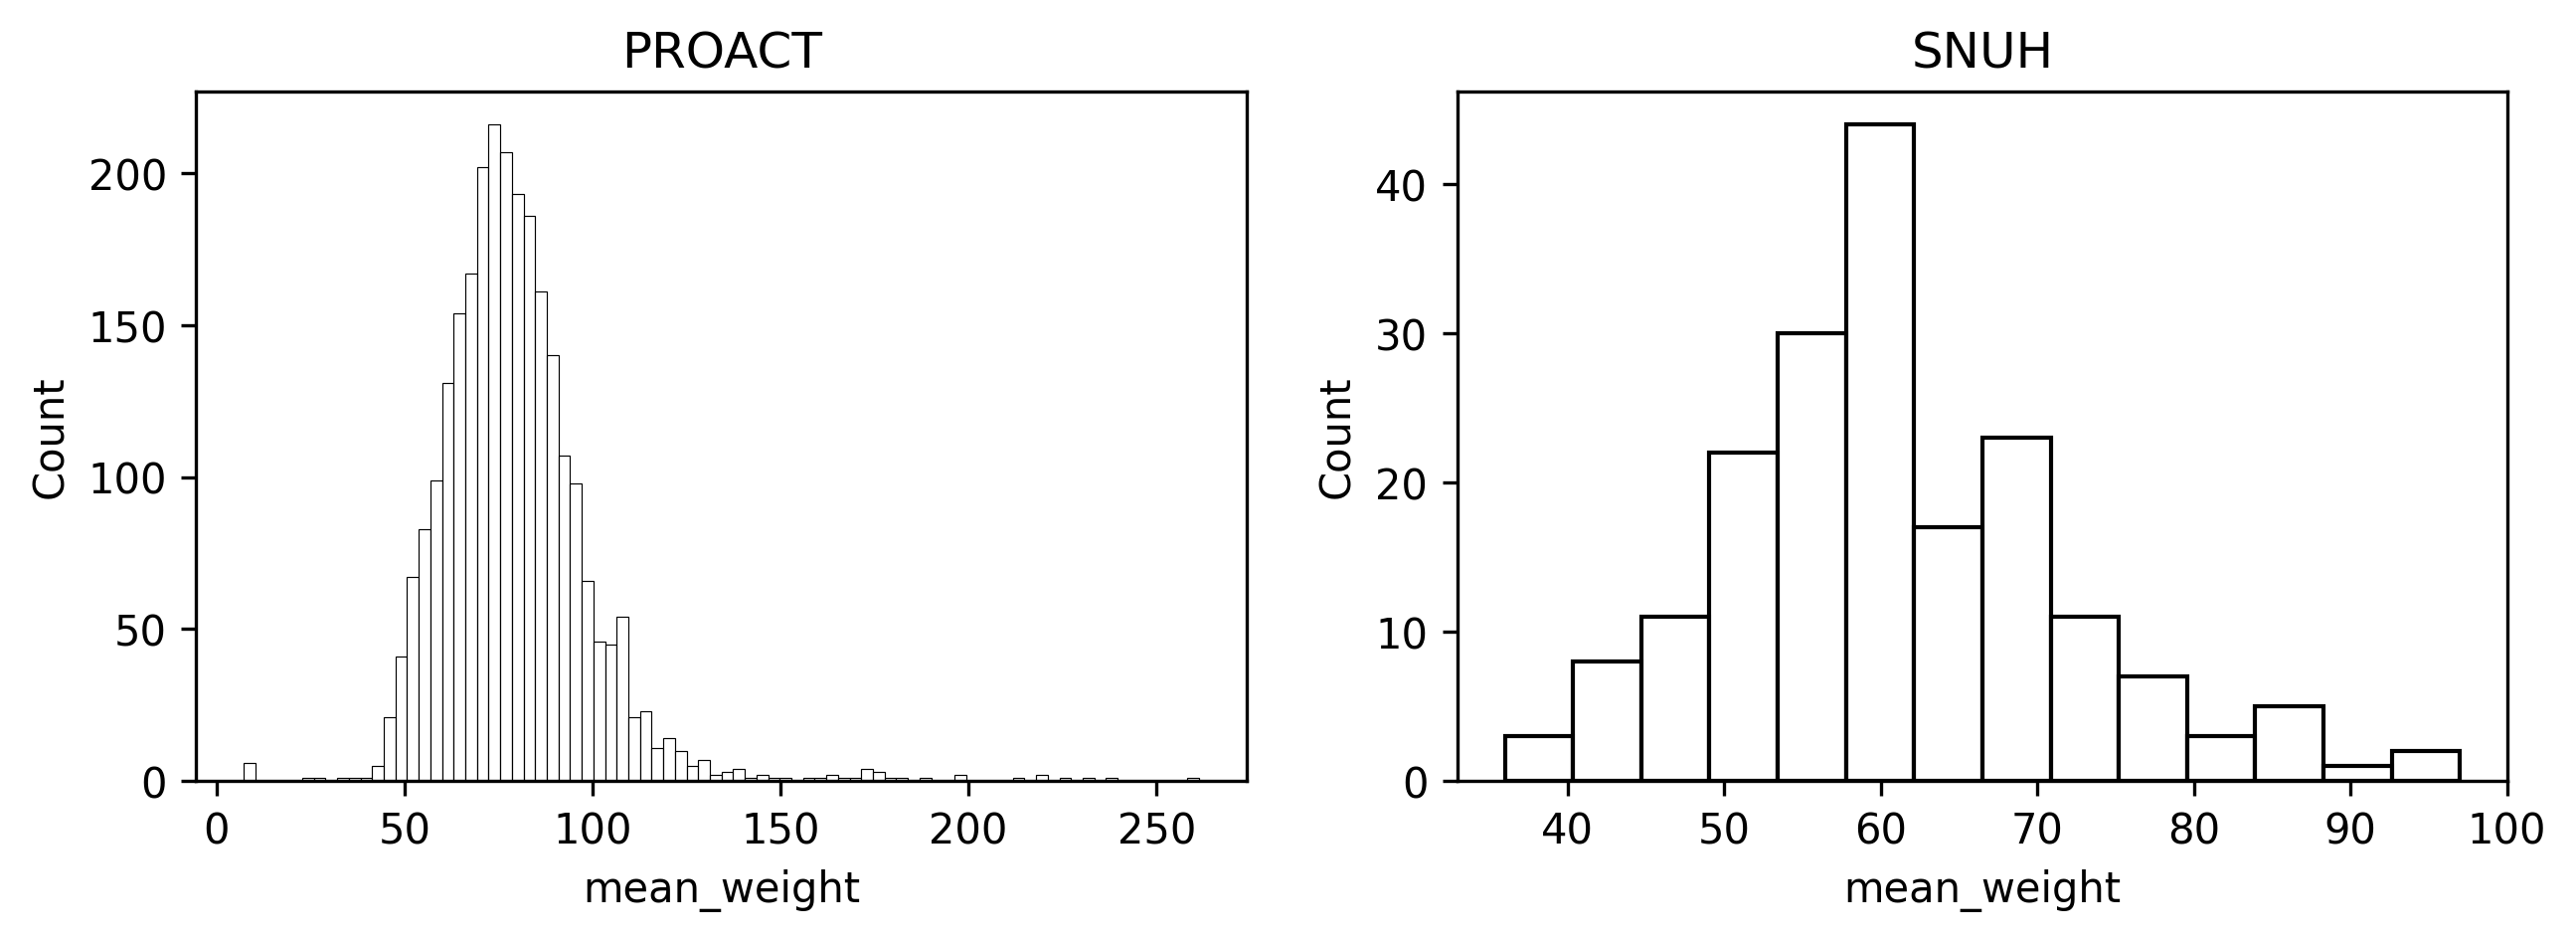

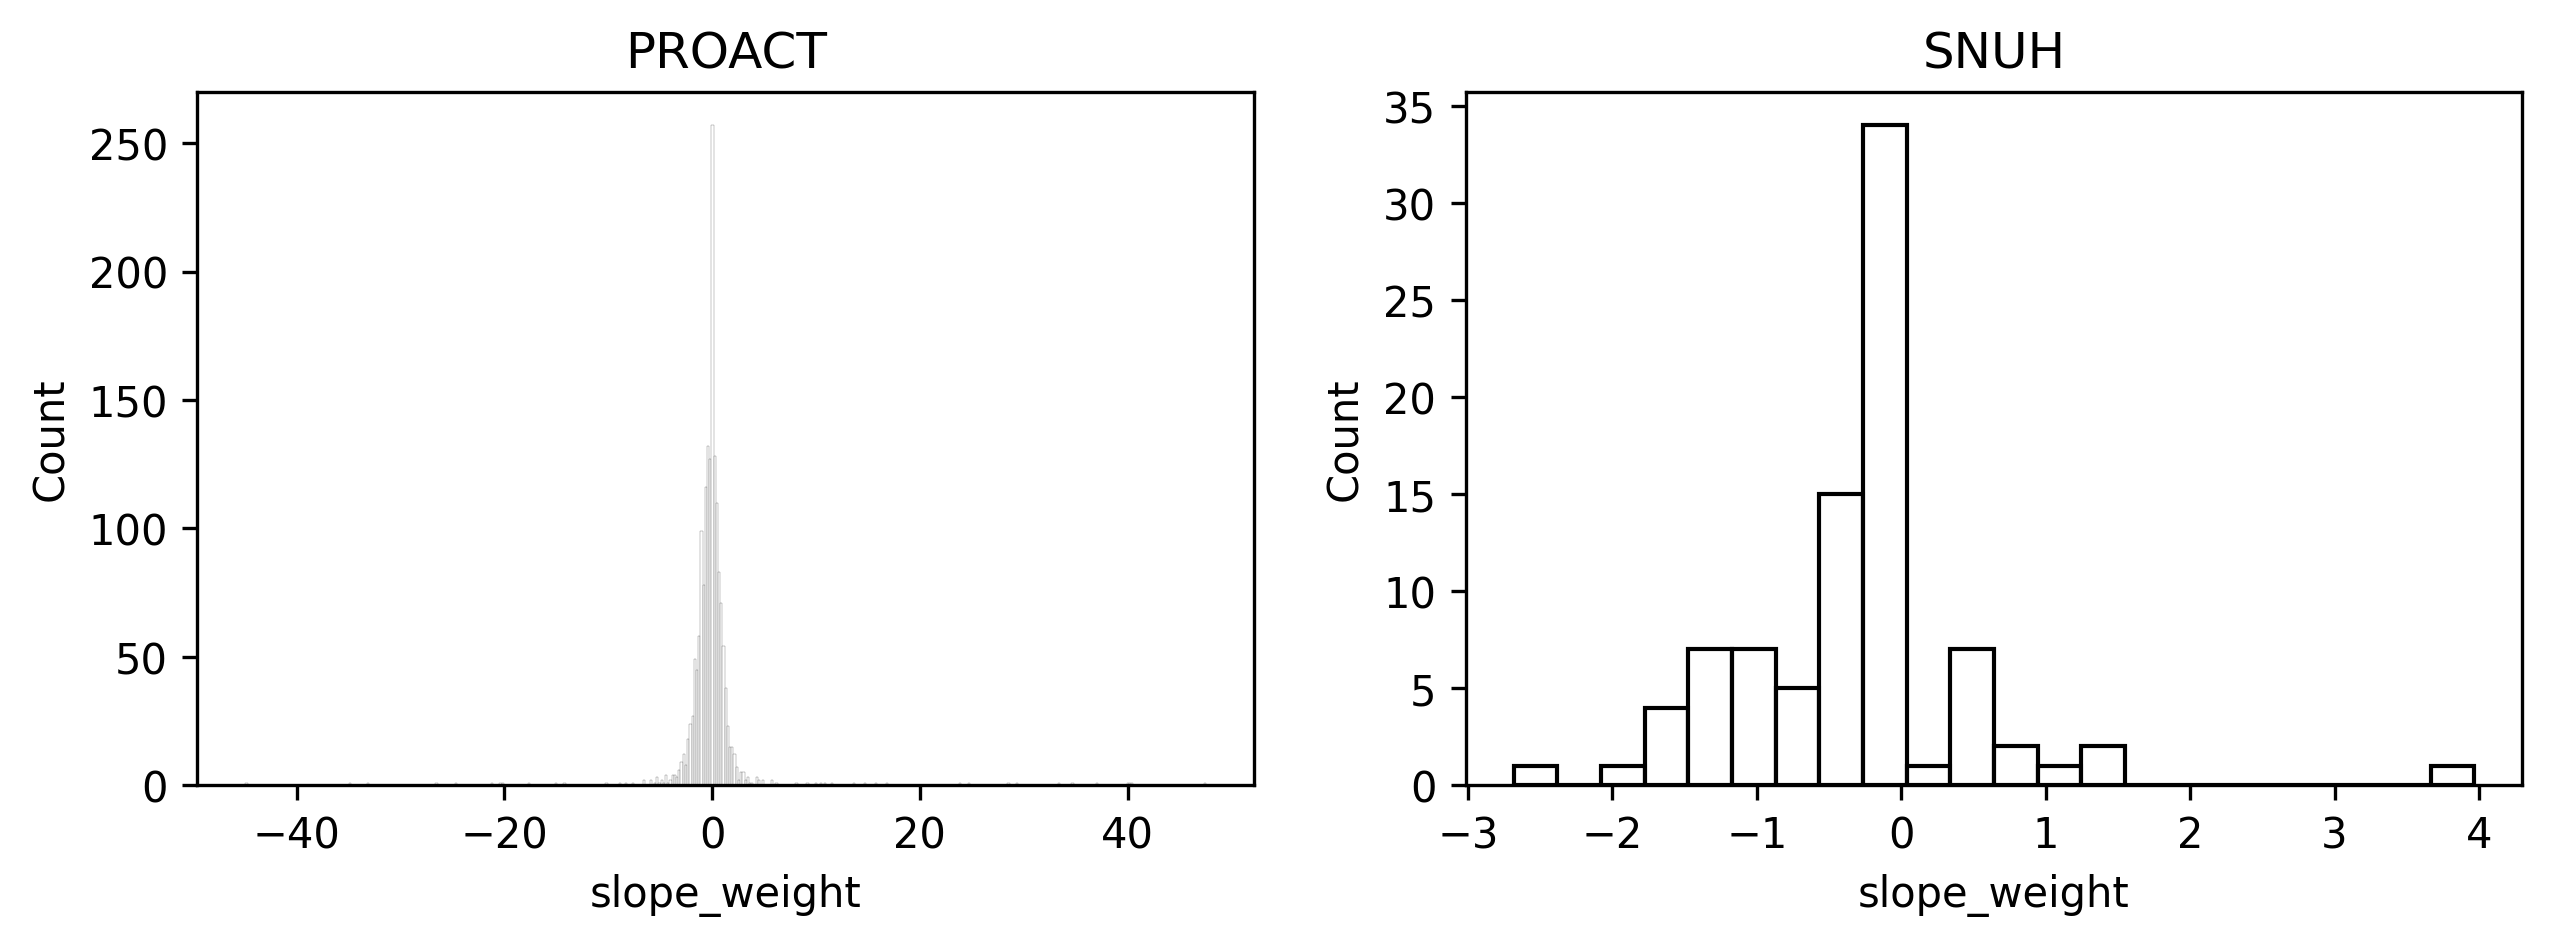

In [ ]:
feature_list = list(proact_feature.columns)
feature_list.remove('SubjectID')

for feature in feature_list:
  compare_feature_distribution_proact_snuh(feature)

# 5-2. Check normality (Shapiro test)

## Not normal
###(except for 'slope_ALSFRS_R_Total' & 'slope_motor' & 'Age' & 'mean_creatinine' & 'slope_creatinine' in SNUH data)

In [ ]:
import scipy.stats as st

In [ ]:
# Female = 0, Male = 1
proact_feature = proact_feature.replace({'Gender':{"F":0, "M":1}})

In [ ]:
proact_feature = proact_feature.astype('float')

In [ ]:
count = 0
for feature in feature_list:
  statistic1, pvalue1 = st.shapiro(proact_feature[feature].dropna())
  statistic2, pvalue2 = st.shapiro(snuh_feature[feature].dropna())

  check_normal1 = 'normal' if pvalue1 >= 0.05 else 'not normal'
  check_normal2 = 'normal' if pvalue2 >= 0.05 else 'not normal'
  if((check_normal1 == 'normal') or (check_normal2 == 'normal')): count += 1
  print(feature + ' of proact is ' + check_normal1)
  print(feature + ' of snuh is ' + check_normal2)
  print(count) # 'slope_ALSFRS_R_Total' & 'slope_motor' & 'Age' & 'mean_creatinine' & 'slope_creatinine' has normality only in SNUH data

Age of proact is not normal
Age of snuh is normal
1
Gender of proact is not normal
Gender of snuh is not normal
1
diag_delta of proact is not normal
diag_delta of snuh is not normal
1
onset_delta of proact is not normal
onset_delta of snuh is not normal
1
onset_site of proact is not normal
onset_site of snuh is not normal
1
diag_minus_onset of proact is not normal
diag_minus_onset of snuh is not normal
1
mean_Q1_Speech of proact is not normal
mean_Q1_Speech of snuh is not normal
1
mean_Q2_Salivation of proact is not normal
mean_Q2_Salivation of snuh is not normal
1
mean_Q3_Swallowing of proact is not normal
mean_Q3_Swallowing of snuh is not normal
1
mean_Q4_Handwriting of proact is not normal
mean_Q4_Handwriting of snuh is not normal
1
mean_Q6_Dressing_and_Hygiene of proact is not normal
mean_Q6_Dressing_and_Hygiene of snuh is not normal
1
mean_Q7_Turning_in_Bed of proact is not normal
mean_Q7_Turning_in_Bed of snuh is not normal
1
mean_Q8_Walking of proact is not normal
mean_Q8_Walkin

# 5-3. Feature statistics

In [ ]:
df_summary = pd.DataFrame(columns=['feature', 'Group', 'N', '25%', '50%', '75%', 'p-value'])

for feature in feature_list:
  row_proact = [feature, 'Proact', len(proact_feature[feature].dropna())] + list(np.percentile(proact_feature[feature].dropna(), [25, 50, 75], interpolation='linear'))
  row_snuh = [feature, 'Snuh', len(snuh_feature[feature].dropna())] + list(np.percentile(snuh_feature[feature].dropna(), [25, 50, 75], interpolation='linear'))

  u, pvalue = st.mannwhitneyu(x=proact_feature[feature].dropna(), y=snuh_feature[feature].dropna(), alternative = 'two-sided')

  row_proact.append(pvalue)
  row_snuh.append(pvalue)

  df_summary = df_summary.append(pd.Series(row_proact, index=df_summary.columns), ignore_index=True)
  df_summary = df_summary.append(pd.Series(row_snuh, index=df_summary.columns), ignore_index=True)

df_summary['p_value'] = round(df_summary['p-value'],4)
df_summary = df_summary[~df_summary['feature'].isin(['Gender', 'onset_site'])] #Because 'Gender' and 'onset_site' are categorical data, they were excluded from Mannwhitneyu test
df_summary[['feature', 'Group', 'N', '25%', '50%', '75%', 'p_value']]

<ipython-input-24-f4611c38a7f6>:4: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  row_proact = [feature, 'Proact', len(proact_feature[feature].dropna())] + list(np.percentile(proact_feature[feature].dropna(), [25, 50, 75], interpolation='linear'))
<ipython-input-24-f4611c38a7f6>:5: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  row_snuh = [feature, 'Snuh', len(snuh_feature[feature].dropna())] + list(np.percentile(snuh_feature[feature].dropna(), [25, 50, 75], interpolation='linear'))
<ipython-input-24-f4611c38a7f6>:12: FutureWarning: The frame.append method is deprecated and w

feature   Group     N        25%        50%        75%  p_value
0                Age  Proact  3396  48.000000  57.000000  64.000000   0.0000
1                Age    Snuh   207  54.000000  60.000000  68.000000   0.0000
4         diag_delta  Proact  3396   2.660000   5.635000  10.780000   0.0000
5         diag_delta    Snuh   207   1.000000   2.000000   6.500000   0.0000
6        onset_delta  Proact  3396  11.510000  17.030000  24.160000   0.0001
..               ...     ...   ...        ...        ...        ...      ...
83  slope_creatinine    Snuh    16  -2.101611  -1.311349  -0.497591   0.3475
84       mean_weight  Proact  2630  67.040000  77.300000  88.575000   0.0000
85       mean_weight    Snuh   187  54.000000  60.000000  67.000000   0.0000
86      slope_weight  Proact  1716  -0.830338  -0.056773   0.442576   0.1535
87      slope_weight    Snuh    88  -0.677629   0.000000   0.000000   0.1535

[84 rows x 7 columns]

In [ ]:
# Categorical data were analyzed by chi-square test
# Gender
print('Male : '+ str(len(proact_feature[proact_feature['Gender']==1])) + ', Female : '+ str(len(proact_feature[proact_feature['Gender']==0])) + ' in Proact data')
print('Male : '+ str(len(snuh_feature[snuh_feature['Gender']==1]))+ ', Female : '+ str(len(snuh_feature[snuh_feature['Gender']==0]))+ ' in Snuh data')


Male : 2190, Female : 1206 in Proact data
Male : 115, Female : 92 in Snuh data


In [ ]:
# Observed frequencies
proact_gender = [len(proact_feature[proact_feature['Gender']==0]), len(proact_feature[proact_feature['Gender']==1])]
snuh_gender = [len(snuh_feature[snuh_feature['Gender']==0]), len(snuh_feature[snuh_feature['Gender']==1])]

# Expected frequencies based on proportions
total_proact = len(proact_feature)
total_snuh = len(snuh_feature)
total = total_proact + total_snuh

expected_proact = [(total_proact / total) * (proact_gender[0] + snuh_gender[0]),
                   (total_proact / total) * (proact_gender[1] + snuh_gender[1])]

expected_snuh = [(total_snuh / total) * (proact_gender[0] + snuh_gender[0]),
                 (total_snuh / total) * (proact_gender[1] + snuh_gender[1])]

# Perform the chi-square test
observed = proact_gender + snuh_gender
expected = expected_proact + expected_snuh

# Perform the chi-squared test
chisq_gender, p_gender = st.chisquare(observed, f_exp=expected)
chisq_gender, p_gender #p=0.08

(6.754008129184381, 0.08016569360088154)

In [ ]:
# Onset_site
print('bulbar : '+ str(len(proact_feature[proact_feature['onset_site']==1])) + ', non-bulbar : '+ str(len(proact_feature[proact_feature['onset_site']==0])) + ' in Proact data')
print('bulbar : '+ str(len(snuh_feature[snuh_feature['onset_site']==1]))+ ', non-bulbar : '+ str(len(snuh_feature[snuh_feature['onset_site']==0]))+ ' in Snuh data')


bulbar : 612, non-bulbar : 2784 in Proact data
bulbar : 62, non-bulbar : 145 in Snuh data


In [ ]:
# Observed frequencies
proact_onset_site = [len(proact_feature[proact_feature['onset_site']==0]), len(proact_feature[proact_feature['onset_site']==1])]
snuh_onset_site = [len(snuh_feature[snuh_feature['onset_site']==0]), len(snuh_feature[snuh_feature['onset_site']==1])]

# Expected frequencies based on proportions
expected_proact = [(total_proact / total) * (proact_onset_site[0] + snuh_onset_site[0]),
                   (total_proact / total) * (proact_onset_site[1] + snuh_onset_site[1])]

expected_snuh = [(total_snuh / total) * (proact_onset_site[0] + snuh_onset_site[0]),
                 (total_snuh / total) * (proact_onset_site[1] + snuh_onset_site[1])]

# Perform the chi-square test
observed = proact_onset_site + snuh_onset_site
expected = expected_proact + expected_snuh

# Perform the chi-squared test
chisq_onset, p_onset = st.chisquare(observed, f_exp=expected)
chisq_onset, p_onset #p <0.05

(18.261630027453386, 0.0003884424013591779)

In [ ]:
f"{df_summary['25%']:.2f}"

TypeError: ignored

In [ ]:
df_summary['25%'] = round(df_summary['25%'],2)
df_summary['50%'] = round(df_summary['50%'],2)
df_summary['75%'] = round(df_summary['75%'],2)

In [ ]:
def format_p_value(p):
    if p < 0.05:
        return '<0.05'
    else:
        return p

In [ ]:
df_summary['p_value'] = df_summary['p_value'].apply(format_p_value)

In [ ]:
df_summary[['feature', 'Group', 'N', '25%', '50%', '75%', 'p_value']]

feature   Group     N    25%    50%    75% p_value
0                Age  Proact  3396  48.00  57.00  64.00   <0.05
1                Age    Snuh   207  54.00  60.00  67.00   <0.05
4         diag_delta  Proact  3396   2.66   5.64  10.78   <0.05
5         diag_delta    Snuh   207   1.00   2.00   6.50   <0.05
6        onset_delta  Proact  3396  11.51  17.03  24.16   <0.05
..               ...     ...   ...    ...    ...    ...     ...
83  slope_creatinine    Snuh    16  -2.10  -1.31  -0.50  0.3475
84       mean_weight  Proact  2630  67.04  77.30  88.57   <0.05
85       mean_weight    Snuh   187  54.00  60.00  67.00   <0.05
86      slope_weight  Proact  1716  -0.83  -0.06   0.44  0.1535
87      slope_weight    Snuh    88  -0.68   0.00   0.00  0.1535

[84 rows x 7 columns]

In [ ]:
df_summary[['feature', 'Group', 'N', '25%', '50%', '75%', 'p_value']].to_csv('/content/drive/MyDrive/Predicting Loss of Autonomy/1. Swallowing/Jul 2022 PRO-ACT data (latest update)/Files/Patient_characteristics.csv')